# Background

- Now have: chiller installed, Zaber fixed but arm removed and needs remounting.
- Want: set up Zaber arm and collect a new, complete set of pole-to-pole measurements.
- Different measurements enumerated in shared Google doc.

In [76]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [77]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import lmfit as lm
from operator import itemgetter
from time import time
#from pandas.api.types import is_numeric_dtype
#from dateutil import parser
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

# local imports
from plotting import config_plots, datetime_plt
from load_pattern_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d
from mu2e.mu2eplots import mu2e_plot3d

# from pandas.api.types import is_numeric_dtype
# from dateutil import parser

config_plots()
# plt.rcParams.update({"text.usetex": True})

In [78]:
ddir = '/home/ckampa/Dropbox/LogFiles/'

# Useful Functions

In [79]:
df_fits = pd.read_pickle('/home/ckampa/data/hallprobecalib_extras/datafiles/magnet_ramp/2021-02-24/ramp_2021-02-24.run-info_temp_params.pkl')
df_fits_low = df_fits.query('I <= 100').copy()
df_fits = df_fits.query('I > 100').copy()

In [80]:
def lin_mod(x, **params):
    return params['c0'] + params['c1'] * x

model = lm.Model(lin_mod, independent_vars=['x'])
params = lm.Parameters()
params.add('c0', vary=True, value=0)
params.add('c1', vary=True, value=0)
result_temp_coeff = model.fit(df_fits.B_NMR.values, x=df_fits.I.values, params=params)

In [81]:
result_temp_coeff

(<Figure size 720x720 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

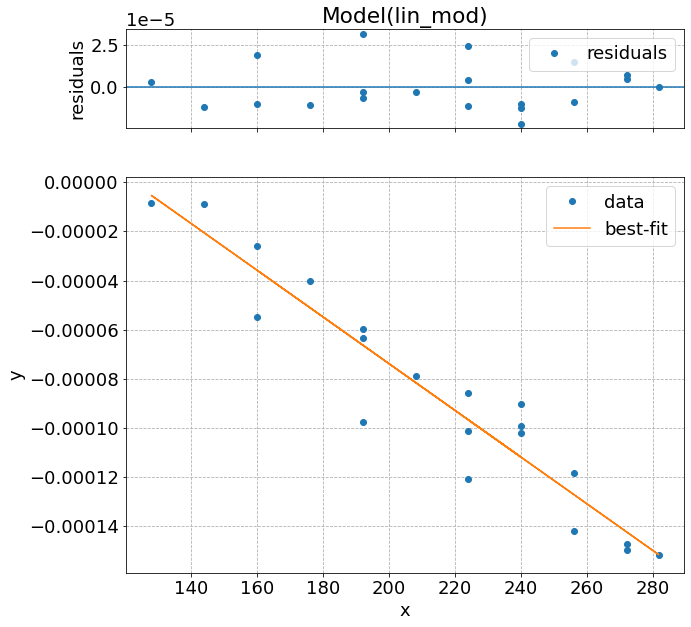

In [7]:
plt.rcParams.update({"text.usetex": False})
result_temp_coeff.plot()

In [62]:
plt.rcParams.update({"text.usetex": True})

In [9]:
def temp_correct(df, df_temp, T0=None, tempcol='Yoke (near pole)'):
    # set up interpolator
    t_interp = interp1d(df_temp.seconds_delta, df_temp[tempcol], kind='linear', fill_value="extrapolate")
    df.loc[:, tempcol] = t_interp(df.seconds_delta)
    if "run" in df.columns:
        B_corr = []
        for run in df.run.unique():
            df_ = df.query(f'run == {run}').copy()
            if T0 is None:
                T0_ = df_[tempcol].mean()
            else:
                T0_ = T0
            # correct temps
            I = df_['Magnet Current [A]'].mean()
            if I > 100:
                temp_coeff = lin_mod(I, **result_temp_coeff.params) # T / deg C
            else:
                temp_coeff = -1e-5 # conservative guess. FIXME!
            dB_vals = temp_coeff * (df_[tempcol] - T0_)
            B_corr.append(df_['NMR [T]'].values - dB_vals)
        B_corr = np.concatenate(B_corr)
    else:
        df_ = df.copy()
        if T0 is None:
            T0_ = df_[tempcol].mean()
        else:
            T0_ = T0
        # correct temps
        I = df_['Magnet Current [A]'].mean()
        if I > 100:
            temp_coeff = lin_mod(I, **result_temp_coeff.params) # T / deg C
        else:
            temp_coeff = -1e-5 # conservative guess. FIXME!
        dB_vals = temp_coeff * (df_[tempcol] - T0_)
        B_corr = (df_['NMR [T]'].values - dB_vals)
    return B_corr

## Plotting

In [10]:
def plot_xplane(df, xval, color='B_corr'):
    xcol = 'magnet_X_mm'
    ycol = 'magnet_Y_mm'
    zcol = 'magnet_Z_mm'
    xmin = df[xcol].min()
#     df_ = df.query(f'{xcol} == {xval}').copy()
    df_ = df[np.isclose(df[xcol], xval, atol=1e-1, rtol=1e-2)].copy()
    x_mm = df_[xcol].values[0]
    ymin = df_[ycol].min()
    zmin = df_[zcol].max()
    # plot
    fig, ax = plt.subplots()
    sc = ax.scatter(df_[ycol], df_[zcol],
                    c=df_[color], s=10)
    cb = fig.colorbar(sc, label=color)
    ax.set_xlabel('Y [mm]')
    ax.set_ylabel('Z [mm]')
    fig.suptitle(f'X = {x_mm:0.1f} [mm]')
#     fig.suptitle(f'Zaber Encoder X = {xval} [ADC]')
    return fig, ax

# Temperature Regression (from Magnet Ramp / B vs. I analysis)

In [11]:
# linear: NMR vs. temperature regression
def mod_lin(x, **params):
    return params['A'] + params['B'] * (x - params['X0'])

def linear_temperature_regression(df, xcol, ycol, ystd,
                                  ystd_sf=1, force_decreasing=False, T0 = 20.0):
    # query preprocessed data to get run
    df_ = df.copy()
    df_.loc[:, 'run_hours'] = df_.hours_delta.values
#     df_ = df.query(f'run_num == {run_num}').copy()
    # create an array for weights if float supplied
    if type(ystd) != np.ndarray:
        ystd = ystd*np.ones(len(df_))
    # setup lmfit model
    # y = A + B * x
    model = lm.Model(mod_lin, independent_vars=['x'])
    params = lm.Parameters()
    params.add('A', value=0, vary=True)
    params.add('B', value=0, vary=True)
    params.add('X0', value=T0, vary=False)
    # fit
    result = model.fit(df_[ycol].values, x=df_[xcol].values,
                       params=params, weights=1/ystd, scale_covar=False)
    # check if not decreasing and rerun
    if force_decreasing and (result.params['B'].value > 0.):
        params['B'].vary = False
        result = model.fit(df_[ycol].values, x=df_[xcol].values,
                           params=params, weights=1/ystd, scale_covar=False)
        # label for fit
        bv_str = f'{result.params["B"].value:0.3E}'
        ind = bv_str.find('E')
        b0 = bv_str[:ind]
        bsf = int(bv_str[ind+1:])
        be = f'{result.params["B"].stderr/10**bsf:0.3f}'

        label= (rf'$\underline{{y = A + B (x - {T0})}}$'+'\n'+
                rf'$A = {result.params["A"].value:0.7f}$'+'\n'+
                rf'$\pm {result.params["A"].stderr:0.7f}$'+'\n'+
                rf'$B =$'+'\n'+rf'$({b0}\pm{be})$'+
                rf'$\times 10^{{ {bsf} }}$'+' (fixed)\n'+
                # rf'$B = {result.params["B"].value:0.1f}$'+
                # rf'$\pm {result.params["B"].stderr:0.1f}$'+' (fixed)\n'+
                rf'$\chi^2_\mathrm{{red.}} = {result.redchi:0.2f}$'+'\n')
    else:
        # label for fit
        bv_str = f'{result.params["B"].value:0.3E}'
        ind = bv_str.find('E')
        b0 = bv_str[:ind]
        bsf = int(bv_str[ind+1:])
        be = f'{result.params["B"].stderr/10**bsf:0.3f}'

        label= (rf'$\underline{{y = A + B (x - {T0})}}$'+'\n'+
                rf'$A = {result.params["A"].value:0.7f}$'+'\n'+
                rf'$\pm {result.params["A"].stderr:0.7f}$'+'\n'+
                rf'$B =$'+'\n'+rf'$({b0}\pm{be})$'+
                rf'$\times 10^{{ {bsf} }}$'+'\n'+
                # rf'$B = {result.params["B"].value:0.3E}$'+
                # rf'$\pm {result.params["B"].stderr:0.3E}$'+'\n'+
                rf'$\chi^2_\mathrm{{red.}} = {result.redchi:0.2f}$'+'\n')
    # plot
    # set up figure with two axes
#     config_plots()
    fig = plt.figure()
    ax1 = fig.add_axes((0.12, 0.3, 0.7, 0.6))
    ax2 = fig.add_axes((0.12, 0.08, 0.7, 0.185))
    # colorbar axis
    cb_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # plot data and fit
    # data
    # with errorbars
    if ystd_sf == 1:
        label_data = 'Data'
    else:
        label_data = r'Data (error $\times$'+f'{ystd_sf})'
    ax1.errorbar(df_[xcol].values, df_[ycol].values, yerr=ystd_sf*ystd,
                 fmt='o', ls='none', ms=2, zorder=100, label=label_data)
    # scatter with color
    #sc = ax1.scatter(df_[xcol].values, df_[ycol].values, c=df_.index, s=1,
    #                 zorder=101)
    sc = ax1.scatter(df_[xcol].values, df_[ycol].values, c=df_.run_hours, s=1,
                     zorder=101)
    # fit
    ax1.plot(df_[xcol].values, result.best_fit, linewidth=2, color='red',
             zorder=99, label=label)
    # calculate residual (data - fit)
    res = df_[ycol].values - result.best_fit
    # calculate ylimit for ax2
    yl = 1.1*(np.max(np.abs(res)) + ystd_sf*ystd[0])
    # plot residual
    # zero-line
    xmin = np.min(df_[xcol].values)
    xmax = np.max(df_[xcol].values)
    ax2.plot([xmin, xmax], [0, 0], 'k--', linewidth=2, zorder=98)
    # residual
    ax2.errorbar(df_[xcol].values, res, yerr=ystd_sf*ystd, fmt='o', ls='none',
                 ms=2, zorder=99)
    #ax2.scatter(df_[xcol].values, res, c=df_.index, s=1, zorder=101)
    ax2.scatter(df_[xcol].values, res, c=df_.run_hours, s=1, zorder=101)
    # colorbar for ax1
    cb = fig.colorbar(sc, cax=cb_ax)
    cb.set_label('Time [Hours]')
    ## WITH DATETIME
    #cb.set_t
    # print(f'vmin = {sc.colorbar.vmin}')
    # print(f'vmax = {sc.colorbar.vmax}')
    # # change colobar ticks labels and locators
    # cb.set_ticks([sc.colorbar.vmin + t*(sc.colorbar.vmax-sc.colorbar.vmin)
    #              for t in cb.ax.get_yticks()])
    # cbtls = [mdates.datetime.datetime.fromtimestamp((sc.colorbar.vmin +
    #          t*(sc.colorbar.vmax-sc.colorbar.vmin))*1e-9).strftime('%c')
    #          for t in cb.ax.get_yticks()]
    # cb.set_ticklabels(cbtls)
    #cb.ax.set_yticklabels(df_.index.strftime('%m-%d %H:%M'))
    # formatting
    # kludge for NMR or Hall
    if ycol == 'NMR [T]':
        ylabel1 = r'$|B|_\mathrm{NMR}$ [T]'
        title_prefix = 'NMR'
    else:
        ylabel1 = r'$|B|_\mathrm{Hall}$ [T]'
        title_prefix = 'Hall Probe'
    # set ylimit ax2
    ax2.set_ylim([-yl, yl])
    # remove ticklabels for ax1 xaxis
    ax1.set_xticklabels([])
    # axis labels
    ax2.set_xlabel(r'Yoke (center magnet) Temp. [$^{\circ}$C]')
    ax2.set_ylabel('(Data - Fit) [T]')
    ax1.set_ylabel(ylabel1)
    # force consistent x axis range for ax1 and ax2
    tmin = np.min(df_[xcol].values)
    tmax = np.max(df_[xcol].values)
    range_t = tmax-tmin
    ax1.set_xlim([tmin-0.1*range_t, tmax+0.1*range_t])
    ax2.set_xlim([tmin-0.1*range_t, tmax+0.1*range_t])
    # turn on legend
    ax1.legend().set_zorder(102)
    # add title
    fig.suptitle(f'{title_prefix} vs. Temperature Regression: Linear Model')#\n'+
                 #f'Run Index {run_num}')
    # minor ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax2.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    # inward ticks and ticks on right and top
    ax1.tick_params(which='both', direction='in', top=True, right=True,
                    bottom=True)
    ax2.tick_params(which='both', direction='in', top=True, right=True)
    # save figure
    #fig.tight_layout()
#     fig.savefig(plotfile+'.pdf')
#     fig.savefig(plotfile+'.png')
    return result, fig, ax1, ax2

# B vs. Temp. (Low NMR)

## 06-06-22 42 A
- Started at 45 deg C --> 18 deg C
- Try to fit temperature coefficient and see if there is agreement with constant

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-06-06 042715slow.txt'

In [ ]:
df_temp = load_data(tempfile, low_NMR=True).iloc[1:]

In [ ]:
df_temp

In [ ]:
fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (near pole)'], df_temp['NMR [T]'], c=df_temp.hours_delta)
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

In [ ]:
fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (center magnet)'], df_temp['NMR [T]'], c=df_temp.hours_delta)
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

In [ ]:
cut = 60

fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (center magnet)'].iloc[cut:], df_temp['NMR [T]'].iloc[cut:], c=df_temp.hours_delta.iloc[cut:])
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

In [ ]:
result, fig, ax1, ax2 = linear_temperature_regression(df_temp.iloc[cut:], xcol='Yoke (center magnet)', ycol='NMR [T]', ystd=1e-6, ystd_sf=1, force_decreasing=False, T0 = 20.0)

In [ ]:
# temp


## 06-06-22 56 A
- Started at 56 deg C --> 18 deg C to 45 deg C
- Try to fit temperature coefficient and see if there is agreement with constant

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-06-06 224515slow.txt'

In [ ]:
df_temp = load_data(tempfile, low_NMR=True).iloc[1:]

In [ ]:
df_temp

In [ ]:
fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (near pole)'], df_temp['NMR [T]'], c=df_temp.hours_delta)
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

In [ ]:
fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (center magnet)'], df_temp['NMR [T]'], c=df_temp.hours_delta)
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

In [ ]:
#cut = 0
cut = 10*60

fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (center magnet)'].iloc[cut:], df_temp['NMR [T]'].iloc[cut:], c=df_temp.hours_delta.iloc[cut:])
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

In [ ]:
result, fig, ax1, ax2 = linear_temperature_regression(df_temp.iloc[cut:], xcol='Yoke (center magnet)', ycol='NMR [T]', ystd=1e-6, ystd_sf=1, force_decreasing=False, T0 = 20.0)

In [ ]:
# 2022-06-06 23:04
# for historical purposes, see how this number changes over time
result.params['B']

## 06-24-22 128 A
- 15 deg C --> 45 deg C --> 15 deg C
- Try to fit temperature coefficient and see if there is agreement with previous results

In [53]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-06-24 142930slow.txt'

In [54]:
df_temp = load_data(tempfile, low_NMR=True).iloc[1:]

In [55]:
df_temp

Time  Magnet Current [A]  \
Datetime                                                        
2022-06-24 14:30:06  6/24/2022 2:30:06 PM          128.034877   
2022-06-24 14:30:56  6/24/2022 2:30:56 PM          128.034877   
2022-06-24 14:31:46  6/24/2022 2:31:46 PM          128.034933   
2022-06-24 14:32:36  6/24/2022 2:32:36 PM          128.034763   
2022-06-24 14:33:26  6/24/2022 2:33:26 PM          128.034877   
...                                   ...                 ...   
2022-07-05 11:36:57  7/5/2022 11:36:57 AM          128.034707   
2022-07-05 11:37:47  7/5/2022 11:37:47 AM          128.034537   
2022-07-05 11:38:37  7/5/2022 11:38:37 AM          128.034763   
2022-07-05 11:39:27  7/5/2022 11:39:27 AM          128.034820   
2022-07-05 11:40:18  7/5/2022 11:40:18 AM          128.034820   

                     Magnet Voltage [V]     Coil 1     Coil 2  LCW in Coil1  \
Datetime                                                                      
2022-06-24 14:30:06           14.465582  17.525785  16.482651      6.318693   
2022-06-24 14:30:56           14.463770  17.515543  16.463682      6.533363   
2022-06-24 14:31:46           14.462670  17.499079  16.450304      6.898682   
2022-06-24 14:32:36           14.462615  17.477829  16.436220      7.283544   
2022-06-24 14:33:26           14.463598  17.485716  16.439810      7.676805   
...                                 ...        ...        ...           ...   
2022-07-05 11:36:57           14.455342  17.218744  16.455719      6.449790   
2022-07-05 11:37:47           14.454067  17.190922  16.434219      6.819168   
2022-07-05 11:38:37           14.453822  17.185350  16.420938      7.232837   
2022-07-05 11:39:27           14.454625  17.191099  16.417271      7.594221   
2022-07-05 11:40:18           14.456542  17.203735  16.431610      7.952375   

                     LCW out Coil 1  LCW in Coil 2  LCW out Coil 2  \
Datetime                                                             
2022-06-24 14:30:06        8.870836       8.062930        8.743208   
2022-06-24 14:30:56        8.892229       7.969633        8.811044   
2022-06-24 14:31:46        9.096024       8.286791        9.066467   
2022-06-24 14:32:36        9.347280       8.508671        9.336826   
2022-06-24 14:33:26        9.631717       8.798165        9.631893   
...                             ...            ...             ...   
2022-07-05 11:36:57        8.631613       7.964330        8.468062   
2022-07-05 11:37:47        8.850051       8.148500        8.752876   
2022-07-05 11:38:37        9.140162       8.426359        9.046952   
2022-07-05 11:39:27        9.412348       8.729626        9.354796   
2022-07-05 11:40:18        9.714566       9.027262        9.646243   

                     Yoke (near pole)  ...  Zaber_Meas_Encoder_Y  \
Datetime                               ...                         
2022-06-24 14:30:06         13.833675  ...              426431.0   
2022-06-24 14:30:56         13.834734  ...              426431.0   
2022-06-24 14:31:46         13.836576  ...              426431.0   
2022-06-24 14:32:36         13.836263  ...              426431.0   
2022-06-24 14:33:26         13.833068  ...              426431.0   
...                               ...  ...                   ...   
2022-07-05 11:36:57         13.791729  ...              426431.0   
2022-07-05 11:37:47         13.792004  ...              426431.0   
2022-07-05 11:38:37         13.792004  ...              426431.0   
2022-07-05 11:39:27         13.792435  ...              426431.0   
2022-07-05 11:40:18         13.793415  ...              426431.0   

                     Zaber_Meas_Micron_Y  Zaber_Meas_Encoder_Z  \
Datetime                                                         
2022-06-24 14:30:06        166574.609375             1664882.0   
2022-06-24 14:30:56        166574.609375             1664882.0   
2022-06-24 14:31:46        166574.609375             1664882.0   
2022-06-24 14:32:36        166574.609

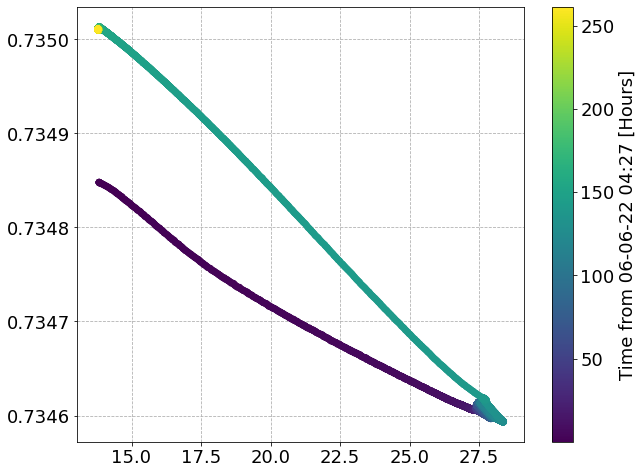

In [56]:
fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (near pole)'], df_temp['NMR [T]'], c=df_temp.hours_delta)
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

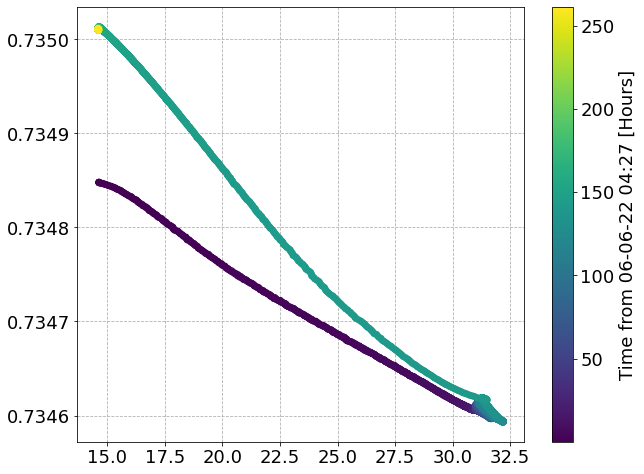

In [57]:
fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (center magnet)'], df_temp['NMR [T]'], c=df_temp.hours_delta)
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

Datetime
2022-06-24 22:50:06    28.858816
Name: Yoke (center magnet), dtype: float64


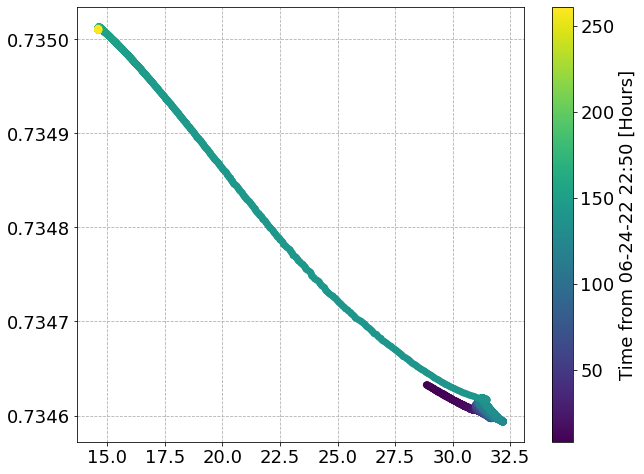

In [60]:
#cut = 0
cut = 10*60
print(df_temp['Yoke (center magnet)'].iloc[cut:cut+1])

fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (center magnet)'].iloc[cut:], df_temp['NMR [T]'].iloc[cut:], c=df_temp.hours_delta.iloc[cut:])
cb = fig.colorbar(sc, label='Time from 06-24-22 22:50 [Hours]')

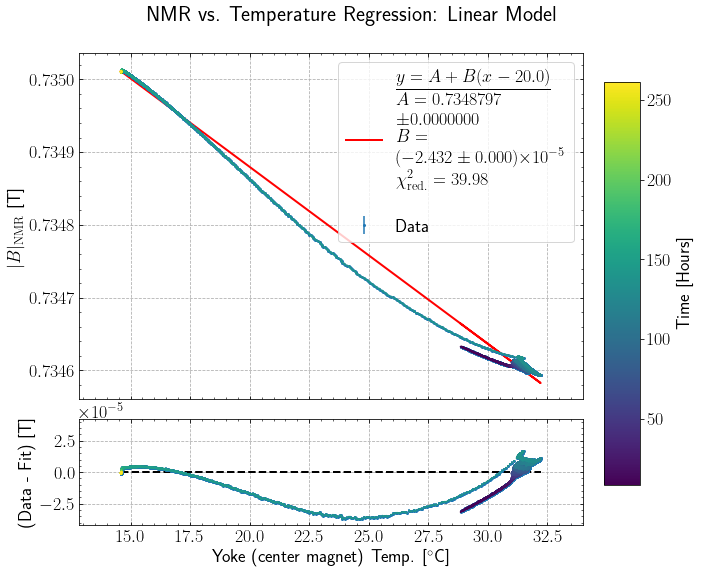

In [63]:
result, fig, ax1, ax2 = linear_temperature_regression(df_temp.iloc[cut:], xcol='Yoke (center magnet)', ycol='NMR [T]', ystd=1e-6, ystd_sf=1, force_decreasing=False, T0 = 20.0)

In [64]:
# 2022-06-06 23:04
# for historical purposes, see how this number changes over time
result.params['B']

<Parameter 'B', value=-2.4321659843365934e-05 +/- 9.03e-10, bounds=[-inf:inf]>

In [65]:
# cut tail

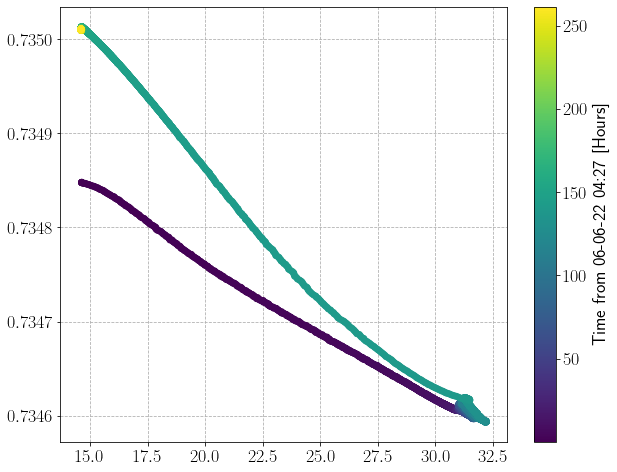

In [66]:
fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (center magnet)'], df_temp['NMR [T]'], c=df_temp.hours_delta)
cb = fig.colorbar(sc, label='Time from 06-06-22 04:27 [Hours]')

Datetime
2022-06-29 16:47:41    31.885147
Name: Yoke (center magnet), dtype: float64


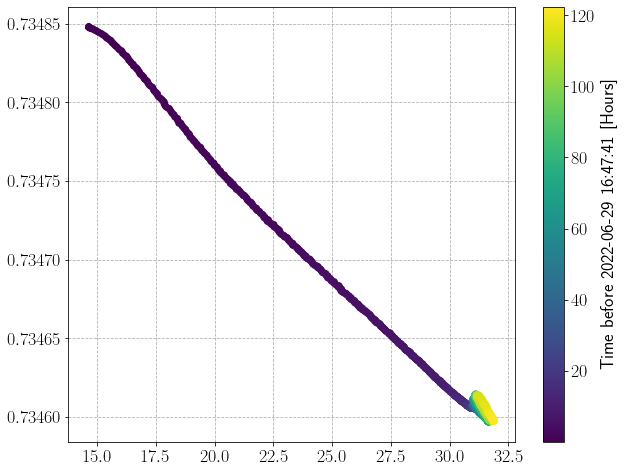

In [72]:
#cut = 0
cut = 10000
L = len(df_temp)
print(df_temp['Yoke (center magnet)'].iloc[-cut:-cut+1])

fig, ax = plt.subplots()

sc = ax.scatter(df_temp['Yoke (center magnet)'].iloc[:-cut], df_temp['NMR [T]'].iloc[:-cut], c=df_temp.hours_delta.iloc[:-cut])
cb = fig.colorbar(sc, label='Time before '+str(df_temp.index[-cut])+' [Hours]')

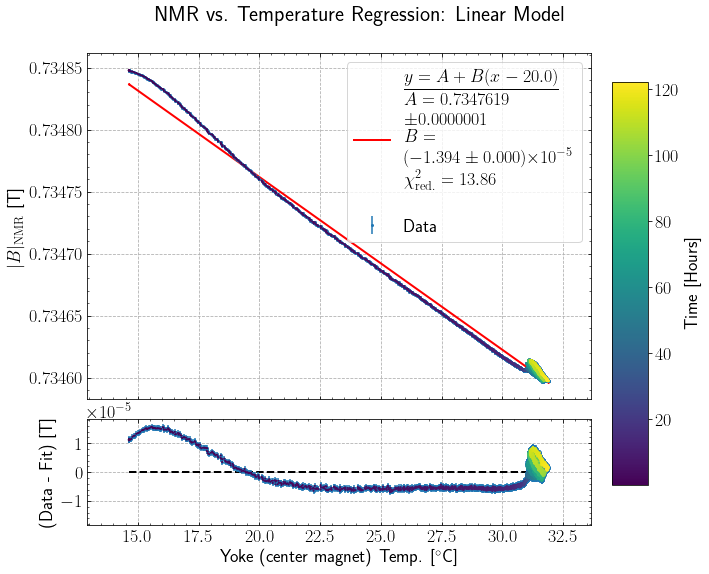

In [74]:
result, fig, ax1, ax2 = linear_temperature_regression(df_temp.iloc[:-cut], xcol='Yoke (center magnet)', ycol='NMR [T]', ystd=1e-6, ystd_sf=1, force_decreasing=False, T0 = 20.0)

In [75]:
# 2022-06-06 23:04
# for historical purposes, see how this number changes over time
result.params['B']

<Parameter 'B', value=-1.3938199942704779e-05 +/- 4.68e-09, bounds=[-inf:inf]>

# 3D Scans

In [82]:
plt.rcParams.update({"text.usetex": False})

## 05-25-22 Overnight
- 51 mm x 20 mm x 20 mm (X x Y x Z) with step size 2 mm in each dimension.
- Did not complete overnight -- looks to be a little over half done.
- Check here if we have enough data for the analysis.
    - If yes, stop measurement.
    - If no, figure out how long I need to wait.

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-05-25 182823slow.txt'
datafile = ddir+'temp_pole_to_pole_05-25-22/2022-05-25 184012.txt'
datafile1d = ddir+'temp_pole_to_pole_05-25-22/2022-05-26 100634.txt'

In [ ]:
df = load_data(datafile, low_NMR=True)
df_1d = load_data(datafile1d, low_NMR=True).iloc[1:].copy()
df_temp = load_data(tempfile, low_NMR=True)

In [ ]:
df[['Magnet Current [A]', 'NMR [T]']]

In [ ]:
for df_ in [df, df_1d]:
    df_.eval('run = 3', inplace=True)
    df_['seconds_delta'] = (df_.index - df_temp.index[0]).total_seconds()
    df_['hours_delta'] = (df_.index - df_temp.index[0]).total_seconds()/60**2
    df_['days_delta'] = (df_.index - df_temp.index[0]).total_seconds()/(24*60**2)
    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()
    # temperature correction
    B_corr = temp_correct(df_, df_temp, tempcol="Yoke (near pole)")
#     B_corr = temp_correct(df_, df_temp, tempcol="Yoke (center magnet)")
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
    df_.loc[:, 'B_corr'] = B_corr
    df_.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
    # recalculate scale factor
    # find field value at Hall probe location
    sf_corr_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['B_corr']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_corr_list.append(sf)
    df_['sf_corr'] = sf_corr_list

In [ ]:
# from Zaber_Magnet_Convert_Jun21 import zaber_ADC_to_magnet_mm as zaber_ADC_to_magnet_mm_Jun21
# df_old = load_data(ddir+'2021-06-15 073806.txt', low_NMR=False)
# df_old = df_old.query("127 < `Magnet Current [V]` < 129").copy()
# for i in ['X', 'Y', 'Z']:
#     #df[f'magnet_{i}_mm'] = ADC_to_mm(df[f'Zaber_Meas_Encoder_{i}'].values, coord=i)
#     df_old[f'magnet_{i}_mm'] = zaber_ADC_to_magnet_mm_Jun21(df_old[f'Zaber_Meas_Encoder_{i}'].values, coord=i, low_NMR=False)

In [ ]:
#df

In [ ]:
df_1d

In [ ]:
len(df)

In [ ]:
len(df_1d)

In [ ]:
df = df.query('`NMR [T]` > 0.2').copy()

In [ ]:
len(df)

In [ ]:
fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['NMR [T]']], scale_unit='T', inline=True)

In [ ]:
df_temp['Yoke (near pole)']

In [ ]:
df.magnet_Z_mm.unique()

In [ ]:
df.magnet_X_mm.unique()

In [ ]:
df_line = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()

In [ ]:
# missed 34.5...
sf = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_corr = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf, sf_corr

In [ ]:
df_1d.magnet_X_mm.unique()

In [ ]:
# missed 34.5 on 3D...
sf_1d = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_1d_corr = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf_1d, sf_1d_corr

In [ ]:
I = df['Magnet Current [A]'].mean()
I_1d = df_1d['Magnet Current [A]'].mean()

In [ ]:
I, I_1d

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
t0 = df.index[0]
tf = df.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")

# temperature
ax2 = ax.twinx()
#ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (near pole)'], color='orange', label=f"Yoke Temp.")
ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (center magnet)'], color='orange', label=f"Yoke Temp.")
           
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();
ax2.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]']/sf_1d, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr']/sf_corr, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr']/sf_1d_corr, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# B_ratio = B_Hall / B_NMR
Brs = []
for df_, sf in zip([df_line, df_1d], [sf_corr, sf_1d_corr]):
    df_ = df_[np.isclose(df_.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)].copy().iloc[0]
#     df_ = df_[np.isclose(df_.magnet_X_mm.values, 13.5, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    Brs.append(sf / df_['B_corr'])
    print(Brs[-1])

In [ ]:
Brs[1] - Brs[0]

## 05-26-22 Overnight
- 51 mm x 20 mm x 20 mm (X x Y x Z) with step size 2 mm in each dimension.
- Did not complete overnight -- looks to be ~4/5 done.
- Check here if we have enough data for the analysis.
    - If yes, stop measurement.
    - If no, figure out how long I need to wait.
- **Need to do temperature correction!**

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-05-26 093219slow.txt'
datafile = ddir+'temp_pole_to_pole_05-25-22/2022-05-26 202323.txt'
datafile1d = ddir+'temp_pole_to_pole_05-25-22/2022-05-26 200005.txt'

In [ ]:
df = load_data(datafile, low_NMR=False)
df_1d = load_data(datafile1d, low_NMR=False).iloc[1:].copy()
df_temp = load_data(tempfile, low_NMR=True)

In [ ]:
df['Magnet Current [A]']

In [ ]:
for df_ in [df, df_1d]:
    df_.eval('run = 3', inplace=True)
    df_['seconds_delta'] = (df_.index - df_temp.index[0]).total_seconds()
    df_['hours_delta'] = (df_.index - df_temp.index[0]).total_seconds()/60**2
    df_['days_delta'] = (df_.index - df_temp.index[0]).total_seconds()/(24*60**2)
    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()
    # temperature correction
    B_corr = temp_correct(df_, df_temp, tempcol="Yoke (near pole)")
#     B_corr = temp_correct(df_, df_temp, tempcol="Yoke (center magnet)")
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
    df_.loc[:, 'B_corr'] = B_corr
    df_.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
    # recalculate scale factor
    # find field value at Hall probe location
    sf_corr_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['B_corr']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_corr_list.append(sf)
    df_['sf_corr'] = sf_corr_list

In [ ]:
# from Zaber_Magnet_Convert_Jun21 import zaber_ADC_to_magnet_mm as zaber_ADC_to_magnet_mm_Jun21
# df_old = load_data(ddir+'2021-06-15 073806.txt', low_NMR=False)
# df_old = df_old.query("127 < `Magnet Current [V]` < 129").copy()
# for i in ['X', 'Y', 'Z']:
#     #df[f'magnet_{i}_mm'] = ADC_to_mm(df[f'Zaber_Meas_Encoder_{i}'].values, coord=i)
#     df_old[f'magnet_{i}_mm'] = zaber_ADC_to_magnet_mm_Jun21(df_old[f'Zaber_Meas_Encoder_{i}'].values, coord=i, low_NMR=False)

In [ ]:
#df

In [ ]:
df_1d

In [ ]:
len(df)

In [ ]:
len(df_1d)

In [ ]:
df = df.query('`NMR [T]` > 1.3').copy()

In [ ]:
len(df)

In [ ]:
fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['NMR [T]']], scale_unit='T', inline=True)

In [ ]:
df_temp['Yoke (near pole)']

In [ ]:
df.magnet_Z_mm.unique()

In [ ]:
df.magnet_X_mm.unique()

In [ ]:
df_line = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()

In [ ]:
# missed 34.5...
sf = df_line[np.isclose(df_line.magnet_X_mm, 33.5, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_corr = df_line[np.isclose(df_line.magnet_X_mm, 33.5, atol=1e-1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf, sf_corr

In [ ]:
df_1d.magnet_X_mm.unique()

In [ ]:
# missed 34.5 on 3D...
sf_1d = df_1d[np.isclose(df_1d.magnet_X_mm, 33.5, atol=0.1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_1d_corr = df_1d[np.isclose(df_1d.magnet_X_mm, 33.5, atol=0.1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf_1d, sf_1d_corr

In [ ]:
I = df['Magnet Current [A]'].mean()
I_1d = df_1d['Magnet Current [A]'].mean()

In [ ]:
I, I_1d

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
t0 = df.index[0]
tf = df.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")

# temperature
ax2 = ax.twinx()
#ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (near pole)'], color='orange', label=f"Yoke Temp.")
ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (center magnet)'], color='orange', label=f"Yoke Temp.")
           
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();
ax2.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]']/sf_1d, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr']/sf_corr, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr']/sf_1d_corr, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# B_ratio = B_Hall / B_NMR
Brs = []
for df_, sf in zip([df_line, df_1d], [sf_corr, sf_1d_corr]):
    #df_ = df_[np.isclose(df_.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    df_ = df_[np.isclose(df_.magnet_X_mm.values, 13.5, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    Brs.append(sf / df_['B_corr'])
    print(Brs[-1])

In [ ]:
Brs[1] - Brs[0]

- 10^-5

## 05-28-22
- 272 A, 45 deg C enclosure temp.
- 52 mm x 20 mm x 20 mm (X x Y x Z) with step size 2 mm in Y,Z and 1 mm in X.

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-05-26 093219slow.txt'
datafile = ddir+'temp_pole_to_pole_05-25-22/2022-05-28 172957.txt'
datafile1d = ddir+'temp_pole_to_pole_05-25-22/2022-05-28 165647.txt'

In [ ]:
df = load_data(datafile, low_NMR=False).iloc[1:].copy()
df_1d = load_data(datafile1d, low_NMR=False).iloc[1:].copy()
df_temp = load_data(tempfile, low_NMR=True)

In [ ]:
for df_ in [df, df_1d]:
    df_.eval('run = 3', inplace=True)
    df_['seconds_delta'] = (df_.index - df_temp.index[0]).total_seconds()
    df_['hours_delta'] = (df_.index - df_temp.index[0]).total_seconds()/60**2
    df_['days_delta'] = (df_.index - df_temp.index[0]).total_seconds()/(24*60**2)
    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()
    # temperature correction
    B_corr = temp_correct(df_, df_temp, tempcol="Yoke (near pole)")
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
    df_.loc[:, 'B_corr'] = B_corr
    df_.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
    # recalculate scale factor
    # find field value at Hall probe location
    sf_corr_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['B_corr']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_corr_list.append(sf)
    df_['sf_corr'] = sf_corr_list

In [ ]:
df

In [ ]:
df_1d

In [ ]:
len(df)

In [ ]:
len(df_1d)

In [ ]:
df['NMR [T]']

In [ ]:
df = df.query('`NMR [T]` > 1.1').copy()

In [ ]:
len(df)

In [ ]:
df['deltaB'].describe()

In [ ]:
# fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['NMR [T]']], scale_unit='T', inline=True)
fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['B_corr']], scale_unit='T', inline=True)

In [ ]:
df.magnet_Z_mm.unique()

In [ ]:
df.magnet_X_mm.unique()

In [ ]:
df_line = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()

In [ ]:
sf = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_corr = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf, sf_corr

In [ ]:
df_1d.magnet_X_mm.unique()

In [ ]:
sf_1d = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_1d_corr = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf_1d, sf_1d_corr

In [ ]:
I = df['Magnet Current [A]'].mean()
I_1d = df_1d['Magnet Current [A]'].mean()

In [ ]:
I, I_1d

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
t0 = df.index[0]
tf = df.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")

# temperature
ax2 = ax.twinx()
ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (near pole)'], color='orange', label=f"Yoke Temp.")
           
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();
ax2.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]']/sf_1d, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr']/sf_corr, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr']/sf_1d_corr, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# B_ratio = B_Hall / B_NMR
Brs = []
for df_, sf in zip([df_line, df_1d], [sf_corr, sf_1d_corr]):
    df_ = df_[np.isclose(df_.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    Brs.append(sf / df_['B_corr'])
    print(Brs[-1])

In [ ]:
Brs[1] - Brs[0]

- 10^-7 !

- Assess skew by looking at each x slice

In [ ]:
# no correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'NMR [T]')

In [ ]:
# temp correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'B_corr')

## 05-31-22
- 272 A, 18 deg C enclosure temp.
- 50 mm x 20 mm x 20 mm (X x Y x Z) with step size 2 mm in X, Y, Z.

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-05-31 085349slow.txt'
datafile = ddir+'temp_pole_to_pole_05-25-22/2022-05-31 085725.txt'
datafile1d = ddir+'temp_pole_to_pole_05-25-22/2022-05-28 165647.txt'

In [ ]:
df = load_data(datafile, low_NMR=False).iloc[1:].copy()
df_1d = load_data(datafile1d, low_NMR=False).iloc[1:].copy()
df_temp = load_data(tempfile, low_NMR=True)

In [ ]:
for df_ in [df, df_1d]:
    df_.eval('run = 3', inplace=True)
    df_['seconds_delta'] = (df_.index - df_temp.index[0]).total_seconds()
    df_['hours_delta'] = (df_.index - df_temp.index[0]).total_seconds()/60**2
    df_['days_delta'] = (df_.index - df_temp.index[0]).total_seconds()/(24*60**2)
    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()
    # temperature correction
    B_corr = temp_correct(df_, df_temp, tempcol="Yoke (near pole)")
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
    df_.loc[:, 'B_corr'] = B_corr
    df_.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
    # recalculate scale factor
    # find field value at Hall probe location
    sf_corr_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['B_corr']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_corr_list.append(sf)
    df_['sf_corr'] = sf_corr_list

In [ ]:
df

In [ ]:
#df_1d

In [ ]:
len(df)

In [ ]:
len(df_1d)

In [ ]:
df['NMR [T]']

In [ ]:
len(df)

In [ ]:
df = df.query('`NMR [T]` > 1.1').copy()

In [ ]:
len(df)

In [ ]:
df['deltaB'].describe()

In [ ]:
# fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['NMR [T]']], scale_unit='T', inline=True)
fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['B_corr']], scale_unit='T', inline=True)

In [ ]:
df.magnet_Z_mm.unique()

In [ ]:
df.magnet_X_mm.unique()

In [ ]:
df_line = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()

In [ ]:
sf = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_corr = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf, sf_corr

In [ ]:
df_1d.magnet_X_mm.unique()

In [ ]:
sf_1d = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_1d_corr = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf_1d, sf_1d_corr

In [ ]:
I = df['Magnet Current [A]'].mean()
I_1d = df_1d['Magnet Current [A]'].mean()

In [ ]:
I, I_1d

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
t0 = df.index[0]
tf = df.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")

# temperature
ax2 = ax.twinx()
ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (near pole)'], color='orange', label=f"Yoke Temp.")
           
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();
ax2.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]']/sf_1d, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr']/sf_corr, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr']/sf_1d_corr, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# B_ratio = B_Hall / B_NMR
Brs = []
for df_, sf in zip([df_line, df_1d], [sf_corr, sf_1d_corr]):
    df_ = df_[np.isclose(df_.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    Brs.append(sf / df_['B_corr'])
    print(Brs[-1])

In [ ]:
Brs[1] - Brs[0]

- 10^-5

- Assess skew by looking at each x slice

In [ ]:
# no correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'NMR [T]')

In [ ]:
# temp correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'B_corr')

## 06-02-22
- 42 A, 18 deg C enclosure temp.
- 50 mm x 20 mm x 20 mm (X x Y x Z) with step size 2 mm in X, Y, Z.

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-05-31 085349slow.txt'
datafile = ddir+'temp_pole_to_pole_05-25-22/2022-06-02 121043.txt'
datafile1d = ddir+'temp_pole_to_pole_05-25-22/2022-06-01 142807.txt'

In [ ]:
df = load_data(datafile, low_NMR=True).iloc[1:].copy()
# 1D has many scans. for now pick the 10th one
df_1d = load_data(datafile1d, low_NMR=True).iloc[1 + 10*26:27 + 10*26].copy()
df_temp = load_data(tempfile, low_NMR=True)

In [ ]:
df_1d

In [ ]:
for df_ in [df, df_1d]:
# for df_ in [df]:
    #df_.eval('run = 3', inplace=True)
#     df_.eval('run = 4', inplace=True)
    df_.loc[:, 'run'] = 4
    df_['seconds_delta'] = (df_.index - df_temp.index[0]).total_seconds()
    df_['hours_delta'] = (df_.index - df_temp.index[0]).total_seconds()/60**2
    df_['days_delta'] = (df_.index - df_temp.index[0]).total_seconds()/(24*60**2)
    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()
    # temperature correction
    B_corr = temp_correct(df_, df_temp, tempcol="Yoke (near pole)")
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
    df_.loc[:, 'B_corr'] = B_corr
    df_.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
    # recalculate scale factor
    # find field value at Hall probe location
    sf_corr_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['B_corr']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_corr_list.append(sf)
    df_['sf_corr'] = sf_corr_list

In [ ]:
df_temp

In [ ]:
len(B_corr)

In [ ]:
len(df)

In [ ]:
df

In [ ]:
#df_1d

In [ ]:
len(df)

In [ ]:
len(df_1d)

In [ ]:
df['NMR [T]']

In [ ]:
df['B_corr']

In [ ]:
df.deltaB

In [ ]:
len(df)

In [ ]:
#df = df.query('`NMR [T]` > 1.1').copy()
df = df.query('`NMR [T]` > 0.2').copy()

In [ ]:
len(df)

In [ ]:
df['deltaB'].describe()

In [ ]:
df['deltaB']

In [ ]:
# fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['NMR [T]']], scale_unit='T', inline=True)
fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['B_corr']], scale_unit='T', inline=True)

In [ ]:
df.magnet_Z_mm.unique()

In [ ]:
df.magnet_X_mm.unique()

In [ ]:
df_line = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()

In [ ]:
sf = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_corr = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf, sf_corr

In [ ]:
df_1d.magnet_X_mm.unique()

In [ ]:
sf_1d = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_1d_corr = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf_1d, sf_1d_corr

In [ ]:
I = df['Magnet Current [A]'].mean()
I_1d = df_1d['Magnet Current [A]'].mean()

In [ ]:
I, I_1d

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, Low-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]'], label=f"I={I_1d:0.1f} A, Low-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
t0 = df.index[0]
tf = df.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")

# temperature
ax2 = ax.twinx()
ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (near pole)'], color='orange', label=f"Yoke Temp.")
           
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();
ax2.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]']/sf_1d, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr']/sf_corr, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr']/sf_1d_corr, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# B_ratio = B_Hall / B_NMR
Brs = []
for df_, sf in zip([df_line, df_1d], [sf_corr, sf_1d_corr]):
    df_ = df_[np.isclose(df_.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    Brs.append(sf / df_['B_corr'])
    print(Brs[-1])

In [ ]:
Brs[1] - Brs[0]

- 10^-8

- Assess skew by looking at each x slice

In [ ]:
# no correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'NMR [T]')

In [ ]:
# temp correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'B_corr')

## 06-05-22
- 42 A, 45 deg C enclosure temp. (actual ~36 deg C)
- 50 mm x 20 mm x 20 mm (X x Y x Z) with step size 2 mm in X, Y, Z.

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-05-31 085349slow.txt'
datafile = ddir+'temp_pole_to_pole_05-25-22/2022-06-05 013328.txt'
datafile1d = ddir+'temp_pole_to_pole_05-25-22/2022-06-01 142807.txt'

In [ ]:
df = load_data(datafile, low_NMR=True).iloc[1:].copy()
# 1D has many scans. for now pick the 10th one
df_1d = load_data(datafile1d, low_NMR=True).iloc[1 + 10*26:27 + 10*26].copy()
df_temp = load_data(tempfile, low_NMR=True)

In [ ]:
df_1d

In [ ]:
for df_ in [df, df_1d]:
# for df_ in [df]:
    #df_.eval('run = 3', inplace=True)
#     df_.eval('run = 4', inplace=True)
    df_.loc[:, 'run'] = 4
    df_['seconds_delta'] = (df_.index - df_temp.index[0]).total_seconds()
    df_['hours_delta'] = (df_.index - df_temp.index[0]).total_seconds()/60**2
    df_['days_delta'] = (df_.index - df_temp.index[0]).total_seconds()/(24*60**2)
    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()
    # temperature correction
    B_corr = temp_correct(df_, df_temp, tempcol="Yoke (near pole)")
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
    df_.loc[:, 'B_corr'] = B_corr
    df_.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
    # recalculate scale factor
    # find field value at Hall probe location
    sf_corr_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['B_corr']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_corr_list.append(sf)
    df_['sf_corr'] = sf_corr_list

In [ ]:
df_temp

In [ ]:
len(B_corr)

In [ ]:
len(df)

In [ ]:
df

In [ ]:
#df_1d

In [ ]:
len(df)

In [ ]:
len(df_1d)

In [ ]:
df['NMR [T]']

In [ ]:
df['B_corr']

In [ ]:
df.deltaB

In [ ]:
len(df)

In [ ]:
#df = df.query('`NMR [T]` > 1.1').copy()
df = df.query('`NMR [T]` > 0.2').copy()

In [ ]:
len(df)

In [ ]:
df['deltaB'].describe()

In [ ]:
df['deltaB']

In [ ]:
# fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['NMR [T]']], scale_unit='T', inline=True)
fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['B_corr']], scale_unit='T', inline=True)

In [ ]:
df.magnet_Z_mm.unique()

In [ ]:
df.magnet_X_mm.unique()

In [ ]:
df_line = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()

In [ ]:
sf = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_corr = df_line[np.isclose(df_line.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf, sf_corr

In [ ]:
df_1d.magnet_X_mm.unique()

In [ ]:
sf_1d = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_1d_corr = df_1d[np.isclose(df_1d.magnet_X_mm, 34.5, atol=0.1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf_1d, sf_1d_corr

In [ ]:
I = df['Magnet Current [A]'].mean()
I_1d = df_1d['Magnet Current [A]'].mean()

In [ ]:
I, I_1d

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, Low-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]'], label=f"I={I_1d:0.1f} A, Low-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
t0 = df.index[0]
tf = df.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")

# temperature
ax2 = ax.twinx()
ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (near pole)'], color='orange', label=f"Yoke Temp.")
           
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();
ax2.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]']/sf_1d, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr']/sf_corr, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr']/sf_1d_corr, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# B_ratio = B_Hall / B_NMR
Brs = []
for df_, sf in zip([df_line, df_1d], [sf_corr, sf_1d_corr]):
    df_ = df_[np.isclose(df_.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    Brs.append(sf / df_['B_corr'])
    print(Brs[-1])

In [ ]:
Brs[1] - Brs[0]

- 10^-6

- Assess skew by looking at each x slice

In [ ]:
# no correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'NMR [T]')

In [ ]:
# temp correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'B_corr')

## 06-10-22 07:14
- 176 A, 15 deg C enclosure temp.
- Very coarse scan to see how large 3D scan goes.
- 50 mm x 80 mm x 80 mm (X x Y x Z) with step size 25 mm in X, 20 mm in Y, 20 mm in Z.

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-06-07 095827slow.txt'
datafile = ddir+'temp_pole_to_pole_05-25-22/2022-06-10 071443.txt'
datafile1d = ddir+'temp_pole_to_pole_05-25-22/2022-06-08 135518.txt'

In [ ]:
df = load_data(datafile, low_NMR=False).iloc[1:].copy()
# 1D has many scans. for now pick the 10th one
df_1d = load_data(datafile1d, low_NMR=False).iloc[1 + 10*53:54 + 10*53].copy()
df_temp = load_data(tempfile, low_NMR=False)

In [ ]:
df_temp

In [ ]:
df_1d

In [ ]:
for df_ in [df, df_1d]:
# for df_ in [df]:
    #df_.eval('run = 3', inplace=True)
#     df_.eval('run = 4', inplace=True)
    df_.loc[:, 'run'] = 4
    df_['seconds_delta'] = (df_.index - df_temp.index[0]).total_seconds()
    df_['hours_delta'] = (df_.index - df_temp.index[0]).total_seconds()/60**2
    df_['days_delta'] = (df_.index - df_temp.index[0]).total_seconds()/(24*60**2)
    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()
    # temperature correction
    B_corr = temp_correct(df_, df_temp, tempcol="Yoke (near pole)")
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
    df_.loc[:, 'B_corr'] = B_corr
    df_.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
    # recalculate scale factor
    # find field value at Hall probe location
    sf_corr_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['B_corr']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_corr_list.append(sf)
    df_['sf_corr'] = sf_corr_list

In [ ]:
df_temp

In [ ]:
len(B_corr)

In [ ]:
len(df)

In [ ]:
df

In [ ]:
#df_1d

In [ ]:
len(df)

In [ ]:
len(df_1d)

In [ ]:
df['NMR [T]']

In [ ]:
df['B_corr']

In [ ]:
df.deltaB

In [ ]:
len(df)

In [ ]:
df_full = df.copy()

In [ ]:
df = df.query('`NMR [T]` > 0.2').copy()

In [ ]:
len(df)

In [ ]:
df['deltaB'].describe()

In [ ]:
df['deltaB']

In [ ]:
# fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['NMR [T]']], scale_unit='T', inline=True)
fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['B_corr']], scale_unit='T', inline=True)

In [ ]:
fig = scatter3d(df_full.magnet_X_mm, df_full.magnet_Y_mm, df_full.magnet_Z_mm, scale_list=[df_full['B_corr']], scale_unit='T', inline=True)

In [ ]:
df.magnet_Z_mm.unique()

In [ ]:
df.magnet_X_mm.unique()

In [ ]:
df_line = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()

In [ ]:
x0 = 37.5

In [ ]:
xnmr = 11.5

In [ ]:
sf = df_line[np.isclose(df_line.magnet_X_mm, x0, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_corr = df_line[np.isclose(df_line.magnet_X_mm, x0, atol=1e-1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf, sf_corr

In [ ]:
df_1d.magnet_X_mm.unique()

In [ ]:
sf_1d = df_1d[np.isclose(df_1d.magnet_X_mm, x0, atol=0.1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_1d_corr = df_1d[np.isclose(df_1d.magnet_X_mm, x0, atol=0.1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf_1d, sf_1d_corr

In [ ]:
I = df['Magnet Current [A]'].mean()
I_1d = df_1d['Magnet Current [A]'].mean()

In [ ]:
I, I_1d

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, Low-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]'], label=f"I={I_1d:0.1f} A, Low-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
t0 = df.index[0]
tf = df.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df

In [ ]:
df_temp

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")

# temperature
ax2 = ax.twinx()
ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (near pole)'], color='orange', label=f"Yoke Temp.")
           
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();
ax2.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]']/sf_1d, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr']/sf_corr, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr']/sf_1d_corr, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# B_ratio = B_Hall / B_NMR
Brs = []
for df_, sf in zip([df_line, df_1d], [sf_corr, sf_1d_corr]):
    df_ = df_[np.isclose(df_.magnet_X_mm.values, xnmr, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    Brs.append(sf / df_['B_corr'])
    print(Brs[-1])

In [ ]:
Brs[1] - Brs[0]

- 10^-7

- Assess skew by looking at each x slice

In [ ]:
# no correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'NMR [T]')

In [ ]:
# temp correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'B_corr')

## 06-10-22 10:21
- 176 A, 15 deg C enclosure temp.
- Finer scan with larger Y,Z.
- 50 mm x 60 mm x 60 mm (X x Y x Z) with step size 2 mm in X, 5 mm in Y, 5 mm in Z.

In [ ]:
tempfile = ddir+'temp_pole_to_pole_05-25-22/2022-06-07 095827slow.txt'
datafile = ddir+'temp_pole_to_pole_05-25-22/2022-06-10 102121.txt'
datafile1d = ddir+'temp_pole_to_pole_05-25-22/2022-06-08 135518.txt'

In [ ]:
df = load_data(datafile, low_NMR=False).iloc[1:].copy()
# 1D has many scans. for now pick the 10th one
df_1d = load_data(datafile1d, low_NMR=False).iloc[1 + 10*53:54 + 10*53].copy()
df_temp = load_data(tempfile, low_NMR=False)

In [ ]:
df_temp

In [ ]:
df_1d

In [ ]:
for df_ in [df, df_1d]:
# for df_ in [df]:
    #df_.eval('run = 3', inplace=True)
#     df_.eval('run = 4', inplace=True)
    df_.loc[:, 'run'] = 4
    df_['seconds_delta'] = (df_.index - df_temp.index[0]).total_seconds()
    df_['hours_delta'] = (df_.index - df_temp.index[0]).total_seconds()/60**2
    df_['days_delta'] = (df_.index - df_temp.index[0]).total_seconds()/(24*60**2)
    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()
    # temperature correction
    B_corr = temp_correct(df_, df_temp, tempcol="Yoke (near pole)")
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
    df_.loc[:, 'B_corr'] = B_corr
    df_.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
    # recalculate scale factor
    # find field value at Hall probe location
    sf_corr_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['B_corr']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_corr_list.append(sf)
    df_['sf_corr'] = sf_corr_list

In [ ]:
df_temp

In [ ]:
len(B_corr)

In [ ]:
len(df)

In [ ]:
df

In [ ]:
#df_1d

In [ ]:
len(df)

In [ ]:
len(df_1d)

In [ ]:
df['NMR [T]']

In [ ]:
df['B_corr']

In [ ]:
df.deltaB

In [ ]:
len(df)

In [ ]:
df_full = df.copy()

In [ ]:
df = df.query('`NMR [T]` > 0.2').copy()

In [ ]:
len(df)

In [ ]:
df['deltaB'].describe()

In [ ]:
df['deltaB']

In [ ]:
# fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['NMR [T]']], scale_unit='T', inline=True)
fig = scatter3d(df.magnet_X_mm, df.magnet_Y_mm, df.magnet_Z_mm, scale_list=[df['B_corr']], scale_unit='T', inline=True)

In [ ]:
fig = scatter3d(df_full.magnet_X_mm, df_full.magnet_Y_mm, df_full.magnet_Z_mm, scale_list=[df_full['B_corr']], scale_unit='T', inline=True)

In [ ]:
df.magnet_Z_mm.unique()

In [ ]:
df.magnet_X_mm.unique()

In [ ]:
df_line = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()

In [ ]:
x0 = 34.5

In [ ]:
xnmr = 12.5

In [ ]:
sf = df_line[np.isclose(df_line.magnet_X_mm, x0, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_corr = df_line[np.isclose(df_line.magnet_X_mm, x0, atol=1e-1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf, sf_corr

In [ ]:
df_1d.magnet_X_mm.unique()

In [ ]:
sf_1d = df_1d[np.isclose(df_1d.magnet_X_mm, x0, atol=0.1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_1d_corr = df_1d[np.isclose(df_1d.magnet_X_mm, x0, atol=0.1, rtol=1e-2)].iloc[0]['B_corr']

In [ ]:
sf_1d, sf_1d_corr

In [ ]:
I = df['Magnet Current [A]'].mean()
I_1d = df_1d['Magnet Current [A]'].mean()

In [ ]:
I, I_1d

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, Low-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]'], label=f"I={I_1d:0.1f} A, Low-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr'], label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr'], label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
t0 = df.index[0]
tf = df.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df

In [ ]:
df_temp

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={I:0.1f} A, High-Field NMR 3D")

# temperature
ax2 = ax.twinx()
ax2.scatter(df_temp_['magnet_X_mm'], df_temp_['Yoke (near pole)'], color='orange', label=f"Yoke Temp.")
           
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();
ax2.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['NMR [T]']/sf_1d, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_line['magnet_X_mm'], df_line['B_corr']/sf_corr, label=f"I={I:0.1f} A, High-Field NMR 3D")
           
ax.scatter(df_1d['magnet_X_mm'], df_1d['B_corr']/sf_1d_corr, label=f"I={I_1d:0.1f} A, High-Field NMR 1D")

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# B_ratio = B_Hall / B_NMR
Brs = []
for df_, sf in zip([df_line, df_1d], [sf_corr, sf_1d_corr]):
    df_ = df_[np.isclose(df_.magnet_X_mm.values, xnmr, atol=1e-1, rtol=1e-3)].copy().iloc[0]
    Brs.append(sf / df_['B_corr'])
    print(Brs[-1])

In [ ]:
Brs[1] - Brs[0]

- 10^-7

- Assess skew by looking at each x slice

In [ ]:
# no correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'NMR [T]')

In [ ]:
# temp correction
for xval in df['magnet_X_mm'].unique():
    fig, ax = plot_xplane(df, xval, 'B_corr')

# 1D Scans

- To add: an easy function(s) for doing the following processing:
    - Temperature interpolation
    - Temperature correction, where possible

In [88]:
files = ['2022-05-26 100634.txt', # low NMR, 128 A, 400k
         '2022-05-26 102836.txt', # high NMR, 128 A, 400k
         '2022-05-26 113036.txt', # low NMR, 42 A, 130k
         '2022-05-26 121828.txt', # low NMR, 56 A, 175k
         '2022-05-26 123926.txt', # low NMR, 80 A, 250k
         '2022-05-26 130630.txt', # low NMR, 80 A, 250k (2)
         '2022-05-26 133558.txt', # low NMR, 80 A, 250k (3)
         '2022-05-26 140638.txt', # low NMR, 104 A, 325k
         '2022-05-26 144217.txt', # low NMR, 128 A, 400k
         '2022-05-26 150239.txt', # high NMR, 128 A, 400k
         '2022-05-26 153353.txt', # high NMR, 144 A, 450k
         '2022-05-26 160409.txt', # high NMR, 160 A, 500k
         '2022-05-26 163243.txt', # high NMR, 176 A, 550k
         '2022-05-26 170057.txt', # high NMR, 192 A, 600k
         '2022-05-26 173002.txt', # high NMR, 208 A, 650k
         '2022-05-26 175911.txt', # high NMR, 224 A, 700k
         '2022-05-26 182815.txt', # high NMR, 240 A, 750k
         '2022-05-26 190126.txt', # high NMR, 256 A, 800k
         '2022-05-26 193002.txt', # high NMR, 272 A, 850k -- index 18
         '2022-05-26 200005.txt', # high NMR, 288 A, 900k
         '2022-05-27 080822.txt', # high NMR, 288 A, 900k
         '2022-05-27 083743.txt', # high NMR, 300 A, 940k -- Power Supply Limit
         '2022-05-27 090821.txt', # high NMR, -300 A, -940k -- Power Supply Limit
         '2022-05-27 094135.txt', # low NMR, 42 A, 130k
         '2022-05-27 101134.txt', # low NMR, -42 A, 130k
         '2022-05-27 103216.txt', # low NMR, -42 A, 130k
         '2022-05-27 105803.txt', # low NMR, 42 A, 130k -- degaussed starting at higher field (600k)
         '2022-05-27 111726.txt', # low NMR, 42 A, 130k
         '2022-05-27 123838.txt', # low NMR, 42 A, 130k, enclosure set 45 C, actual 27.5 C
         '2022-05-27 125726.txt', # low NMR, 42 A, 130k, enclosure set 45 C, actual 28.8 C 
         '2022-05-27 132405.txt', # low NMR, -42 A, 130k -- better degauss, enclosure set 45 C, actual 30 C
         '2022-05-27 140740.txt', # high NMR, 272 A, 850k -- better degauss, enclosure set 45 C, actual ?? C, 0.5mm scan -- 31
         '2022-05-27 162535.txt', # high NMR, 272 A, 850k, enclosure set 45 C, actual 40 C -- 32
         '2022-05-27 171220.txt', # high NMR, 272 A, 850k, enclosure set 45 C, actual ?? C -- 33
         '2022-05-27 180522.txt', # high NMR, 272 A, 850k, enclosure set 45 C, actual ?? C, 0.5 mm scan -- 34
         '2022-05-28 165647.txt', # high NMR, 272 A, 850k, enclosure set 45 C, actual 45 C -- 35
         ## MISSING
         #'2022-06-01 094148.txt', # low NMR, 56 A, 175k, enclosure at 18 deg C
         '2022-06-01 101917.txt', # low NMR, 56 A, 175k, intentional saturation
         '2022-06-01 124915.txt', # low NMR, 80 A, 250k, intentional saturation
         '2022-06-01 131552.txt', # low NMR, 104 A, 325k, intentional saturation
         '2022-06-01 142807.txt', # low NMR, 42 A, 130k, intentional saturation -- 81 1D scans
         '2022-06-03 141648.txt', # low NMR, 42 A, 130k, right after changing temp from 18 deg C to 45 deg C -- 169 1D scans
         '2022-06-06 115947.txt', # low NMR, 42 A, 130k, after stabilized again at 18 deg C -- 4 1D scans
         '2022-06-06 145901.txt', # low NMR, 56 A, 175k, temp stable at 18 deg C -- 169 (did not finish all) 1D scans. Thomas ran standard degauss. See how shape changes in time.
         '2022-06-07 095924.txt', # low NMR, 56 A, 175k, temp stable at 15 deg C after cycle to 45 deg C back to 15 deg C -- 25 1D scans.
         '2022-06-07 173843.txt', # high NMR, 272 A, 850k, 169 1D scans, temp at 15 deg C
         '2022-06-08 135518.txt', # high NMR, 176 A, 550k, 169 1D scans, temp at 15 deg C -- should be ~1 T
         ### SEE ALL SCANS BELOW FOR MISSING FILES
         '2022-07-06 081803.txt', # low NMR, 128 A, 400k, 3 scans, cross-check between low and high NMR after long equilibration
        ]

nmr_low = [True,
           False,
           True,
           True,
           True,
           True,
           True,
           True,
           True,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           True,
           True,
           True,
           True,
           True,
           True,
           True,
           True,
           False,
           False,
           False,
           False,
           False,
           #True,
           True,
           True,
           True,
           True,
           True,
           True,
           True,
           True,
           False,
           False,
           ### SEE ALL SCANS BELOW FOR MISSING FILES
           True,
          ]

tempfiles = ['2022-05-26 093219slow.txt',
             '2022-05-31 085349slow.txt',
             '2022-06-06 115655slow.txt',
             '2022-06-07 095827slow.txt',
             '2022-07-06 080602slow.txt',
            ]

In [89]:
len(files), len(nmr_low)

(47, 47)

In [90]:
ddir_full = ddir+'temp_pole_to_pole_05-25-22/'

In [91]:
plt.rcParams.update({"text.usetex": False})

## Plots to Monitor

In [92]:
plt.rcParams.update({"text.usetex": False})

In [93]:
#df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time
# df_temp = load_data(ddir_full+tempfiles[1], low_NMR=True) # note low NMR changes based on time
#df_temp = load_data(ddir_full+tempfiles[2], low_NMR=True) # note low NMR changes based on time
#df_temp = load_data(ddir_full+tempfiles[3], low_NMR=True) # note low NMR changes based on time
df_temp = load_data(ddir_full+tempfiles[4], low_NMR=True) # note low NMR changes based on time

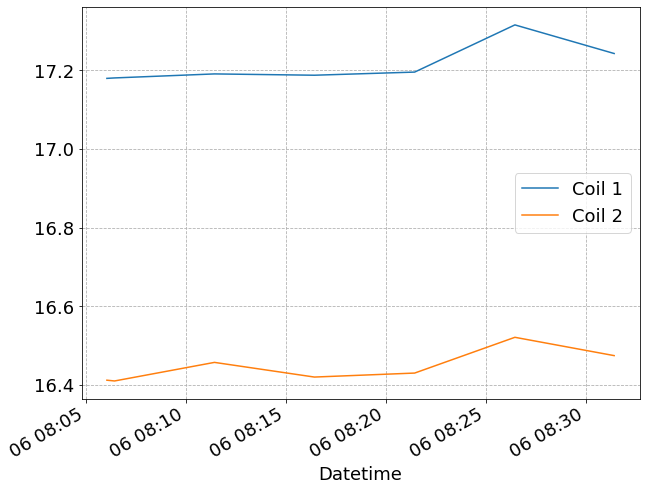

In [94]:
# coil temps
ax = df_temp[['Coil 1', 'Coil 2']].plot()
#ax = df_temp.query('Datetime > "2022-05-27 13:00"')[['Coil 1', 'Coil 2']].plot()

<AxesSubplot:label='c12ed0e7-d15a-4568-aa0f-2414f549bc05', xlabel='Datetime'>

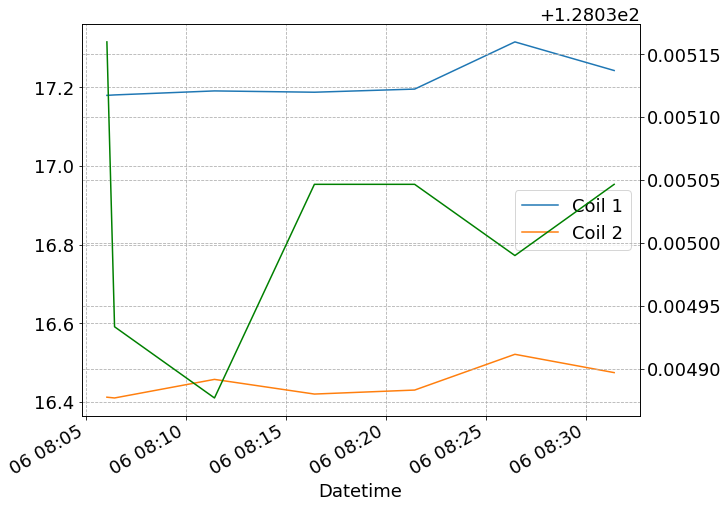

In [95]:
# coil temps, with magnet current on second y axis
ax = df_temp[['Coil 1', 'Coil 2']].plot()
ax2 = ax.twinx()
df_temp['Magnet Current [A]'].plot(ax=ax2, color='green')

In [96]:
df_temp['Magnet Current [A]']

Datetime
2022-07-06 08:06:02    128.035160
2022-07-06 08:06:25    128.034933
2022-07-06 08:11:25    128.034877
2022-07-06 08:16:25    128.035047
2022-07-06 08:21:26    128.035047
2022-07-06 08:26:27    128.034990
2022-07-06 08:31:25    128.035047
Name: Magnet Current [A], dtype: float64

In [97]:
# # current
# (abs(df_temp.query('abs(`Magnet Current [A]`) > 295')['Magnet Current [A]'])).plot()

<AxesSubplot:xlabel='Datetime'>

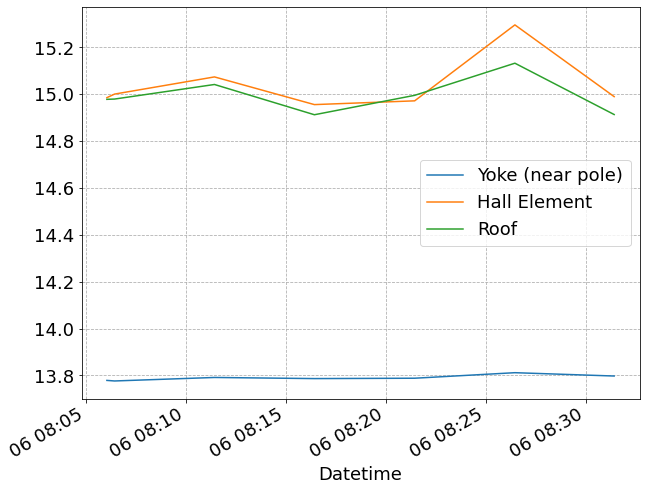

In [98]:
# yoke temp, hall probe temp
df_temp[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [99]:
for c in df_temp.columns:
    if "NW" in c:
        print(c)

NaN (NWC-R)
EvapCoil (NWC)
Return Magnet (NWC-R)
Chiller Exhaust (NW)
Supply Magnet (NWC-S)
NaN (NWC-S)


<AxesSubplot:xlabel='Datetime'>

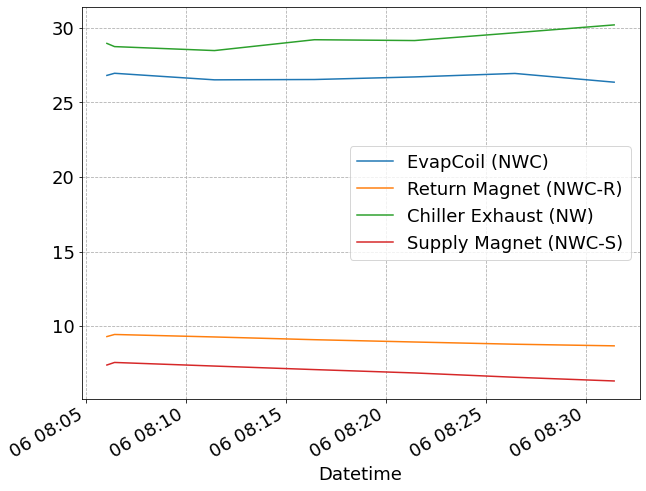

In [100]:
# chiller temps
df_temp[['EvapCoil (NWC)', 'Return Magnet (NWC-R)', 'Chiller Exhaust (NW)', 'Supply Magnet (NWC-S)']].plot()

<AxesSubplot:xlabel='Datetime'>

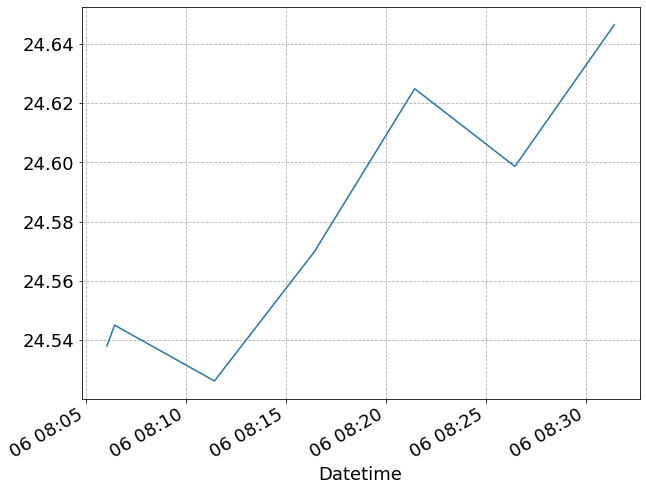

In [101]:
# ambient
df_temp['Desk Ambient'].plot()

In [102]:
df_temp.eval('dT = `Return Magnet (NWC-R)` - `Supply Magnet (NWC-S)`')['dT']

Datetime
2022-07-06 08:06:02    1.906365
2022-07-06 08:06:25    1.875102
2022-07-06 08:11:25    1.949919
2022-07-06 08:16:25    2.003061
2022-07-06 08:21:26    2.073761
2022-07-06 08:26:27    2.214830
2022-07-06 08:31:25    2.354344
Name: dT, dtype: float64

In [103]:
#m_rate_glycol = 6 * 3785.41 * 1.04 / 60 / 1e3 # gpm * density (converted to correct units)
m_rate_glycol = 6 * 3785.41 * 1.11 / 60 / 1e3 # gpm * density (converted to correct units)
Cp_glycol = 2.433 # kJ/kg/degC

In [104]:
#deltaT = 11.35
deltaT = df_temp.eval('dT = `Return Magnet (NWC-R)` - `Supply Magnet (NWC-S)`')['dT']

In [105]:
Q = m_rate_glycol * Cp_glycol * deltaT

In [106]:
Q # kW

Datetime
2022-07-06 08:06:02    1.948876
2022-07-06 08:06:25    1.916915
2022-07-06 08:11:25    1.993400
2022-07-06 08:16:25    2.047728
2022-07-06 08:21:26    2.120004
2022-07-06 08:26:27    2.264219
2022-07-06 08:31:25    2.406844
Name: dT, dtype: float64

In [107]:
m_rate_glycol*Cp_glycol

1.02229918083

- A good number to have around: ~0.958~ 1.02 * deltaT gives heat transfer from magnet to chiller.

## 128 A (05-26-22 09:41)
- Overlap region

In [ ]:
# remove first row of file
df_low = load_data(ddir_full+files[0], low_NMR=nmr_low[0]).iloc[1:].copy()
df_high = load_data(ddir_full+files[1], low_NMR=nmr_low[1]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
#df_high

In [ ]:
#df_low

In [ ]:
#df_temp

In [ ]:
I = df_low['Magnet Current [A]'].mean()
I_hi = df_high['Magnet Current [A]'].mean()

In [ ]:
I, I_hi

In [ ]:
#df_temp

In [ ]:
df_low.magnet_X_mm.unique()

In [ ]:
sf_low = df_low[np.isclose(df_low.magnet_X_mm, 34.49976562)].iloc[0]['NMR [T]']
sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-12)].iloc[0]['NMR [T]']

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]'], label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I_hi:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
(df_low['NMR [T]'].values[:int(len(df_high)/2)] - df_high['NMR [T]'].values[2::2])

In [ ]:
len(df_low['NMR [T]'].values[:len(df_high)//2] - df_high['NMR [T]'].values[2::2])

In [ ]:
len(df_low)

In [ ]:
# delta field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'].values[:len(df_high)//2], df_low['NMR [T]'].values[:len(df_high)//2] - df_high['NMR [T]'].values[2::2], label=f'I={I:0.1f} A, (Low-Field NMR - High-Field NMR)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$\Delta |B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]']/sf_low, label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I_hi:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# add 3D data and old data

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]']/sf_low, label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I_hi:0.1f} A, High-Field NMR')
# 3D
I_l = df_line['Magnet Current [A]'].mean()
ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I_l:0.1f} A, Low-Field NMR, 3D")
# old, high field nmr
I_o = df_old['Magnet Current [V]'].mean()
ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]']/sf_old, label=f"I={I_o:0.1f} A, High-Field NMR - June 2021")           

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# with scale factor
fig, ax = plt.subplots()

# ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]'], label=f"I={df_line['Magnet Current [A]'].mean():0.1f} A, Low-Field NMR")
ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={df_line['Magnet Current [A]'].mean()} A, Low-Field NMR")

ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]']/sf_old, label=f"I={df_old['Magnet Current [V]'].mean():0.1f} A, High-Field NMR - June 2021")           

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 42 A (05-26-22 11:30)
- Start of monotonic increase

In [ ]:
# remove first row of file
df_low = load_data(ddir_full+files[2], low_NMR=nmr_low[2]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_low

In [ ]:
t0 = df_low.index[0]
tf = df_low.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
I = df_low['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_low.magnet_X_mm.unique()

In [ ]:
try:
    sf_low = df_low[np.isclose(df_low.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
except:
    sf_low = df_low.iloc[-1]['NMR [T]']

In [ ]:
sf_low

In [ ]:
B_ratio = sf_low / df_low[np.isclose(df_low.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]'], label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]']/sf_low, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 56 A (05-26-22 12:18)

In [ ]:
# remove first row of file
df_low = load_data(ddir_full+files[3], low_NMR=nmr_low[3]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_low

In [ ]:
t0 = df_low.index[0]
tf = df_low.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
I = df_low['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_low.magnet_X_mm.unique()

In [ ]:
try:
    sf_low = df_low[np.isclose(df_low.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_low = df_low.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_low

In [ ]:
B_ratio = sf_low / df_low[np.isclose(df_low.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]'], label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]']/sf_low, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 80 A (05-26-22 12:39, ...)

In [ ]:
# remove first row of file
df_low = load_data(ddir_full+files[4], low_NMR=nmr_low[4]).iloc[1:].copy()
df_low2 = load_data(ddir_full+files[5], low_NMR=nmr_low[5]).iloc[1:].copy()
df_low3 = load_data(ddir_full+files[6], low_NMR=nmr_low[6]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_low3

In [ ]:
#df_low

In [ ]:
t0 = df_low.index[0]
# tf = df_low.index[-1]
# tf = df_low2.index[-1]
tf = df_low3.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
df_temp_['Yoke (near pole)'].describe()

In [ ]:
df_temp_['Hall Element'].describe()

In [ ]:
I = df_low['Magnet Current [A]'].mean()
I2 = df_low2['Magnet Current [A]'].mean()
I3 = df_low3['Magnet Current [A]'].mean()

In [ ]:
I, I2, I3

In [ ]:
df_low.magnet_X_mm.unique()

In [ ]:
try:
    sf_low = df_low[np.isclose(df_low.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_low = df_low.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_low2 = df_low2[np.isclose(df_low2.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe (2)")
except:
    sf_low2 = df_low2.iloc[-1]['NMR [T]']
    print("No data at Hall probe! (2)")
try:
    sf_low3 = df_low3[np.isclose(df_low3.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe (3)")
except:
    sf_low3 = df_low3.iloc[-1]['NMR [T]']
    print("No data at Hall probe! (3)")

In [ ]:
sf_low, sf_low2, sf_low3

In [ ]:
B_ratio = sf_low / df_low[np.isclose(df_low.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio2 = sf_low2 / df_low2[np.isclose(df_low2.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio3 = sf_low3 / df_low3[np.isclose(df_low3.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio, B_ratio2, B_ratio3

In [ ]:
B_ratio-B_ratio2, B_ratio-B_ratio3, B_ratio2-B_ratio3

In [ ]:
Brs = np.array([B_ratio,B_ratio2,B_ratio3])

In [ ]:
np.std(Brs), np.std(Brs, ddof=1)

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]'], label=f'I={I:0.1f} A, Low-Field NMR\nTrial 1\n(0 min from current changed)')
ax.scatter(df_low2['magnet_X_mm'], df_low2['NMR [T]'], label=f'I={I2:0.1f} A, Low-Field NMR\nTrial 2\n(30 min from current changed)')
ax.scatter(df_low3['magnet_X_mm'], df_low3['NMR [T]'], label=f'I={I3:0.1f} A, Low-Field NMR\nTrial 3\n(60 min from current changed)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]']/sf_low, label=f'I={I:0.1f} A, Low-Field NMR\nTrial 1\n(0 min from current changed)')
ax.scatter(df_low2['magnet_X_mm'], df_low2['NMR [T]']/sf_low2, label=f'I={I2:0.1f} A, Low-Field NMR\nTrial 2\n(30 min from current changed)')
ax.scatter(df_low3['magnet_X_mm'], df_low3['NMR [T]']/sf_low3, label=f'I={I3:0.1f} A, Low-Field NMR\nTrial 3\n(60 min from current changed)')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 104 A (05-26-22 14:06)

In [ ]:
# remove first row of file
df_low = load_data(ddir_full+files[7], low_NMR=nmr_low[7]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_low

In [ ]:
t0 = df_low.index[0]
tf = df_low.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
I = df_low['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_low.magnet_X_mm.unique()

In [ ]:
try:
    sf_low = df_low[np.isclose(df_low.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_low = df_low.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_low

In [ ]:
B_ratio = sf_low / df_low[np.isclose(df_low.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]'], label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]']/sf_low, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 128 A (05-26-22 14:42)
- Overlap region
- Low and high NMR
- Include results from this morning

In [ ]:
# remove first row of file
df_low = load_data(ddir_full+files[0], low_NMR=nmr_low[0]).iloc[1:].copy()
df_high = load_data(ddir_full+files[1], low_NMR=nmr_low[1]).iloc[1:].copy()
df_low2 = load_data(ddir_full+files[8], low_NMR=nmr_low[8]).iloc[1:].copy()
df_high2 = load_data(ddir_full+files[9], low_NMR=nmr_low[9]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high2.head()

In [ ]:
t0 = df_low.index[0]
# tf = df_low2.index[-1]
tf = df_high2.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
#df_temp_

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
I = df_low['Magnet Current [A]'].mean()
I_hi = df_high['Magnet Current [A]'].mean()
I2 = df_low2['Magnet Current [A]'].mean()
I_hi2 = df_high2['Magnet Current [A]'].mean()

In [ ]:
I, I_hi, I2, I_hi2

In [ ]:
df_low.magnet_X_mm.unique()

In [ ]:
try:
    sf_low = df_low[np.isclose(df_low.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_low = df_low.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_low2 = df_low2[np.isclose(df_low2.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_low2 = df_low2.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high2 = df_high2[np.isclose(df_high2.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high2 = df_high2.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_low, sf_high, sf_low2, sf_high2

In [ ]:
B_ratio = sf_low / df_low[np.isclose(df_low.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio_high = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio2 = sf_low2 / df_low2[np.isclose(df_low2.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio_high2 = sf_high2 / df_high2[np.isclose(df_high2.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio, B_ratio_high, B_ratio2, B_ratio_high2

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]'], label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I_hi:0.1f} A, High-Field NMR')
ax.scatter(df_low2['magnet_X_mm'], df_low2['NMR [T]'], label=f'I={I2:0.1f} A, Low-Field NMR (afternoon)')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]'], label=f'I={I_hi2:0.1f} A, High-Field NMR (afternoon)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]']/sf_low, label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I_hi:0.1f} A, High-Field NMR')
ax.scatter(df_low2['magnet_X_mm'], df_low2['NMR [T]']/sf_low2, label=f'I={I2:0.1f} A, Low-Field NMR (afternoon)')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]']/sf_high2, label=f'I={I_hi2:0.1f} A, High-Field NMR (afternoon)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# add 3D data and old data

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_low['magnet_X_mm'], df_low['NMR [T]']/sf_low, label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I_hi:0.1f} A, High-Field NMR')
ax.scatter(df_low2['magnet_X_mm'], df_low2['NMR [T]']/sf_low2, label=f'I={I2:0.1f} A, Low-Field NMR (afternoon)')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]']/sf_high2, label=f'I={I_hi2:0.1f} A, High-Field NMR (afternoon)')
# 3D
I_l = df_line['Magnet Current [A]'].mean()
ax.scatter(df_line['magnet_X_mm'], df_line['NMR [T]']/sf, label=f"I={I_l:0.1f} A, Low-Field NMR, 3D")
# old, high field nmr
I_o = df_old['Magnet Current [V]'].mean()
ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]']/sf_old, label=f"I={I_o:0.1f} A, High-Field NMR - June 2021")           

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 144 A (05-26-22 15:33)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[10], low_NMR=nmr_low[10]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
df_temp[['Coil 1', 'Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 160 A (05-26-22 16:04)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[11], low_NMR=nmr_low[11]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 176 A (05-26-22 16:33)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[12], low_NMR=nmr_low[12]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 192 A (05-26-22 17:00)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[13], low_NMR=nmr_low[13]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
from Zaber_Magnet_Convert_Jun21 import zaber_ADC_to_magnet_mm as zaber_ADC_to_magnet_mm_Jun21
old_files = ['2021-06-15 073806.txt', '2021-06-16 074548.txt']
df_old = load_data(ddir+old_files[0], low_NMR=False)
df_old2 = load_data(ddir+old_files[1], low_NMR=False)
df_old = df_old.query("191 < `Magnet Current [V]` < 193").copy()
df_old2 = df_old2.query("191 < `Magnet Current [V]` < 193").copy()
df_old3 = df_old2.query('Datetime > "2021-06-16 11:10"')
df_old2 = df_old2.query('Datetime < "2021-06-16 11:10"')
for i in ['X', 'Y', 'Z']:
    #df[f'magnet_{i}_mm'] = ADC_to_mm(df[f'Zaber_Meas_Encoder_{i}'].values, coord=i)
    df_old[f'magnet_{i}_mm'] = zaber_ADC_to_magnet_mm_Jun21(df_old[f'Zaber_Meas_Encoder_{i}'].values, coord=i, low_NMR=False)
    df_old2[f'magnet_{i}_mm'] = zaber_ADC_to_magnet_mm_Jun21(df_old2[f'Zaber_Meas_Encoder_{i}'].values, coord=i, low_NMR=False)
    df_old3[f'magnet_{i}_mm'] = zaber_ADC_to_magnet_mm_Jun21(df_old3[f'Zaber_Meas_Encoder_{i}'].values, coord=i, low_NMR=False)

In [ ]:
I_old = df_old['Magnet Current [V]'].mean()
I_old2 = df_old2['Magnet Current [V]'].mean()
I_old3 = df_old3['Magnet Current [V]'].mean()
I_old, I_old2, I_old3

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
df_old.magnet_X_mm.unique()

In [ ]:
sf_old = df_old[np.isclose(df_old.magnet_X_mm, 34.7, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_old2 = df_old2[np.isclose(df_old2.magnet_X_mm, 34.7, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
sf_old3 = df_old3[np.isclose(df_old3.magnet_X_mm, 34.7, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']

In [ ]:
sf_high, sf_old, sf_old2, sf_old3

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio_old = sf_old / df_old[np.isclose(df_old.magnet_X_mm, 12.97, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
B_ratio_old2 = sf_old2 / df_old2[np.isclose(df_old2.magnet_X_mm, 12.97, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']
B_ratio_old3 = sf_old3 / df_old3[np.isclose(df_old3.magnet_X_mm, 12.97, atol=1e-1, rtol=1e-2)].iloc[0]['NMR [T]']

In [ ]:
B_ratio, B_ratio_old, B_ratio_old2, B_ratio_old3

In [ ]:
np.std([B_ratio, B_ratio_old, B_ratio_old2, B_ratio_old3], ddof=1), np.std([B_ratio, B_ratio_old, B_ratio_old2, B_ratio_old3], ddof=0)

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]'], label=f'I={I_old:0.1f} A, High-Field NMR, 2021-06-15')
ax.scatter(df_old2['magnet_X_mm'], df_old2['NMR [T]'], label=f'I={I_old2:0.1f} A, High-Field NMR, 2021-06-16')
ax.scatter(df_old3['magnet_X_mm'], df_old3['NMR [T]'], label=f'I={I_old3:0.1f} A, High-Field NMR, 2021-06-16 (2)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]']/sf_old, label=f'I={I_old:0.1f} A, High-Field NMR, 2021-06-15')
ax.scatter(df_old2['magnet_X_mm'], df_old2['NMR [T]']/sf_old2, label=f'I={I_old2:0.1f} A, High-Field NMR, 2021-06-16')
ax.scatter(df_old3['magnet_X_mm'], df_old3['NMR [T]']/sf_old3, label=f'I={I_old3:0.1f} A, High-Field NMR, 2021-06-16 (2)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

- **FIXME! ADD IN PREVIOUS 192 A RESULTS**
- Did previous 1D, should also add previous 3D (with temperature corrections)

## 208 A (05-26-22 17:30)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[14], low_NMR=nmr_low[14]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 224 A (05-26-22 17:59)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[15], low_NMR=nmr_low[15]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 240 A (05-26-22 18:28)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[16], low_NMR=nmr_low[16]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 256 A (05-26-22 19:01)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[17], low_NMR=nmr_low[17]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 272 A (05-26-22 19:30)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[18], low_NMR=nmr_low[18]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 288 A (05-26-22 20:00, and 05-27-22 after long scan)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[19], low_NMR=nmr_low[19]).iloc[1:].copy()
df_high2 = load_data(ddir_full+files[20], low_NMR=nmr_low[20]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high2

In [ ]:
t0 = df_high.index[0]
tf = df_high2.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
I = df_high['Magnet Current [A]'].mean()
I2 = df_high2['Magnet Current [A]'].mean()

In [ ]:
I, I2

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high2 = df_high2[np.isclose(df_high2.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high2 = df_high2.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high, sf_high2

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio2 = sf_high2 / df_high2[np.isclose(df_high2.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio, B_ratio2

In [ ]:
B_ratio2 - B_ratio

In [ ]:
## field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]'], label=f'I={I2:0.1f} A, High-Field NMR (2)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]']/sf_high2, label=f'I={I2:0.1f} A, High-Field NMR (2)')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## $\pm$300 A (05-27-22 08:37, 09:08)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[21], low_NMR=nmr_low[21]).iloc[1:].copy()
df_high2 = load_data(ddir_full+files[22], low_NMR=nmr_low[22]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high2

In [ ]:
t0 = df_high.index[0]
tf = df_high2.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
I = df_high['Magnet Current [A]'].mean()
I2 = df_high2['Magnet Current [A]'].mean()

In [ ]:
I, I2

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high2 = df_high2[np.isclose(df_high2.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high2 = df_high2.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high, sf_high2

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio2 = sf_high2 / df_high2[np.isclose(df_high2.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio, B_ratio2

In [ ]:
B_ratio2 - B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]'], label=f'I={I2:0.1f} A, High-Field NMR (2)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]']/sf_high2, label=f'I={I2:0.1f} A, High-Field NMR (2)')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## $\pm$42 A (05-27-22 09:41, ...)
- +42
- -42
- -42
- +42 -- better degaussing started here!
- +42
- +42 (45 deg C) -- 27.5 deg C actual
- +42 (45 deg C) -- 28.8 deg C actual
- -42 (45 deg C) -- 30.3 deg C actual

- Repeating since we were at 940k, so Yoke is actively cooling very quickly.

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[23], low_NMR=nmr_low[23]).iloc[1:].copy()
df_high2 = load_data(ddir_full+files[24], low_NMR=nmr_low[24]).iloc[1:].copy()
df_high3 = load_data(ddir_full+files[25], low_NMR=nmr_low[25]).iloc[1:].copy()
df_high4 = load_data(ddir_full+files[26], low_NMR=nmr_low[26]).iloc[1:].copy()
df_high5 = load_data(ddir_full+files[27], low_NMR=nmr_low[27]).iloc[1:].copy()
df_high6 = load_data(ddir_full+files[28], low_NMR=nmr_low[28]).iloc[1:].copy()
df_high7 = load_data(ddir_full+files[29], low_NMR=nmr_low[29]).iloc[1:].copy()
df_high8 = load_data(ddir_full+files[30], low_NMR=nmr_low[30]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[0], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high8

In [ ]:
t0 = df_high.index[0]
tf = df_high7.index[-1]
# tf = df_high8.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
# chiller temps
df_temp[['EvapCoil (NWC)', 'Return Magnet (NWC-R)', 'Chiller Exhaust (NW)', 'Supply Magnet (NWC-S)']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
I = df_high['Magnet Current [A]'].mean()
I2 = df_high2['Magnet Current [A]'].mean()
I3 = df_high3['Magnet Current [A]'].mean()
I4 = df_high4['Magnet Current [A]'].mean()
I5 = df_high5['Magnet Current [A]'].mean()
I6 = df_high6['Magnet Current [A]'].mean()
I7 = df_high7['Magnet Current [A]'].mean()
I8 = df_high8['Magnet Current [A]'].mean()

In [ ]:
I, I2, I3, I4, I5, I6, I7, I8

In [ ]:
df_high8.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high2 = df_high2[np.isclose(df_high2.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high2 = df_high2.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high3 = df_high3[np.isclose(df_high3.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high3 = df_high3.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high4 = df_high4[np.isclose(df_high4.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high4 = df_high4.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high5 = df_high5[np.isclose(df_high5.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high5 = df_high5.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high6 = df_high6[np.isclose(df_high6.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high6 = df_high6.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high7 = df_high7[np.isclose(df_high7.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high7 = df_high7.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_high8 = df_high8[np.isclose(df_high8.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high8 = df_high8.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high, sf_high2, sf_high3, sf_high4, sf_high5, sf_high6, sf_high7, sf_high8

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio2 = sf_high2 / df_high2[np.isclose(df_high2.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio3 = sf_high3 / df_high3[np.isclose(df_high3.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio4 = sf_high4 / df_high4[np.isclose(df_high4.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio5 = sf_high5 / df_high5[np.isclose(df_high5.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio6 = sf_high6 / df_high6[np.isclose(df_high6.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio7 = sf_high7 / df_high7[np.isclose(df_high7.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio8 = sf_high8 / df_high8[np.isclose(df_high8.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio, B_ratio2, B_ratio3, B_ratio4, B_ratio5, B_ratio6, B_ratio7, B_ratio8

In [ ]:
B_ratio2 - B_ratio, B_ratio2 - B_ratio3, B_ratio-B_ratio3, B_ratio2 - B_ratio4, B_ratio-B_ratio4, B_ratio3-B_ratio4

In [ ]:
for B_r in [B_ratio, B_ratio2, B_ratio3, B_ratio4,]:
    print(B_ratio5-B_r)

In [ ]:
for B_r in [B_ratio, B_ratio2, B_ratio3, B_ratio4, B_ratio5]:
    print(B_ratio6-B_r)

In [ ]:
for B_r in [B_ratio, B_ratio2, B_ratio3, B_ratio4, B_ratio5, B_ratio6]:
    print(B_ratio7-B_r)

In [ ]:
for B_r in [B_ratio, B_ratio2, B_ratio3, B_ratio4, B_ratio5, B_ratio6, B_ratio7]:
    print(B_ratio8-B_r)

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]'], label=f'I={I2:0.1f} A, High-Field NMR (2)')
ax.scatter(df_high3['magnet_X_mm'], df_high3['NMR [T]'], label=f'I={I3:0.1f} A, High-Field NMR (3)')
ax.scatter(df_high4['magnet_X_mm'], df_high4['NMR [T]'], label=f'I={I4:0.1f} A, High-Field NMR (4)')
ax.scatter(df_high5['magnet_X_mm'], df_high5['NMR [T]'], label=f'I={I5:0.1f} A, High-Field NMR (5)')
ax.scatter(df_high6['magnet_X_mm'], df_high6['NMR [T]'], label=f'I={I6:0.1f} A, High-Field NMR, 45 deg C (6)')
ax.scatter(df_high7['magnet_X_mm'], df_high7['NMR [T]'], label=f'I={I7:0.1f} A, High-Field NMR, 45 deg C (7)')
ax.scatter(df_high8['magnet_X_mm'], df_high8['NMR [T]'], label=f'I={I8:0.1f} A, High-Field NMR, 45 deg C (8)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high2['magnet_X_mm'], df_high2['NMR [T]']/sf_high2, label=f'I={I2:0.1f} A, High-Field NMR (2)')
ax.scatter(df_high3['magnet_X_mm'], df_high3['NMR [T]']/sf_high3, label=f'I={I3:0.1f} A, High-Field NMR (3)')
ax.scatter(df_high4['magnet_X_mm'], df_high4['NMR [T]']/sf_high4, label=f'I={I4:0.1f} A, High-Field NMR (4)')
ax.scatter(df_high5['magnet_X_mm'], df_high5['NMR [T]']/sf_high5, label=f'I={I5:0.1f} A, High-Field NMR (5)')
ax.scatter(df_high6['magnet_X_mm'], df_high6['NMR [T]']/sf_high6, label=f'I={I6:0.1f} A, High-Field NMR, 45 deg C (6)')
ax.scatter(df_high7['magnet_X_mm'], df_high7['NMR [T]']/sf_high7, label=f'I={I7:0.1f} A, High-Field NMR, 45 deg C (7)')
ax.scatter(df_high8['magnet_X_mm'], df_high8['NMR [T]']/sf_high8, label=f'I={I8:0.1f} A, High-Field NMR, 45 deg C (8)')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

# Add Scans that I missed here.

## 56 A (06-01-22 09:41, repeated 4 times)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[36], low_NMR=nmr_low[36]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[37], low_NMR=nmr_low[37]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[1], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
df_high

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlim([8, 13])
ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 80 A (06-01-22 12:49)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[37], low_NMR=nmr_low[37]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[38], low_NMR=nmr_low[38]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[1], low_NMR=True) # note low NMR changes based on time

df_old = load_data(ddir_full+files[6], low_NMR=nmr_low[6]).iloc[1:].copy()

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()
I_old = df_old['Magnet Current [A]'].mean()

In [ ]:
I, I_old

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_old = df_old[np.isclose(df_old.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_old = df_old.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high, sf_old

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio_old = sf_old / df_old[np.isclose(df_old.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio, B_ratio_old

In [ ]:
B_ratio - B_ratio_old

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, Low-Field NMR (06-01-22)')
ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]'], label=f'I={I_old:0.1f} A, Low-Field NMR (05-26-22)')
# ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high, df_old]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
#df_high.sf, df_old.sf

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, Low-Field NMR (06-01-22)')
ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]']/sf_old, label=f'I={I_old:0.1f} A, Low-Field NMR (05-26-22)')
# ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 104 A (06-01-22 13:15)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[38], low_NMR=nmr_low[38]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[39], low_NMR=nmr_low[39]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[1], low_NMR=True) # note low NMR changes based on time

df_old = load_data(ddir_full+files[7], low_NMR=nmr_low[7]).iloc[1:].copy()

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()
I_old = df_old['Magnet Current [A]'].mean()

In [ ]:
I, I_old

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")
try:
    sf_old = df_old[np.isclose(df_old.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_old = df_old.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high, sf_old

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
B_ratio_old = sf_old / df_old[np.isclose(df_old.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio, B_ratio_old

In [ ]:
B_ratio - B_ratio_old

In [ ]:
# field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, Low-Field NMR (06-01-22)')
ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]'], label=f'I={I_old:0.1f} A, Low-Field NMR (05-26-22)')
# ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high, df_old]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
#df_high.sf, df_old.sf

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, Low-Field NMR (06-01-22)')
ax.scatter(df_old['magnet_X_mm'], df_old['NMR [T]']/sf_old, label=f'I={I_old:0.1f} A, Low-Field NMR (05-26-22)')
# ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

## 42 A (06-01-22 14:28, repeated 81 times)

In [ ]:
# 3D results -- FIX ME! DO NOT HARD CODE!
# 18 deg C
Br_18C = 0.999869171648126
Br_45C = 0.9998676399517697

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[39], low_NMR=nmr_low[39]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[40], low_NMR=nmr_low[40]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[1], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
nl = True
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
df_high

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 7
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
sc = ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')
cb = fig.colorbar(sc, label='Scan Index')

# ax.set_xlim([12, 13])
# ax.set_ylim([1.00012, 1.00015])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
#rmin = 15
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
    Is.append(abs(df_["Magnet Current [A]"].mean()))
    Brs.append(df_.sf / df_['NMR [T]'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# apply temperature correction

In [ ]:
# redo delta time from first file
df_high['seconds_delta'] = (df_high.index - df_temp.index[0]).total_seconds()
df_high['hours_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/60**2
df_high['days_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/(24*60**2)
# temperature correction
B_corr = temp_correct(df_high, df_temp, tempcol="Yoke (near pole)")
# B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
df_high.loc[:, 'B_corr'] = B_corr
df_high.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
# recalculate scale factor
# find field value at Hall probe location
sf_corr_list = []
for r in df_high.run:
    try:
        sf = df_high[np.isclose(df_high.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_high.run == r)].iloc[0]['B_corr']
    except:
        sf = df_high[(df_high.run == r)].iloc[-1]['B_corr']
    sf_corr_list.append(sf)
df_high['sf_corr'] = sf_corr_list

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['B_corr']/df_high['sf_corr'], c=range(len(df_high)), label=f'I={I:0.1f} A, Low-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

fig.suptitle('Temperature Correction Applied')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 5
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/df_['sf_corr'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

fig.suptitle("Temperature Correction Applied")

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
# rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf_corr / df_['B_corr'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# see results from 06-06-2022. Difference is ~6e-7
(0.9998686842586297, 1.2655729626129575e-06)

In [ ]:
# see 81 scans above
(0.9998693586096042, 9.44955512736464e-07)

In [ ]:
np.mean(Brs) - 0.9998693586096042

In [ ]:
t0 = df_high.iloc[0].Time
tf = df_high.iloc[-1].Time

In [ ]:
fig, ax = plt.subplots()

label_temp = r'$\mu = {0:.7f}$'+ '\n' + 'std' + r'$= {1:.1E}$' + '\n' +  'Integral: {2}'

n, bins, patches = ax.hist(Brs, bins=15, histtype='step', label=label_temp.format(np.mean(Brs), np.std(Brs, ddof=1), len(Brs)))

nmax = np.max(n)
ax.plot([Br_18C, Br_18C], [0, nmax], 'r--', label='3D Scan, 18 deg C\n' + r'$B_{Hall}/B_{NMR} = $' + f'{Br_18C:0.7f}')
ax.plot([Br_45C, Br_45C], [0, nmax], 'g-.', label='3D Scan, 45 deg C\n' + r'$B_{Hall}/B_{NMR} = $' + f'{Br_45C:0.7f}')

xme = np.mean(Brs)
xmi = np.min(Brs)
xma = np.max(Brs)
xli = np.max(np.abs([xme-xmi, xma-xme])) * 1.1

ax.set_xlim([xme-xli, xme+xli])

# ax.set_xlabel(r'$\frac{B_{Hall}}{B_{NMR}}$')
ax.set_xlabel(r'$B_{Hall}/B_{NMR}$')
ax.set_ylabel('Number of Scans')
fig.suptitle(f'{I:0.1f} A, Temperature Fixed (18 deg C)\n{t0} to {tf}')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [ ]:
len(df_high.run.unique())

In [ ]:
(169-154)*20 / 60

## 42 A (06-03-22 14:16, repeated 169 times)
- Started right as temperature changed from 18 deg C to 45 deg C.

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[40], low_NMR=nmr_low[40]).iloc[2:].copy()
# df_high = load_data(ddir_full+files[41], low_NMR=nmr_low[41]).iloc[2:].copy()
df_temp = load_data(ddir_full+tempfiles[1], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
nl = True
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
df_high

In [ ]:
df_high.run.unique()

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf / df_['NMR [T]'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# see 81 scans above
# (0.9998693586096042, 9.44955512736464e-07)
(0.9998689515384824, 9.833103699057721e-07)

In [ ]:
np.mean(Brs) - 0.9998693586096042

In [ ]:
np.mean(Brs) - 0.9998689515384824

In [ ]:
# apply temperature correction

In [ ]:
# redo delta time from first file
df_high['seconds_delta'] = (df_high.index - df_temp.index[0]).total_seconds()
df_high['hours_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/60**2
df_high['days_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/(24*60**2)
# temperature correction
B_corr = temp_correct(df_high, df_temp, tempcol="Yoke (near pole)")
# B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
df_high.loc[:, 'B_corr'] = B_corr
df_high.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
# recalculate scale factor
# find field value at Hall probe location
sf_corr_list = []
for r in df_high.run:
    try:
        sf = df_high[np.isclose(df_high.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_high.run == r)].iloc[0]['B_corr']
    except:
        sf = df_high[(df_high.run == r)].iloc[-1]['B_corr']
    sf_corr_list.append(sf)
df_high['sf_corr'] = sf_corr_list

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['B_corr']/df_high['sf_corr'], c=range(len(df_high)), label=f'I={I:0.1f} A, Low-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

fig.suptitle('Temperature Correction Applied')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/df_['sf_corr'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

fig.suptitle("Temperature Correction Applied")

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf_corr / df_['B_corr'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# see results from 06-06-2022. Difference is ~6e-7
(0.9998686842586297, 1.2655729626129575e-06)

In [ ]:
# see 81 scans above
# (0.9998693586096042, 9.44955512736464e-07)
(0.9998689515384824, 9.833103699057721e-07)

In [ ]:
np.mean(Brs) - 0.9998693586096042

In [ ]:
np.mean(Brs) - 0.9998689515384824

In [ ]:
t0 = df_high.iloc[0].Time
tf = df_high.iloc[-1].Time

In [ ]:
fig, ax = plt.subplots()

label_temp = r'$\mu = {0:.7f}$'+ '\n' + 'std' + r'$= {1:.1E}$' + '\n' +  'Integral: {2}'

n, bins, patches = ax.hist(Brs, bins=15, histtype='step', label=label_temp.format(np.mean(Brs), np.std(Brs, ddof=1), len(Brs)))

nmax = np.max(n)
ax.plot([Br_18C, Br_18C], [0, nmax], 'r--', label='3D Scan, 18 deg C\n' + r'$B_{Hall}/B_{NMR} = $' + f'{Br_18C:0.7f}')
ax.plot([Br_45C, Br_45C], [0, nmax], 'g-.', label='3D Scan, 45 deg C\n' + r'$B_{Hall}/B_{NMR} = $' + f'{Br_45C:0.7f}')

xme = np.mean(Brs)
xmi = np.min(Brs)
xma = np.max(Brs)
xli = np.max(np.abs([xme-xmi, xma-xme])) * 1.1

ax.set_xlim([xme-xli, xme+xli])

# ax.set_xlabel(r'$\frac{B_{Hall}}{B_{NMR}}$')
ax.set_xlabel(r'$B_{Hall}/B_{NMR}$')
ax.set_ylabel('Number of Scans')
fig.suptitle(f'{I:0.1f} A, Temperature Ramped from 18-45 deg C\n{t0} to {tf}')
# ax.legend();
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [ ]:
len(df_high.run.unique())

In [ ]:
(169-154)*20 / 60

## 42 A (06-06-22 11:59, repeated 4 times)
- Enclosure cooled down to 18 deg C again. Current setting did not change since Wednesday. Want to confirm still getting the same number (after waiting for equilibrium)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[41], low_NMR=nmr_low[41]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[42], low_NMR=nmr_low[42]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[2], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
nl = True
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
df_high

In [ ]:
df_high.run.unique()

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf / df_['NMR [T]'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# apply temperature correction

In [ ]:
# redo delta time from first file
df_high['seconds_delta'] = (df_high.index - df_temp.index[0]).total_seconds()
df_high['hours_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/60**2
df_high['days_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/(24*60**2)
# temperature correction
B_corr = temp_correct(df_high, df_temp, tempcol="Yoke (near pole)")
# B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
df_high.loc[:, 'B_corr'] = B_corr
df_high.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
# recalculate scale factor
# find field value at Hall probe location
sf_corr_list = []
for r in df_high.run:
    try:
        sf = df_high[np.isclose(df_high.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_high.run == r)].iloc[0]['B_corr']
    except:
        sf = df_high[(df_high.run == r)].iloc[-1]['B_corr']
    sf_corr_list.append(sf)
df_high['sf_corr'] = sf_corr_list

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['B_corr']/df_high['sf_corr'], c=range(len(df_high)), label=f'I={I:0.1f} A, Low-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

fig.suptitle('Temperature Correction Applied')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/df_['sf_corr'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

fig.suptitle("Temperature Correction Applied")

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf_corr / df_['B_corr'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
t0 = df_high.iloc[0].Time
tf = df_high.iloc[-1].Time

In [ ]:
fig, ax = plt.subplots()

label_temp = r'$\mu = {0:.3E}$'+ '\n' + 'std' + r'$= {1:.3E}$' + '\n' +  'Integral: {2}'

ax.hist(Brs, bins=15, histtype='step', label=label_temp.format(np.mean(Brs), np.std(Brs, ddof=1), len(Brs)))

# ax.set_xlabel(r'$\frac{B_{Hall}}{B_{NMR}}$')
ax.set_xlabel(r'$B_{Hall}/B_{NMR}$')
ax.set_ylabel('Number of Scans')
fig.suptitle(f'{I:0.1f} A, Temperature Ramped from 18-45 deg C\n{t0} to {tf}')
ax.legend();

In [ ]:
len(df_high.run.unique())

In [ ]:
(169-154)*20 / 60

## 56 A (06-06-22 14:59, repeated 169 times)
- Enclosure cooled down to 18 deg C again. Current setting changed using standard degaussing. Look at any time dependence.

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[42], low_NMR=nmr_low[42]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[43], low_NMR=nmr_low[43]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[2], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
nl = True
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
df_high

In [ ]:
df_high.run.unique()

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf / df_['NMR [T]'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# apply temperature correction

In [ ]:
# redo delta time from first file
df_high['seconds_delta'] = (df_high.index - df_temp.index[0]).total_seconds()
df_high['hours_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/60**2
df_high['days_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/(24*60**2)
# temperature correction
B_corr = temp_correct(df_high, df_temp, tempcol="Yoke (near pole)")
# B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
df_high.loc[:, 'B_corr'] = B_corr
df_high.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
# recalculate scale factor
# find field value at Hall probe location
sf_corr_list = []
for r in df_high.run:
    try:
        sf = df_high[np.isclose(df_high.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_high.run == r)].iloc[0]['B_corr']
    except:
        sf = df_high[(df_high.run == r)].iloc[-1]['B_corr']
    sf_corr_list.append(sf)
df_high['sf_corr'] = sf_corr_list

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['B_corr']/df_high['sf_corr'], c=range(len(df_high)), label=f'I={I:0.1f} A, Low-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

fig.suptitle('Temperature Correction Applied')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/df_['sf_corr'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

fig.suptitle("Temperature Correction Applied")

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf_corr / df_['B_corr'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
len(Brs)

In [ ]:
t0 = df_high.iloc[0].Time
tf = df_high.iloc[-1].Time

In [ ]:
fig, ax = plt.subplots()

label_temp = r'$\mu = {0:.3E}$'+ '\n' + 'std' + r'$= {1:.3E}$' + '\n' +  'Integral: {2}'

ax.hist(Brs, bins=15, histtype='step', label=label_temp.format(np.mean(Brs), np.std(Brs, ddof=1), len(Brs)))

# ax.set_xlabel(r'$\frac{B_{Hall}}{B_{NMR}}$')
ax.set_xlabel(r'$B_{Hall}/B_{NMR}$')
ax.set_ylabel('Number of Scans')
fig.suptitle(f'{I:0.1f} A, Temperature Ramped from 18-45 deg C\n{t0} to {tf}')
ax.legend();

In [ ]:
len(df_high.run.unique())

In [ ]:
(169-154)*20 / 60

## 56 A (06-07-22 09:59, repeated 25 times)
- Enclosure temp cycled, 45 deg C for 6 hours, 15 deg C since then (4am 06-07)

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[43], low_NMR=nmr_low[43]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[44], low_NMR=nmr_low[44]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[3], low_NMR=True) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
nl = True
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
df_high

In [ ]:
df_high.run.unique()

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf / df_['NMR [T]'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# apply temperature correction

In [ ]:
# redo delta time from first file
df_high['seconds_delta'] = (df_high.index - df_temp.index[0]).total_seconds()
df_high['hours_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/60**2
df_high['days_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/(24*60**2)
# temperature correction
B_corr = temp_correct(df_high, df_temp, tempcol="Yoke (near pole)")
# B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
df_high.loc[:, 'B_corr'] = B_corr
df_high.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
# recalculate scale factor
# find field value at Hall probe location
sf_corr_list = []
for r in df_high.run:
    try:
        sf = df_high[np.isclose(df_high.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_high.run == r)].iloc[0]['B_corr']
    except:
        sf = df_high[(df_high.run == r)].iloc[-1]['B_corr']
    sf_corr_list.append(sf)
df_high['sf_corr'] = sf_corr_list

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['B_corr']/df_high['sf_corr'], c=range(len(df_high)), label=f'I={I:0.1f} A, Low-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

fig.suptitle('Temperature Correction Applied')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/df_['sf_corr'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00012, 1.00015])

fig.suptitle("Temperature Correction Applied")

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf_corr / df_['B_corr'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# from 169 scans above (06-06-2022)
(0.9998739971027483, 5.402339120142033e-07)

In [ ]:
np.mean(Brs) - 0.9998739971027483

In [ ]:
len(Brs)

In [ ]:
t0 = df_high.iloc[0].Time
tf = df_high.iloc[-1].Time

In [ ]:
fig, ax = plt.subplots()

label_temp = r'$\mu = {0:.7f}$'+ '\n' + 'std' + r'$= {1:.1E}$' + '\n' +  'Integral: {2}'

n, bins, patches = ax.hist(Brs, bins=5, histtype='step', label=label_temp.format(np.mean(Brs), np.std(Brs, ddof=1), len(Brs)))

xme = np.mean(Brs)
xmi = np.min(Brs)
xma = np.max(Brs)
xli = np.max(np.abs([xme-xmi, xma-xme])) * 1.1

ax.set_xlim([xme-xli, xme+xli])

# ax.set_xlabel(r'$\frac{B_{Hall}}{B_{NMR}}$')
ax.set_xlabel(r'$B_{Hall}/B_{NMR}$')
ax.set_ylabel('Number of Scans')
fig.suptitle(f'{I:0.1f} A, Temperature Fixed (15 deg C)\n{t0} to {tf}')
ax.legend();
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [ ]:
len(df_high.run.unique())

In [ ]:
(169-154)*20 / 60

## 272 A (06-07-22 17:38, repeated 169 times)
- Enclosure temp 15 deg C
- Current was changed at 14:29 but I did not have time to start the scans before FMS

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[44], low_NMR=nmr_low[44]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[45], low_NMR=nmr_low[45]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[3], low_NMR=False) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
nl = True
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
df_high

In [ ]:
df_high.run.unique()

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00055, 1.00065])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
len(df_high.run.unique())

In [ ]:
# cut on run number
rmin = 0
# last run incomplete
rmax = 88
df_cut = df_high.query(f'(run >= {rmin}) & (run <= {rmax})')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf / df_['NMR [T]'])

In [ ]:
len(Brs)

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# apply temperature correction

In [ ]:
# redo delta time from first file
df_high['seconds_delta'] = (df_high.index - df_temp.index[0]).total_seconds()
df_high['hours_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/60**2
df_high['days_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/(24*60**2)
# temperature correction
B_corr = temp_correct(df_high, df_temp, tempcol="Yoke (near pole)")
# B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
df_high.loc[:, 'B_corr'] = B_corr
df_high.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
# recalculate scale factor
# find field value at Hall probe location
sf_corr_list = []
for r in df_high.run:
    try:
        sf = df_high[np.isclose(df_high.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_high.run == r)].iloc[0]['B_corr']
    except:
        sf = df_high[(df_high.run == r)].iloc[-1]['B_corr']
    sf_corr_list.append(sf)
df_high['sf_corr'] = sf_corr_list

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['B_corr']/df_high['sf_corr'], c=range(len(df_high)), label=f'I={I:0.1f} A, Low-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

fig.suptitle('Temperature Correction Applied')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/df_['sf_corr'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00055, 1.00065])

fig.suptitle("Temperature Correction Applied")

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
# last run incomplete
rmax = 88
df_cut = df_high.query(f'(run >= {rmin}) & (run <= {rmax})')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf_corr / df_['B_corr'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
len(Brs)

In [ ]:
t0 = df_high.iloc[0].Time
tf = df_high.iloc[-1].Time

In [ ]:
fig, ax = plt.subplots()

label_temp = r'$\mu = {0:.7f}$'+ '\n' + 'std' + r'$= {1:.1E}$' + '\n' +  'Integral: {2}'

n, bins, patches = ax.hist(Brs, bins=15, histtype='step', label=label_temp.format(np.mean(Brs), np.std(Brs, ddof=1), len(Brs)))

xme = np.mean(Brs)
xmi = np.min(Brs)
xma = np.max(Brs)
xli = np.max(np.abs([xme-xmi, xma-xme])) * 1.1

ax.set_xlim([xme-xli, xme+xli])

# ax.set_xlabel(r'$\frac{B_{Hall}}{B_{NMR}}$')
ax.set_xlabel(r'$B_{Hall}/B_{NMR}$')
ax.set_ylabel('Number of Scans')
fig.suptitle(f'{I:0.1f} A, Temperature Fixed (15 deg C)\n{t0} to {tf}')
ax.legend();
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [ ]:
len(df_high.run.unique())

## 176 A (06-08-22 13:55, repeated 169 times)
- Enclosure temp 15 deg C
- Should hit ~1 T
- Current was changed at 13:52

In [ ]:
# remove first row of file
df_high = load_data(ddir_full+files[45], low_NMR=nmr_low[45]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[46], low_NMR=nmr_low[46]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[3], low_NMR=False) # note low NMR changes based on time

In [ ]:
df_high

In [ ]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [ ]:
df_temp_

In [ ]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [ ]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

In [ ]:
df_temp_['Yoke (near pole)']

In [ ]:
df_temp_['Hall Element']

In [ ]:
I = df_high['Magnet Current [A]'].mean()

In [ ]:
I

In [ ]:
df_high.magnet_X_mm.unique()

In [ ]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

In [ ]:
sf_high

In [ ]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [ ]:
B_ratio

In [ ]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
nl = True
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [ ]:
df_high

In [ ]:
df_high.run.unique()

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00016, 1.00024])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf / df_['NMR [T]'])

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
# apply temperature correction

In [ ]:
# redo delta time from first file
df_high['seconds_delta'] = (df_high.index - df_temp.index[0]).total_seconds()
df_high['hours_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/60**2
df_high['days_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/(24*60**2)
# temperature correction
B_corr = temp_correct(df_high, df_temp, tempcol="Yoke (near pole)")
# B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
df_high.loc[:, 'B_corr'] = B_corr
df_high.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
# recalculate scale factor
# find field value at Hall probe location
sf_corr_list = []
for r in df_high.run:
    try:
        sf = df_high[np.isclose(df_high.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_high.run == r)].iloc[0]['B_corr']
    except:
        sf = df_high[(df_high.run == r)].iloc[-1]['B_corr']
    sf_corr_list.append(sf)
df_high['sf_corr'] = sf_corr_list

In [ ]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['B_corr']/df_high['sf_corr'], c=range(len(df_high)), label=f'I={I:0.1f} A, Low-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

fig.suptitle('Temperature Correction Applied')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
rmin = 6
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/df_['sf_corr'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00019, 1.00023])

fig.suptitle("Temperature Correction Applied")

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [ ]:
# cut on run number
# rmin = 0
rmin = 6
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
dtimes = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf_corr / df_['B_corr'])
        time_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].index[0]
        dtimes.append(time_)

In [ ]:
np.mean(Brs), np.std(Brs, ddof=1)

In [ ]:
len(Brs)

In [ ]:
t0 = df_high.iloc[0].Time
tf = df_high.iloc[-1].Time

In [ ]:
fig, ax = plt.subplots()

label_temp = r'$\mu = {0:.7f}$'+ '\n' + 'std' + r'$= {1:.1E}$' + '\n' +  'Integral: {2}'

n, bins, patches = ax.hist(Brs, bins=25, histtype='step', label=label_temp.format(np.mean(Brs), np.std(Brs, ddof=1), len(Brs)))

xme = np.mean(Brs)
xmi = np.min(Brs)
xma = np.max(Brs)
xli = np.max(np.abs([xme-xmi, xma-xme])) * 1.1

ax.set_xlim([xme-xli, xme+xli])

# ax.set_xlabel(r'$\frac{B_{Hall}}{B_{NMR}}$')
ax.set_xlabel(r'$B_{Hall}/B_{NMR}$')
ax.set_ylabel('Number of Scans')
fig.suptitle(f'{I:0.1f} A, Temperature Fixed (15 deg C)\n{t0} to {tf}')
ax.legend();
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [ ]:
len(df_high.run.unique())

In [ ]:
# ratio vs time
fig, ax = plt.subplots()

ax = datetime_plt(ax, dtimes, Brs, s=5, label=None, nmaj=8)

ax.set_ylabel(r'$B_{Hall}/B_{NMR}$')

In [ ]:
df_high.index

In [ ]:
dtimes

## 128 A (07-06-22 08:18, repeated 3 times)
- Enclosure temp 15 deg C
- Eventually cross-check with high field NMR results (previous file in completed file list)

In [187]:
# remove first row of file
df_high = load_data(ddir_full+files[46], low_NMR=nmr_low[46]).iloc[1:].copy()
# df_high = load_data(ddir_full+files[47], low_NMR=nmr_low[47]).iloc[1:].copy()
df_temp = load_data(ddir_full+tempfiles[4], low_NMR=True) # note low NMR changes based on time

In [188]:
df_high

Time  Magnet Current [A]  \
Datetime                                                       
2022-07-06 08:19:08  7/6/2022 8:19:08 AM          128.034990   
2022-07-06 08:19:39  7/6/2022 8:19:39 AM          128.035047   
2022-07-06 08:20:09  7/6/2022 8:20:09 AM          128.034990   
2022-07-06 08:20:40  7/6/2022 8:20:40 AM          128.035103   
2022-07-06 08:21:26  7/6/2022 8:21:26 AM          128.035047   
...                                  ...                 ...   
2022-07-06 08:51:26  7/6/2022 8:51:26 AM          128.034933   
2022-07-06 08:51:55  7/6/2022 8:51:55 AM          128.034933   
2022-07-06 08:52:24  7/6/2022 8:52:24 AM          128.034990   
2022-07-06 08:52:56  7/6/2022 8:52:56 AM          128.035047   
2022-07-06 08:53:27  7/6/2022 8:53:27 AM          128.034990   

                     Magnet Voltage [V]   NMR [T]  NMR [FFT]  Zaber_Pattern_X  \
Datetime                                                                        
2022-07-06 08:19:08           14.457832  0.735050        0.0         426758.0   
2022-07-06 08:19:39           14.457120  0.735044        0.0         431878.0   
2022-07-06 08:20:09           14.456015  0.735035        0.0         436998.0   
2022-07-06 08:20:40           14.454990  0.735025        0.0         442118.0   
2022-07-06 08:21:26           14.454077  0.735014        0.0         447238.0   
...                                 ...       ...        ...              ...   
2022-07-06 08:51:26           14.456683  0.734933        0.0         483078.0   
2022-07-06 08:51:55           14.457790  0.734925        0.0         488198.0   
2022-07-06 08:52:24           14.457657  0.734918        0.0         493318.0   
2022-07-06 08:52:56           14.456570  0.734913        0.0         498438.0   
2022-07-06 08:53:27           14.455388  0.734910        0.0         503558.0   

                     Zaber_Pattern_Y  Zaber_Pattern_Z  Zaber_Meas_Encoder_X  \
Datetime                                                                      
2022-07-06 08:19:08         426430.0        1718667.0              426758.0   
2022-07-06 08:19:39         426430.0        1718667.0              431878.0   
2022-07-06 08:20:09         426430.0        1718667.0              436998.0   
2022-07-06 08:20:40         426430.0        1718667.0              442118.0   
2022-07-06 08:21:26         426430.0        1718667.0              447238.0   
...                              ...              ...                   ...   
2022-07-06 08:51:26         426432.0        1718667.0              483078.0   
2022-07-06 08:51:55         426432.0        1718667.0              488198.0   
2022-07-06 08:52:24         426432.0        1718667.0              493318.0   
2022-07-06 08:52:56         426432.0        1718667.0              498438.0   
2022-07-06 08:53:27         426432.0        1718667.0              503558.0   

                     Zaber_Meas_Micron_X  Zaber_Meas_Encoder_Y  \
Datetime                                                         
2022-07-06 08:19:08         166702.34375              426430.0   
2022-07-06 08:19:39         168702.34375              426430.0   
2022-07-06 08:20:09         170702.34375              426430.0   
2022-07-06 08:20:40         172702.34375              426430.0   
2022-07-06 08:21:26         174702.34375              426430.0   
...                                  ...                   ...   
2022-07-06 08:51:26         188702.34375              426432.0   
2022-07-06 08:51:55         190702.34375              426432.0   
2022-07-06 08:52:24         192702.34375              426432.0   
2022-07-06 08:52:56         194702.34375              426432.0   
2022-07-06 08:53:27         196702.34375              426432.0   

                     Zaber_Meas_Micron_Y  Zaber_Meas_Encoder_Z  \
Datetime                                                         
2022-07-06 08:19:08         166574.21875             1718667.0   
2022-07-06 08:19:39         166574.21875             1718667.0  

In [189]:
t0 = df_high.index[0]
tf = df_high.index[-1]
df_temp_ = df_temp.query(f'"{t0}" < Datetime <= "{tf}"')

In [190]:
df_temp_

Time  Magnet Current [A]  \
Datetime                                                       
2022-07-06 08:21:26  7/6/2022 8:21:26 AM          128.035047   
2022-07-06 08:26:27  7/6/2022 8:26:27 AM          128.034990   
2022-07-06 08:31:25  7/6/2022 8:31:25 AM          128.035047   
2022-07-06 08:36:25  7/6/2022 8:36:25 AM          128.035047   
2022-07-06 08:41:25  7/6/2022 8:41:25 AM          128.034877   
2022-07-06 08:46:25  7/6/2022 8:46:25 AM          128.035047   
2022-07-06 08:51:27  7/6/2022 8:51:27 AM          128.034877   

                     Magnet Voltage [V]     Coil 1     Coil 2  LCW in Coil1  \
Datetime                                                                      
2022-07-06 08:21:26           14.454058  17.195730  16.430609      6.939642   
2022-07-06 08:26:27           14.455075  17.315693  16.521513      6.677495   
2022-07-06 08:31:25           14.455875  17.242937  16.474962      6.463852   
2022-07-06 08:36:25           14.457008  17.240013  16.475943      6.318263   
2022-07-06 08:41:25           14.457758  17.227299  16.463997      6.604303   
2022-07-06 08:46:25           14.457910  17.219883  16.452305      7.512538   
2022-07-06 08:51:27           14.456867  17.201950  16.434279      8.014383   

                     LCW out Coil 1  LCW in Coil 2  LCW out Coil 2  \
Datetime                                                             
2022-07-06 08:21:26        8.755401       8.220590        8.823433   
2022-07-06 08:26:27        8.583939       8.135136        8.639970   
2022-07-06 08:31:25        8.452054       8.057529        8.488005   
2022-07-06 08:36:25        8.406261       7.968557        8.380332   
2022-07-06 08:41:25        8.735027       8.328023        8.621925   
2022-07-06 08:46:25        9.361980       8.865728        9.337844   
2022-07-06 08:51:27        9.602959       9.154392        9.690917   

                     Yoke (near pole)  ...  Zaber_Meas_Encoder_Y  \
Datetime                               ...                         
2022-07-06 08:21:26         13.788161  ...              426430.0   
2022-07-06 08:26:27         13.811742  ...              426430.0   
2022-07-06 08:31:25         13.797531  ...              426430.0   
2022-07-06 08:36:25         13.794787  ...              426431.0   
2022-07-06 08:41:25         13.793944  ...              426431.0   
2022-07-06 08:46:25         13.790906  ...              426432.0   
2022-07-06 08:51:27         13.793885  ...              426432.0   

                     Zaber_Meas_Micron_Y  Zaber_Meas_Encoder_Z  \
Datetime                                                         
2022-07-06 08:21:26        166574.218750             1718667.0   
2022-07-06 08:26:27        166574.218750             1718667.0   
2022-07-06 08:31:25        166574.218750             1718667.0   
2022-07-06 08:36:25        166574.609375             1718667.0   
2022-07-06 08:41:25        166574.609375             1718667.0   
2022-07-06 08:46:25        166575.000000             1718667.0   
2022-07-06 08:51:27        166575.000000             1718667.0   

                     Zaber_Meas_Micron_Z  seconds_delta  hours_delta  \
Datetime                                                               
2022-07-06 08:21:26        671354.296875          924.0     0.256667   
2022-07-06 08:26:27        671354.296875         1225.0     0.340278   
2022-07-06 08:31:25        671354.296875         1523.0     0.423056   
2022-07-06 08:36:25        671354.296875         1823.0     0.506389   
2022-07-06 08:41:25        671354.296875         2123.0     0.589722   
2022-07-06 08:46:25        671354.296875         2423.0     0.673056   
2022-07-06 08:51:27        671354.296875         2725.0     0.756944   

                     days_delta  magnet_X_mm  magnet_Y_mm  magnet_Z_mm  
Datetime                                                                
2022-07-06 08:21:26    0.010694    16.499766   124.999558   125.000043  
2022-07-06 08:26:27    0.014178    36.49

<AxesSubplot:xlabel='Datetime'>

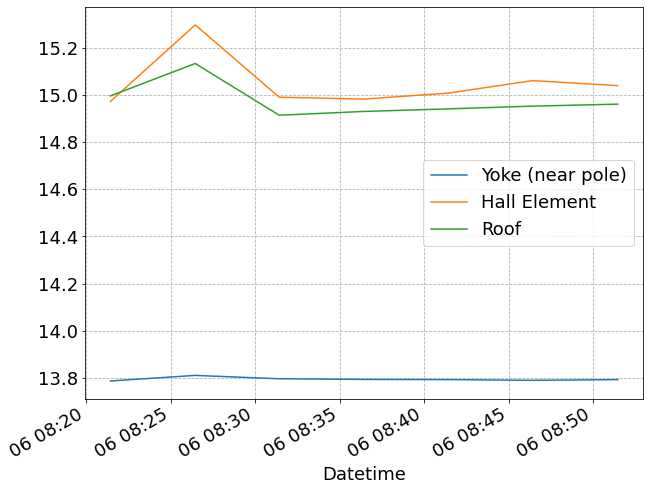

In [191]:
# yoke temp, hall probe temp
df_temp_[['Yoke (near pole)', 'Hall Element', 'Roof']].plot()

In [192]:
df_temp[['Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW in Coil 2', 'LCW out Coil 1', 'LCW out Coil 2']]

Coil 1     Coil 2  LCW in Coil1  LCW in Coil 2  \
Datetime                                                                 
2022-07-06 08:06:02  17.179739  16.412483      7.293580       8.535325   
2022-07-06 08:06:25  17.180878  16.410503      7.597311       8.750978   
2022-07-06 08:11:25  17.191080  16.457739      7.387680       8.606230   
2022-07-06 08:16:25  17.187763  16.420448      7.170765       8.337886   
2022-07-06 08:21:26  17.195730  16.430609      6.939642       8.220590   
2022-07-06 08:26:27  17.315693  16.521513      6.677495       8.135136   
2022-07-06 08:31:25  17.242937  16.474962      6.463852       8.057529   
2022-07-06 08:36:25  17.240013  16.475943      6.318263       7.968557   
2022-07-06 08:41:25  17.227299  16.463997      6.604303       8.328023   
2022-07-06 08:46:25  17.219883  16.452305      7.512538       8.865728   
2022-07-06 08:51:27  17.201950  16.434279      8.014383       9.154392   

                     LCW out Coil 1  LCW out Coil 2  
Datetime                                             
2022-07-06 08:06:02        9.002051        9.104733  
2022-07-06 08:06:25        9.237779        9.339371  
2022-07-06 08:11:25        9.089153        9.167409  
2022-07-06 08:16:25        8.914385        8.979249  
2022-07-06 08:21:26        8.755401        8.823433  
2022-07-06 08:26:27        8.583939        8.639970  
2022-07-06 08:31:25        8.452054        8.488005  
2022-07-06 08:36:25        8.406261        8.380332  
2022-07-06 08:41:25        8.735027        8.621925  
2022-07-06 08:46:25        9.361980        9.337844  
2022-07-06 08:51:27        9.602959        9.690917

In [193]:
df_temp_['Yoke (near pole)']

Datetime
2022-07-06 08:21:26    13.788161
2022-07-06 08:26:27    13.811742
2022-07-06 08:31:25    13.797531
2022-07-06 08:36:25    13.794787
2022-07-06 08:41:25    13.793944
2022-07-06 08:46:25    13.790906
2022-07-06 08:51:27    13.793885
Name: Yoke (near pole), dtype: float64

In [194]:
df_temp_['Hall Element']

Datetime
2022-07-06 08:21:26    14.971968
2022-07-06 08:26:27    15.296099
2022-07-06 08:31:25    14.989928
2022-07-06 08:36:25    14.981850
2022-07-06 08:41:25    15.007007
2022-07-06 08:46:25    15.060184
2022-07-06 08:51:27    15.038889
Name: Hall Element, dtype: float64

In [195]:
I = df_high['Magnet Current [A]'].mean()

In [196]:
I

128.03500833330884

In [197]:
df_high.magnet_X_mm.unique()

array([ 8.49976562, 10.49976562, 12.49976562, 14.49976562, 16.49976562,
       18.49976562, 20.49976562, 22.49976562, 24.49976562, 26.49976562,
       28.49976562, 30.49976562, 32.49976562, 34.49976562, 36.49976562,
       38.49976562, 40.49976562, 42.49976562, 44.49976562, 46.49976562,
       48.49976562, 50.49976562, 52.49976562, 54.49976562, 56.49976562,
       58.49976562])

In [198]:
try:
    sf_high = df_high[np.isclose(df_high.magnet_X_mm, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
    print("Data at Hall probe")
except:
    sf_high = df_high.iloc[-1]['NMR [T]']
    print("No data at Hall probe!")

Data at Hall probe


In [199]:
sf_high

0.734918158

In [200]:
B_ratio = sf_high / df_high[np.isclose(df_high.magnet_X_mm, 12.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']

In [201]:
B_ratio

0.9998406525475042

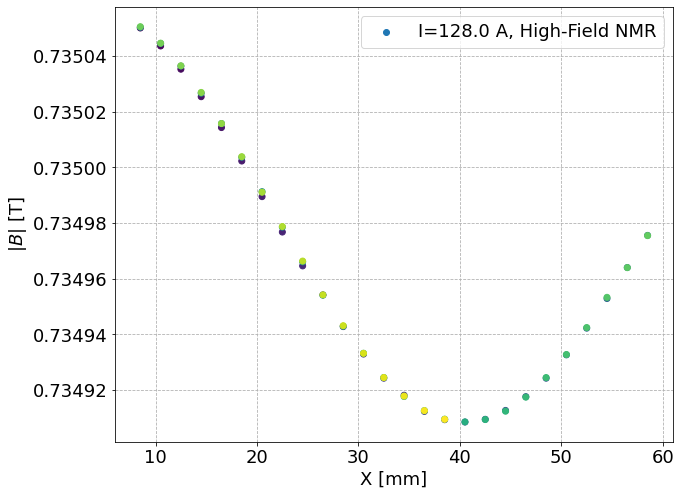

In [202]:
# field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]'], c=np.arange(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B|$ [T]')
# ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [203]:
nl = True
# scaling in different runs
i = 0
#df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
for df_ in [df_high]:
    # set runs
    run_list = []
    for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
        if new:
            i+=1
        run_list.append(int(i))
    df_.loc[:, 'run'] = run_list
    # new run for next file
    i+=1
    # find field value at Hall probe location
    sf_list = []
    for r in df_.run:
        try:
            sf = df_[np.isclose(df_.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_.run == r)].iloc[0]['NMR [T]']
        except:
            sf = df_.iloc[-1]['NMR [T]']
        sf_list.append(sf)
    df_['sf'] = sf_list    
    # whether low or high?
    df_.loc[:, 'low_NMR'] = nl

In [204]:
df_high

Time  Magnet Current [A]  \
Datetime                                                       
2022-07-06 08:19:08  7/6/2022 8:19:08 AM          128.034990   
2022-07-06 08:19:39  7/6/2022 8:19:39 AM          128.035047   
2022-07-06 08:20:09  7/6/2022 8:20:09 AM          128.034990   
2022-07-06 08:20:40  7/6/2022 8:20:40 AM          128.035103   
2022-07-06 08:21:26  7/6/2022 8:21:26 AM          128.035047   
...                                  ...                 ...   
2022-07-06 08:51:26  7/6/2022 8:51:26 AM          128.034933   
2022-07-06 08:51:55  7/6/2022 8:51:55 AM          128.034933   
2022-07-06 08:52:24  7/6/2022 8:52:24 AM          128.034990   
2022-07-06 08:52:56  7/6/2022 8:52:56 AM          128.035047   
2022-07-06 08:53:27  7/6/2022 8:53:27 AM          128.034990   

                     Magnet Voltage [V]   NMR [T]  NMR [FFT]  Zaber_Pattern_X  \
Datetime                                                                        
2022-07-06 08:19:08           14.457832  0.735050        0.0         426758.0   
2022-07-06 08:19:39           14.457120  0.735044        0.0         431878.0   
2022-07-06 08:20:09           14.456015  0.735035        0.0         436998.0   
2022-07-06 08:20:40           14.454990  0.735025        0.0         442118.0   
2022-07-06 08:21:26           14.454077  0.735014        0.0         447238.0   
...                                 ...       ...        ...              ...   
2022-07-06 08:51:26           14.456683  0.734933        0.0         483078.0   
2022-07-06 08:51:55           14.457790  0.734925        0.0         488198.0   
2022-07-06 08:52:24           14.457657  0.734918        0.0         493318.0   
2022-07-06 08:52:56           14.456570  0.734913        0.0         498438.0   
2022-07-06 08:53:27           14.455388  0.734910        0.0         503558.0   

                     Zaber_Pattern_Y  Zaber_Pattern_Z  Zaber_Meas_Encoder_X  \
Datetime                                                                      
2022-07-06 08:19:08         426430.0        1718667.0              426758.0   
2022-07-06 08:19:39         426430.0        1718667.0              431878.0   
2022-07-06 08:20:09         426430.0        1718667.0              436998.0   
2022-07-06 08:20:40         426430.0        1718667.0              442118.0   
2022-07-06 08:21:26         426430.0        1718667.0              447238.0   
...                              ...              ...                   ...   
2022-07-06 08:51:26         426432.0        1718667.0              483078.0   
2022-07-06 08:51:55         426432.0        1718667.0              488198.0   
2022-07-06 08:52:24         426432.0        1718667.0              493318.0   
2022-07-06 08:52:56         426432.0        1718667.0              498438.0   
2022-07-06 08:53:27         426432.0        1718667.0              503558.0   

                     Zaber_Meas_Micron_X  ...  Zaber_Meas_Micron_Z  \
Datetime                                  ...                        
2022-07-06 08:19:08         166702.34375  ...        671354.296875   
2022-07-06 08:19:39         168702.34375  ...        671354.296875   
2022-07-06 08:20:09         170702.34375  ...        671354.296875   
2022-07-06 08:20:40         172702.34375  ...        671354.296875   
2022-07-06 08:21:26         174702.34375  ...        671354.296875   
...                                  ...  ...                  ...   
2022-07-06 08:51:26         188702.34375  ...        671354.296875   
2022-07-06 08:51:55         190702.34375  ...        671354.296875   
2022-07-06 08:52:24         192702.34375  ...        671354.296875   
2022-07-06 08:52:56         194702.34375  ...        671354.296875   
2022-07-06 08:53:27         196702.34375  ...        671354.296875   

                     seconds_delta  hours_delta  days_delta  magnet_X_mm  \
Datetime                                                                   
2022-07-06 08:19:08           64.0     0.017778    0.00074

In [205]:
df_high.run.unique()

array([0, 1, 2])

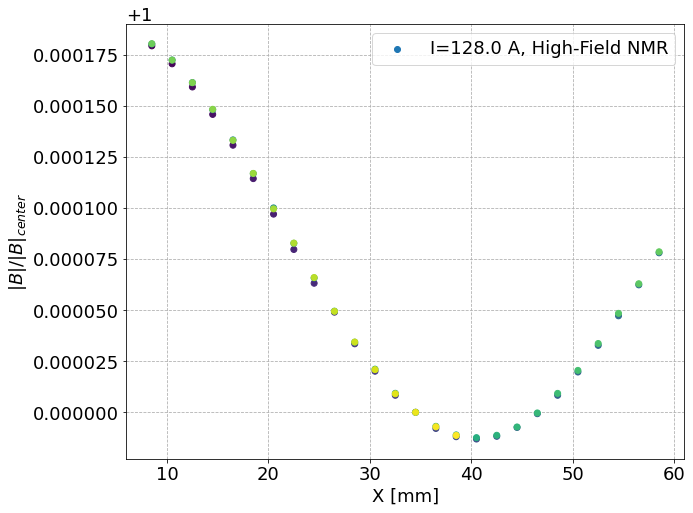

In [206]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/df_high['sf'], c=range(len(df_high)), label=f'I={I:0.1f} A, High-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

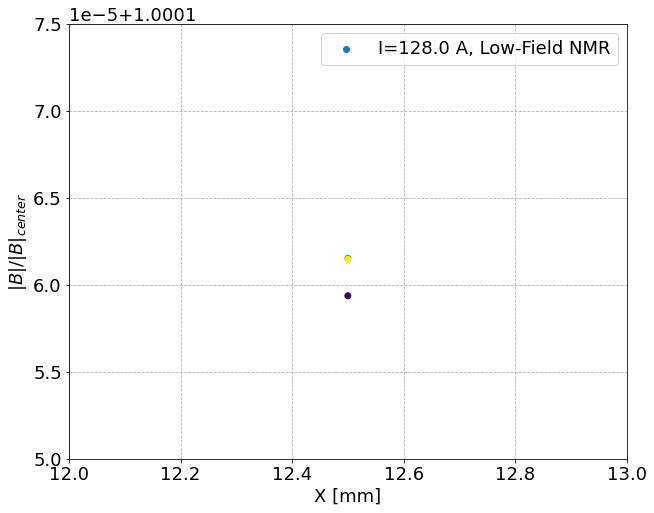

In [207]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00015, 1.000175])

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [208]:
# cut on run number
rmin = 0
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf / df_['NMR [T]'])

In [209]:
np.mean(Brs), np.std(Brs, ddof=1)

(0.9998392400886872, 1.2236084319708177e-06)

In [210]:
# apply temperature correction

In [211]:
# redo delta time from first file
df_high['seconds_delta'] = (df_high.index - df_temp.index[0]).total_seconds()
df_high['hours_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/60**2
df_high['days_delta'] = (df_high.index - df_temp.index[0]).total_seconds()/(24*60**2)
# temperature correction
B_corr = temp_correct(df_high, df_temp, tempcol="Yoke (near pole)")
# B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (near pole)")
df_high.loc[:, 'B_corr'] = B_corr
df_high.eval('deltaB = B_corr - `NMR [T]`', inplace=True)
# recalculate scale factor
# find field value at Hall probe location
sf_corr_list = []
for r in df_high.run:
    try:
        sf = df_high[np.isclose(df_high.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_high.run == r)].iloc[0]['B_corr']
    except:
        sf = df_high[(df_high.run == r)].iloc[-1]['B_corr']
    sf_corr_list.append(sf)
df_high['sf_corr'] = sf_corr_list

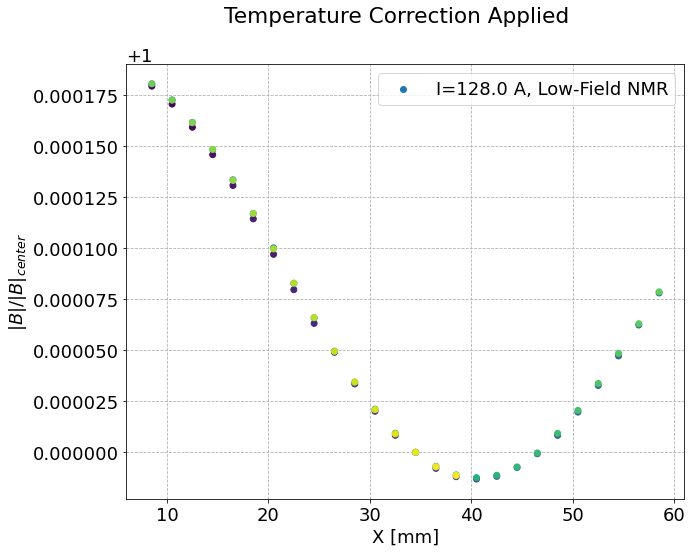

In [212]:
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
ax.scatter(df_high['magnet_X_mm'], df_high['B_corr']/df_high['sf_corr'], c=range(len(df_high)), label=f'I={I:0.1f} A, Low-Field NMR')

# ax.set_xlim([8, 13])
# ax.set_ylim([1.0001, 1.00016])

fig.suptitle('Temperature Correction Applied')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

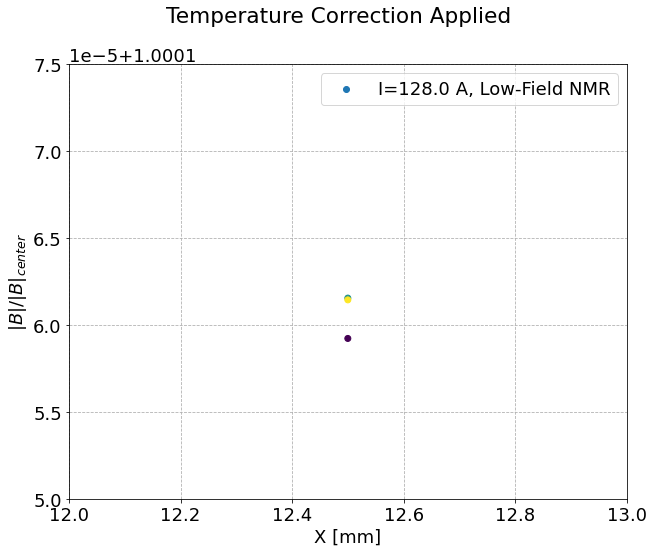

In [213]:
# cut on run number
rmin = 0
df_ = df_high.query(f'run >= {rmin}')
# scaled field plot
fig, ax = plt.subplots()

#ax.scatter(df_high['magnet_X_mm'], df_high['NMR [T]']/sf_high, label=f'I={I:0.1f} A, High-Field NMR')
# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_['sf'], c=range(len(df_)), label=f'I={I:0.1f} A, Low-Field NMR')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/df_['sf_corr'], c=df_.run, label=f'I={I:0.1f} A, Low-Field NMR')

ax.set_xlim([12, 13])
ax.set_ylim([1.00015, 1.000175])

fig.suptitle("Temperature Correction Applied")

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B|$ [T]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
ax.legend();

In [217]:
# cut on run number
rmin = 0
# rmin = 1
df_cut = df_high.query(f'run >= {rmin}')

Is = []
Brs = []
dtimes = []
rs = df_cut.run.unique()
for run in df_cut.run.unique():
    if run in (df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3)]).run.values:
        df_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].copy().iloc[0]
        Is.append(abs(df_["Magnet Current [A]"].mean()))
        Brs.append(df_.sf_corr / df_['B_corr'])
        time_ = df_cut[np.isclose(df_cut.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df_cut.run == run)].index[0]
        dtimes.append(time_)

In [218]:
np.mean(Brs), np.std(Brs, ddof=1)

(0.9998392949960871, 1.3107295860018795e-06)

In [219]:
len(Brs)

3

In [220]:
t0 = df_high.iloc[0].Time
tf = df_high.iloc[-1].Time

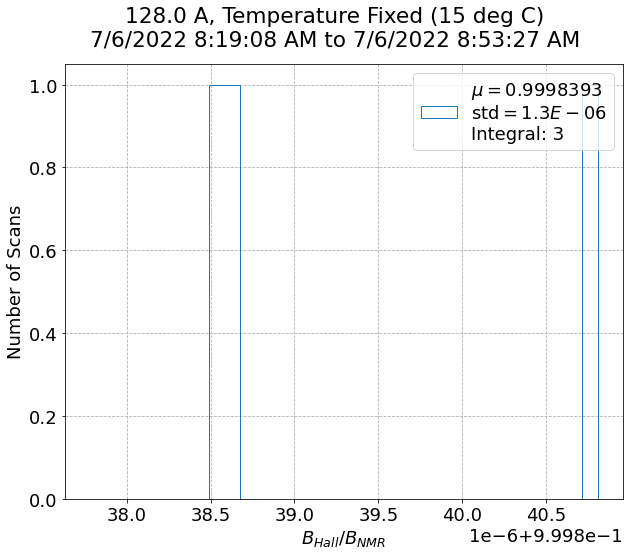

In [221]:
fig, ax = plt.subplots()

label_temp = r'$\mu = {0:.7f}$'+ '\n' + 'std' + r'$= {1:.1E}$' + '\n' +  'Integral: {2}'

n, bins, patches = ax.hist(Brs, bins=25, histtype='step', label=label_temp.format(np.mean(Brs), np.std(Brs, ddof=1), len(Brs)))

xme = np.mean(Brs)
xmi = np.min(Brs)
xma = np.max(Brs)
xli = np.max(np.abs([xme-xmi, xma-xme])) * 1.1

ax.set_xlim([xme-xli, xme+xli])

# ax.set_xlabel(r'$\frac{B_{Hall}}{B_{NMR}}$')
ax.set_xlabel(r'$B_{Hall}/B_{NMR}$')
ax.set_ylabel('Number of Scans')
fig.suptitle(f'{I:0.1f} A, Temperature Fixed (15 deg C)\n{t0} to {tf}')
ax.legend();
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [222]:
len(df_high.run.unique())

3

Text(0, 0.5, '$B_{Hall}/B_{NMR}$')

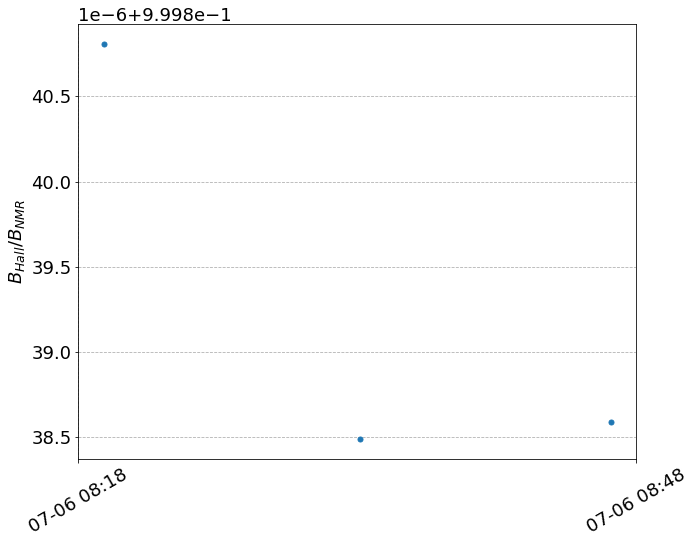

In [223]:
# ratio vs time
fig, ax = plt.subplots()

ax = datetime_plt(ax, dtimes, Brs, s=5, label=None, nmaj=8)

ax.set_ylabel(r'$B_{Hall}/B_{NMR}$')

In [224]:
df_high.index

DatetimeIndex(['2022-07-06 08:19:08', '2022-07-06 08:19:39',
               '2022-07-06 08:20:09', '2022-07-06 08:20:40',
               '2022-07-06 08:21:26', '2022-07-06 08:21:54',
               '2022-07-06 08:22:24', '2022-07-06 08:22:53',
               '2022-07-06 08:23:23', '2022-07-06 08:23:53',
               '2022-07-06 08:24:22', '2022-07-06 08:24:51',
               '2022-07-06 08:25:22', '2022-07-06 08:25:50',
               '2022-07-06 08:26:27', '2022-07-06 08:26:58',
               '2022-07-06 08:27:32', '2022-07-06 08:28:03',
               '2022-07-06 08:28:34', '2022-07-06 08:29:03',
               '2022-07-06 08:29:31', '2022-07-06 08:30:00',
               '2022-07-06 08:30:27', '2022-07-06 08:30:59',
               '2022-07-06 08:31:29', '2022-07-06 08:32:00',
               '2022-07-06 08:32:37', '2022-07-06 08:33:07',
               '2022-07-06 08:33:37', '2022-07-06 08:34:07',
               '2022-07-06 08:34:38', '2022-07-06 08:35:05',
               '2022-07-

In [225]:
dtimes

[Timestamp('2022-07-06 08:20:09'),
 Timestamp('2022-07-06 08:33:37'),
 Timestamp('2022-07-06 08:46:46')]

# All 1D and 3D Scans (B Ratio vs. I)

## All Files

In [85]:
files_all = [
    # 2022 Data
         '2022-05-25 184012.txt', # low NMR, 128 A, 400k, 3D
         '2022-05-26 100634.txt', # low NMR, 128 A, 400k # 0
         '2022-05-26 102836.txt', # high NMR, 128 A, 400k
         '2022-05-26 113036.txt', # low NMR, 42 A, 130k
         '2022-05-26 121828.txt', # low NMR, 56 A, 175k
         '2022-05-26 123926.txt', # low NMR, 80 A, 250k
         '2022-05-26 130630.txt', # low NMR, 80 A, 250k (2)
         '2022-05-26 133558.txt', # low NMR, 80 A, 250k (3)
         '2022-05-26 140638.txt', # low NMR, 104 A, 325k
         '2022-05-26 144217.txt', # low NMR, 128 A, 400k
         '2022-05-26 150239.txt', # high NMR, 128 A, 400k
         '2022-05-26 153353.txt', # high NMR, 144 A, 450k # 10
         '2022-05-26 160409.txt', # high NMR, 160 A, 500k
         '2022-05-26 163243.txt', # high NMR, 176 A, 550k
         '2022-05-26 170057.txt', # high NMR, 192 A, 600k
         '2022-05-26 173002.txt', # high NMR, 208 A, 650k
         '2022-05-26 175911.txt', # high NMR, 224 A, 700k
         '2022-05-26 182815.txt', # high NMR, 240 A, 750k
         '2022-05-26 190126.txt', # high NMR, 256 A, 800k
         '2022-05-26 193002.txt', # high NMR, 272 A, 850k -- index 18
         '2022-05-26 200005.txt', # high NMR, 288 A, 900k
         ###'2022-05-26 202323.txt', # high NMR, 288 A, 900k, 3D overnight. Note that this one missed 34.5 mm, BAD
         '2022-05-27 080822.txt', # high NMR, 288 A, 900k # 20
         '2022-05-27 083743.txt', # high NMR, 300 A, 940k -- Power Supply Limit
         '2022-05-27 090821.txt', # high NMR, -300 A, -940k -- Power Supply Limit
         '2022-05-27 094135.txt', # low NMR, 42 A, 130k
         '2022-05-27 101134.txt', # low NMR, -42 A, 130k
         '2022-05-27 103216.txt', # low NMR, -42 A, 130k
         '2022-05-27 105803.txt', # low NMR, 42 A, 130k -- degaussed starting at higher field (600k)
         '2022-05-27 111726.txt', # low NMR, 42 A, 130k
         '2022-05-27 123838.txt', # low NMR, 42 A, 130k, enclosure set 45 C, actual 27.5 C
         '2022-05-27 125726.txt', # low NMR, 42 A, 130k, enclosure set 45 C, actual 28.8 C 
         '2022-05-27 132405.txt', # low NMR, -42 A, 130k -- better degauss, enclosure set 45 C, actual 30 C # 30
         '2022-05-27 140740.txt', # high NMR, 272 A, 850k -- better degauss, enclosure set 45 C, actual ?? C, 0.5mm scan -- 31
         '2022-05-27 162535.txt', # high NMR, 272 A, 850k, enclosure set 45 C, actual 40 C -- 32
         '2022-05-27 171220.txt', # high NMR, 272 A, 850k, enclosure set 45 C, actual ?? C -- 33
         '2022-05-27 180522.txt', # high NMR, 272 A, 850k, enclosure set 45 C, actual ?? C, 0.5 mm scan -- 34
         '2022-05-28 165647.txt', # high NMR, 272 A, 850k, enclosure set 45 C, actual 45 C -- 35
         '2022-05-28 172957.txt', # high NMR, 272 A, 850k, 45 deg C, 3D
         ## MISSING
         '2022-05-29 224746.txt', # high, 272 A, 1D
         '2022-05-29 224746.txt', # high, 272 A, 1D
         '2022-05-29 231658.txt', # high, 272 A, 1D, 0.5 mm step size
         '2022-05-29 235815.txt', # high, 272 A, 1D, 0.5 mm step size
         '2022-05-30 012134.txt', # high, 272 A, 1D, 1 mm step size
         '2022-05-31 085725.txt', # high, 272 A, 3D, 18 deg C
#          '2022-05-31 225539.txt', # TEST ONLY!
         '2022-05-31 231343.txt', # high, 272 A, 36 1D scans, 18 deg C
        ###
         '2022-06-01 094148.txt', # low NMR, 56 A, 175k, enclosure at 18 deg C -- check this one
         '2022-06-01 101917.txt', # low NMR, 56 A, 175k, intentional saturation
         '2022-06-01 124915.txt', # low NMR, 80 A, 250k, intentional saturation
         '2022-06-01 131552.txt', # low NMR, 104 A, 325k, intentional saturation
         '2022-06-01 135708.txt', # low NMR, 128 A, 400k, intentional saturation
         '2022-06-01 142807.txt', # low NMR, 42 A, 130k, intentional saturation -- 81 1D scans # 40
         '2022-06-02 121043.txt', # low NMR, 42 A, 130k, 3D, 18 deg C
         '2022-06-03 141648.txt', # low NMR, 42 A, 130k, right after changing temp from 18 deg C to 45 deg C -- 169 1D scans
         '2022-06-05 013328.txt', # low NMR, 42 A, 130k, 3D, 45 deg C     
         '2022-06-06 115947.txt', # low NMR, 42 A, 130k, after stabilized again at 18 deg C -- 4 1D scans
         '2022-06-06 145901.txt', # low NMR, 56 A, 175k, temp stable at 18 deg C -- 169 (did not finish all) 1D scans. Thomas ran standard degauss. See how shape changes in time.
         '2022-06-07 095924.txt', # low NMR, 56 A, 175k, temp stable at 15 deg C after cycle to 45 deg C back to 15 deg C -- 25 1D scans.
         '2022-06-07 173843.txt', # high NMR, 272 A, 850k, 169 1D scans, temp at 15 deg C
         '2022-06-08 135518.txt', # high NMR, 176 A, 550k, 169 1D scans, temp at 15 deg C -- should be ~1 T
         #'2022-06-10 071443.txt', # high NMR, 176 A, 550k, very coarse 3D scan -- does not hit 34.5
         '2022-06-10 102121.txt', # high NMR, 176 A, 550k, finer 3D scan
         '2022-06-12 081122.txt', # high NMR, 175 A, 550k, finer 3D scan. Same step size, but larger range (4 cm x 4cm in YZ)
         '2022-06-15 101450.txt', # high NMR, 179 A, 560k, scanning around 1 T (0.997 T), 225 scans
         '2022-06-17 113001.txt', # high NMR, 182 A, 570k, scanning around 1 T (1.01 T), 289 scans
         '2022-06-22 125101.txt', # high NMR, 128 A, 400k, 169 scans
         '2022-07-06 081803.txt', # low NMR, 128 A, 400k, 3 scans, cross-check between low and high NMR after long equilibration
        ]

nmr_low_all = [
    # 2022 data
           True,
           True, # 0
           False,
           True,
           True,
           True,
           True,
           True,
           True,
           True,
           False,
           False, # 10
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           False,
           ### False, # BAD! 3D
           False, # 20
           False,
           False,
           True,
           True,
           True,
           True,
           True,
           True,
           True,
           True, # 30
           False,
           False,
           False,
           False,
           False,
           False, # 3D
    ## MISSING
           False,
           False,
           False,
           False,
           False,
           False, # 3D
           # False, # TEST ONLY!
           False,
    ####
           True,
           True,
           True,
           True,
           True,
           True, # 40
           True,
           True,
           True,
           True,
           True,
           True,
           False,
           False,
           #False, # 3D very coarse -- BAD
           False, # 3D# wait until at 34.5 mm
           False, # same 3D step size as above, but larger range
           False,
           False,
           False,
           True,
          ]

tempfiles_all = [
    # 2022 data
             '2022-05-25 182823slow.txt',
             '2022-05-26 093219slow.txt',
             '2022-05-31 085349slow.txt',
             '2022-06-06 115655slow.txt',
             '2022-06-07 095827slow.txt',
             '2022-07-06 080602slow.txt',
            ]

In [86]:
len(files_all), len(nmr_low_all)

(65, 65)

In [87]:
ddir_full = ddir+'temp_pole_to_pole_05-25-22/'

## Analyze

In [15]:
indexes_850k = [18, 31, 32, 33, 34, 35]

In [16]:
%load_ext line_profiler

In [17]:
def process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, keep_incomplete=False, prof=False):
    # now has a long runtime -- a few minutes
    t0 = time()
    t0_load = time()
    print("Loading Scans")
    i = 0
    dfs = []
    if prof:
        fall = files_all[:10]
        nlall = nmr_low_all[:10]
    else:
        fall = files_all
        nlall = nmr_low_all
    # for f, nl in zip(files_all, nmr_low_all): # all
    for f, nl in zip(fall, nlall):
    #for f, nl in zip(files, nmr_low): # all
    # for f, nl in zip(itemgetter(*indexes_850k)(files), itemgetter(*indexes_850k)(nmr_low)): # 850k runs only
        df_ = load_data(ddir_full+f, low_NMR=nl).iloc[1:]
        # set runs
        run_list = []
        for index, new in enumerate(np.concatenate([[False], np.diff(df_['magnet_X_mm'])<0])):
            if new:
                i+=1
            run_list.append(int(i))
        df_.loc[:, 'run'] = run_list
        # new run for next file
        i+=1
#         # flag 3D or not
#         list_3D = []
#         for r in df_.run:
#             df_run = df_[df_.run]
        '''
        # find field value at Hall probe location
        sf_list = []
        complete_list = []
        for r in df_.run:
            #df_run = df_.query(f'run == {r}')
            df_run = df_[df_.run == r]
            # check if 3D or not:
            if len(df_run['Zaber_Pattern_Y'].unique()) > 1:
                df_line = df_run[np.isclose(df_run.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df_run.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)].copy()
            else:
                df_line = df_run.copy()
            try:
    #             sf = df_line[np.isclose(df_line.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df_line.run == r)].iloc[0]['NMR [T]']
                sf = df_line[np.isclose(df_line.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]['NMR [T]']
            except:
                sf = df_line.iloc[-1]['NMR [T]']
            sf_list.append(sf)
            # flag complete or not
            if (df_run.magnet_X_mm.max() < 34):
                #print(f'Run {run} incomplete! Maximum X = {df_.magnet_X_mm.max()}')
                complete = False
            else:
                complete = True
            complete_list.append(complete)
        df_['sf'] = sf_list
        df_['complete'] = complete_list
        '''
        # whether low or high?
        df_.loc[:, 'low_NMR'] = nl
        dfs.append(df_)

    df = pd.concat(dfs, ignore_index=False)
    # remove 3D
    df = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)] 
    
    tf_load = time()
    print(f"Finished Loading Scans Into 'df'! Runtime: {tf_load-t0_load} s\n")

    t0_temp = time()
    print("Loading Temps")
    # load temperature data
    dfs_temp = []
    for f in tempfiles_all:
        df_ = load_data(ddir_full+f, low_NMR=True)#.iloc[1:]
        dfs_temp.append(df_)

    df_temp = pd.concat(dfs_temp, ignore_index=False)

    tf_temp = time()
    print(f"Finished Loading Temps Into 'df_temp'! Runtime: {tf_temp-t0_temp} s\n")

    t0_time = time()
    print("Resetting time to common t0")
    # redo delta time from first temp point
    t_init = df_temp.index[0]
    delta_temp = df_temp.index - t_init
    delta_df = df.index - t_init
    df_temp['seconds_delta'] = delta_temp.total_seconds()
    df_temp['hours_delta'] = delta_temp.total_seconds()/60**2
    df_temp['days_delta'] = delta_temp.total_seconds()/(24*60**2)
    df['seconds_delta'] = delta_df.total_seconds()
    df['hours_delta'] = delta_df.total_seconds()/60**2
    df['days_delta'] = delta_df.total_seconds()/(24*60**2)

    tf_time = time()
    print(f"Finished resetting times! Runtime: {tf_time-t0_time} s\n")

    # cut low point that not all measurements have
    ## df = df.query('magnet_X_mm > 11').copy()

    t0_tcorr = time()
    print("Applying temperature correction")
    # temperature correction
    #B_corr = temp_correct(df, df_temp, tempcol="Yoke (near pole)")
    B_corr = temp_correct(df, df_temp, tempcol="Yoke (center magnet)") # this is what I used in B vs. I
    # B_corr = temp_correct(df, df_temp, T0=20, tempcol="Yoke (center magnet)")
    df.loc[:, 'B_corr'] = B_corr
    df.eval('deltaB = B_corr - `NMR [T]`', inplace=True)

    tf_tcorr = time()
    print(f"Finished temperature correction! Runtime: {tf_tcorr-t0_tcorr} s\n")

    t0_sf = time()
    print("Recalculating scale factor, with temperature correction - 'sf_corr'")
    # recalculate scale factor
    # find field value at Hall probe location
    
    # grab point for correcting
    df_sfs = df[np.isclose(df.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3)]
    
    sf_list = []
    complete_list = []
    sf_corr_list = []
    for r in df.run:
        ###### old
    #     try:
    #         sf = df[np.isclose(df.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3) & (df.run == r)].iloc[0]['B_corr']
    #     except:
    #         sf = df.iloc[-1]['NMR [T]']
    #     sf_corr_list.append(sf)
        ##### new
        #df_run = df.query(f'run == {r}')
        df_run = df[df.run == r]
        try:
            df_p = df_sfs[df_sfs.run == r].iloc[0]
        except:
            df_p = df_run.iloc[-1]
        # check if 3D or not:
#         if len(df_run['Zaber_Pattern_Y'].unique()) > 1:
#             df_line = df_run[np.isclose(df_run.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df_run.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3)]#.copy()
#         else:
#             df_line = df_run#.copy()
        df_line = df_run
#         try:
#             df_p = df_line[np.isclose(df_line.magnet_X_mm.values, 34.5, atol=1e-1, rtol=1e-3)].iloc[0]
#         except:
#             df_p = df_line.iloc[-1]
        sf_c = df_p['B_corr']
        sf = df_p['NMR [T]']
        sf_corr_list.append(sf_c)
        sf_list.append(sf)
        # flag complete or not
        if (df_run.magnet_X_mm.max() < 34):
            #print(f'Run {run} incomplete! Maximum X = {df_.magnet_X_mm.max()}')
            complete = False
        else:
            complete = True
        complete_list.append(complete)
    df['sf'] = sf_list
    df['sf_corr'] = sf_corr_list
    df['complete'] = complete_list
    # remove points when magnet is off
    #df = df.query('`NMR [T]` > 0.19').copy()
    df = df[df['NMR [T]'] > 0.19].copy()
    # remove incomplete?
    if not keep_incomplete:
        df = df[df['complete']].copy()
    tf_sf = time()
    print(f"Finished scale factor recalculation! Runtime: {tf_sf-t0_sf} s\n\n")
    tf_sf = time()
    print(f"Finished processing! Total Runtime: {tf_sf-t0} s")
    
    return df, df_temp

### Profiling

In [ ]:
df, df_temp = process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
# original function
%lprun -f process_pole_to_pole process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
# removing query
%lprun -f process_pole_to_pole process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
df, df_temp = process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
# combining some loops / queries
%lprun -f process_pole_to_pole process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
df, df_temp = process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
# remove all but final "copy()"
%lprun -f process_pole_to_pole process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
df, df_temp = process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
# remove unnecessary 3D data. Find scale factor point for all runs at once
%lprun -f process_pole_to_pole process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

In [ ]:
df, df_temp = process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, prof=True)

### Standard Running

In [172]:
df, df_temp = process_pole_to_pole(files_all, nmr_low_all, tempfiles_all, keep_incomplete=False, prof=False)

Loading Scans
Finished Loading Scans Into 'df'! Runtime: 4.8877174854278564 s

Loading Temps
Finished Loading Temps Into 'df_temp'! Runtime: 0.47974562644958496 s

Resetting time to common t0
Finished resetting times! Runtime: 0.005784749984741211 s

Applying temperature correction
Finished temperature correction! Runtime: 2.268251657485962 s

Recalculating scale factor, with temperature correction - 'sf_corr'
Finished scale factor recalculation! Runtime: 30.353727102279663 s


Finished processing! Total Runtime: 37.99565052986145 s


In [173]:
len(files_all)

65

In [174]:
len(df)

61816

In [175]:
#df = df.query('`NMR [T]` > 0.19').copy()

In [176]:
len(df)

61816

In [177]:
df.shape

(61816, 28)

In [178]:
len(df.run.unique())

1336

In [179]:
df[['NMR [T]', 'B_corr', 'deltaB', 'sf', 'sf_corr']]

NMR [T]    B_corr        deltaB        sf   sf_corr
Datetime                                                                 
2022-05-25 19:10:28  0.735824  0.735829  5.479723e-06  0.735734  0.735732
2022-05-25 20:14:23  0.735828  0.735831  3.528245e-06  0.735734  0.735732
2022-05-25 21:19:20  0.735827  0.735830  2.081013e-06  0.735734  0.735732
2022-05-25 22:23:48  0.735824  0.735825  9.755752e-07  0.735734  0.735732
2022-05-25 23:28:48  0.735817  0.735818  2.283023e-07  0.735734  0.735732
...                       ...       ...           ...       ...       ...
2022-07-06 08:38:36  0.734925  0.734925 -2.619396e-08  0.734918  0.734918
2022-07-06 08:39:06  0.734918  0.734918 -3.271368e-08  0.734918  0.734918
2022-07-06 08:39:36  0.734913  0.734913 -3.923341e-08  0.734918  0.734918
2022-07-06 08:40:03  0.734910  0.734910 -4.510116e-08  0.734918  0.734918
2022-07-06 08:40:34  0.734909  0.734909 -5.183821e-08  0.734918  0.734918

[61816 rows x 5 columns]

In [180]:
plt.rcParams.update({"text.usetex": False})

<AxesSubplot:xlabel='Datetime'>

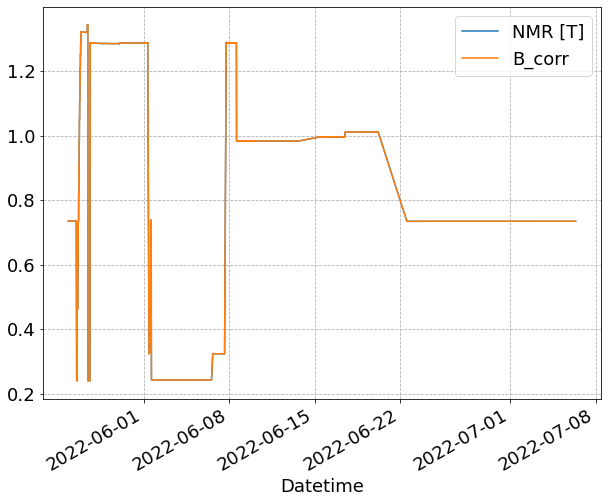

In [181]:
# NMR
df.query('`NMR [T]` > 0.1')[['NMR [T]', 'B_corr']].plot()

<AxesSubplot:xlabel='Datetime'>

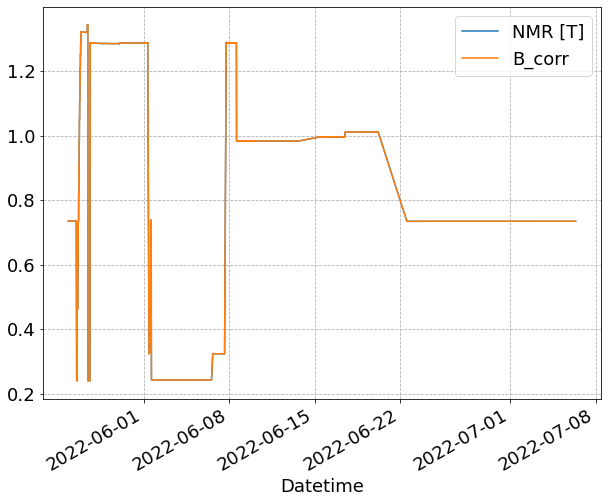

In [182]:
df[['NMR [T]', 'B_corr']].plot()

<AxesSubplot:xlabel='Datetime'>

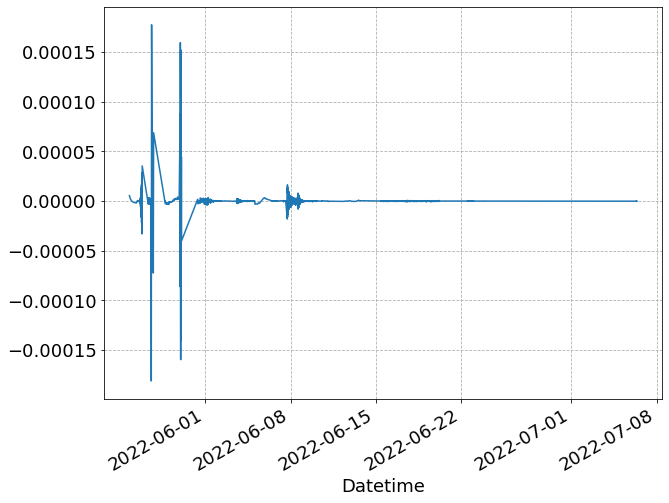

In [183]:
df.query('`NMR [T]` > 0.1')['deltaB'].plot()

In [30]:
df['deltaB'].describe()

count    6.177300e+04
mean     1.500714e-19
std      7.524786e-06
min     -1.811060e-04
25%     -8.253351e-08
50%      6.390706e-10
75%      8.628805e-08
max      1.774861e-04
Name: deltaB, dtype: float64

In [31]:
df_temp['Yoke (near pole)']

Datetime
2022-05-25 18:28:24    14.997712
2022-05-25 18:28:47    14.994810
2022-05-25 18:33:47    14.947301
2022-05-25 18:38:47    14.910321
2022-05-25 18:43:48    14.869518
                         ...    
2022-06-24 14:00:28    13.832323
2022-06-24 14:05:29    13.834047
2022-06-24 14:10:29    13.832048
2022-06-24 14:15:29    13.836165
2022-06-24 14:20:29    13.832578
Name: Yoke (near pole), Length: 8031, dtype: float64

In [32]:
df.run.unique()

array([   0,    1,    2, ..., 1334, 1335, 1336])

In [33]:
df['Magnet Current [A]']

Datetime
2022-05-25 19:10:28    128.035840
2022-05-25 20:14:23    128.035840
2022-05-25 21:19:20    128.035897
2022-05-25 22:23:48    128.035840
2022-05-25 23:28:48    128.036010
                          ...    
2022-06-24 02:09:15    128.035387
2022-06-24 02:09:30    128.035387
2022-06-24 02:09:44    128.035387
2022-06-24 02:09:58    128.035500
2022-06-24 02:10:29    128.035443
Name: Magnet Current [A], Length: 61773, dtype: float64

In [34]:
dfs[0].magnet_X_mm.unique()

NameError: name 'dfs' is not defined

In [35]:
df

Time  Magnet Current [A]  \
Datetime                                                         
2022-05-25 19:10:28   5/25/2022 7:10:28 PM          128.035840   
2022-05-25 20:14:23   5/25/2022 8:14:23 PM          128.035840   
2022-05-25 21:19:20   5/25/2022 9:19:20 PM          128.035897   
2022-05-25 22:23:48  5/25/2022 10:23:48 PM          128.035840   
2022-05-25 23:28:48  5/25/2022 11:28:48 PM          128.036010   
...                                    ...                 ...   
2022-06-24 02:09:15   6/24/2022 2:09:15 AM          128.035387   
2022-06-24 02:09:30   6/24/2022 2:09:30 AM          128.035387   
2022-06-24 02:09:44   6/24/2022 2:09:44 AM          128.035387   
2022-06-24 02:09:58   6/24/2022 2:09:58 AM          128.035500   
2022-06-24 02:10:29   6/24/2022 2:10:29 AM          128.035443   

                     Magnet Voltage [V]   NMR [T]  NMR [FFT]  Zaber_Pattern_X  \
Datetime                                                                        
2022-05-25 19:10:28           14.190767  0.735824        0.0         426758.0   
2022-05-25 20:14:23           14.189970  0.735828        0.0         431878.0   
2022-05-25 21:19:20           14.189603  0.735827        0.0         436998.0   
2022-05-25 22:23:48           14.188622  0.735824        0.0         442118.0   
2022-05-25 23:28:48           14.188388  0.735817        0.0         447238.0   
...                                 ...       ...        ...              ...   
2022-06-24 02:09:15           14.462112  0.734796        0.0         547385.0   
2022-06-24 02:09:30           14.462167  0.734801        0.0         549945.0   
2022-06-24 02:09:44           14.462297  0.734806        0.0         552505.0   
2022-06-24 02:09:58           14.462495  0.734811        0.0         555065.0   
2022-06-24 02:10:29           14.463165  0.734816        0.0         557625.0   

                     Zaber_Pattern_Y  Zaber_Pattern_Z  Zaber_Meas_Encoder_X  \
Datetime                                                                      
2022-05-25 19:10:28         426431.0        1718667.0              426758.0   
2022-05-25 20:14:23         426431.0        1718667.0              431878.0   
2022-05-25 21:19:20         426431.0        1718667.0              436998.0   
2022-05-25 22:23:48         426431.0        1718667.0              442118.0   
2022-05-25 23:28:48         426431.0        1718667.0              447238.0   
...                              ...              ...                   ...   
2022-06-24 02:09:15         426437.0        1664888.0              547385.0   
2022-06-24 02:09:30         426437.0        1664888.0              549945.0   
2022-06-24 02:09:44         426437.0        1664888.0              552505.0   
2022-06-24 02:09:58         426437.0        1664888.0              555065.0   
2022-06-24 02:10:29         426437.0        1664888.0              557625.0   

                     Zaber_Meas_Micron_X  ...  magnet_Y_mm  magnet_Z_mm   run  \
Datetime                                  ...                                   
2022-05-25 19:10:28        166702.343750  ...   124.999948   125.000043     0   
2022-05-25 20:14:23        168702.343750  ...   124.999948   125.000043     0   
2022-05-25 21:19:20        170702.343750  ...   124.999948   125.000043     0   
2022-05-25 22:23:48        172702.343750  ...   124.999948   125.000043     0   
2022-05-25 23:28:48        174702.343750  ...   124.999948   125.000043     0   
...                                  ...  ...          ...          ...   ...   
2022-06-24 02:09:15        213822.265625  ...   125.002292   124.997465  1336   
2022-06-24 02:09:30        214822.265625  ...   125.002292   124.997465  1336   
2022-06-24 02:09:44        215822.265625  ...   125.002292   124.997465  1336   
2022-06-24 02:09:58        216822.265625  ...   125.002292   124.997465  1336   
2022-06-24 02:10:29        217822.265625  ...   125.002292   124.997465  1336   

                     low_NMR  Yoke (center 

In [36]:
df.query('run == 1')['Yoke (near pole)']

KeyError: 'Yoke (near pole)'

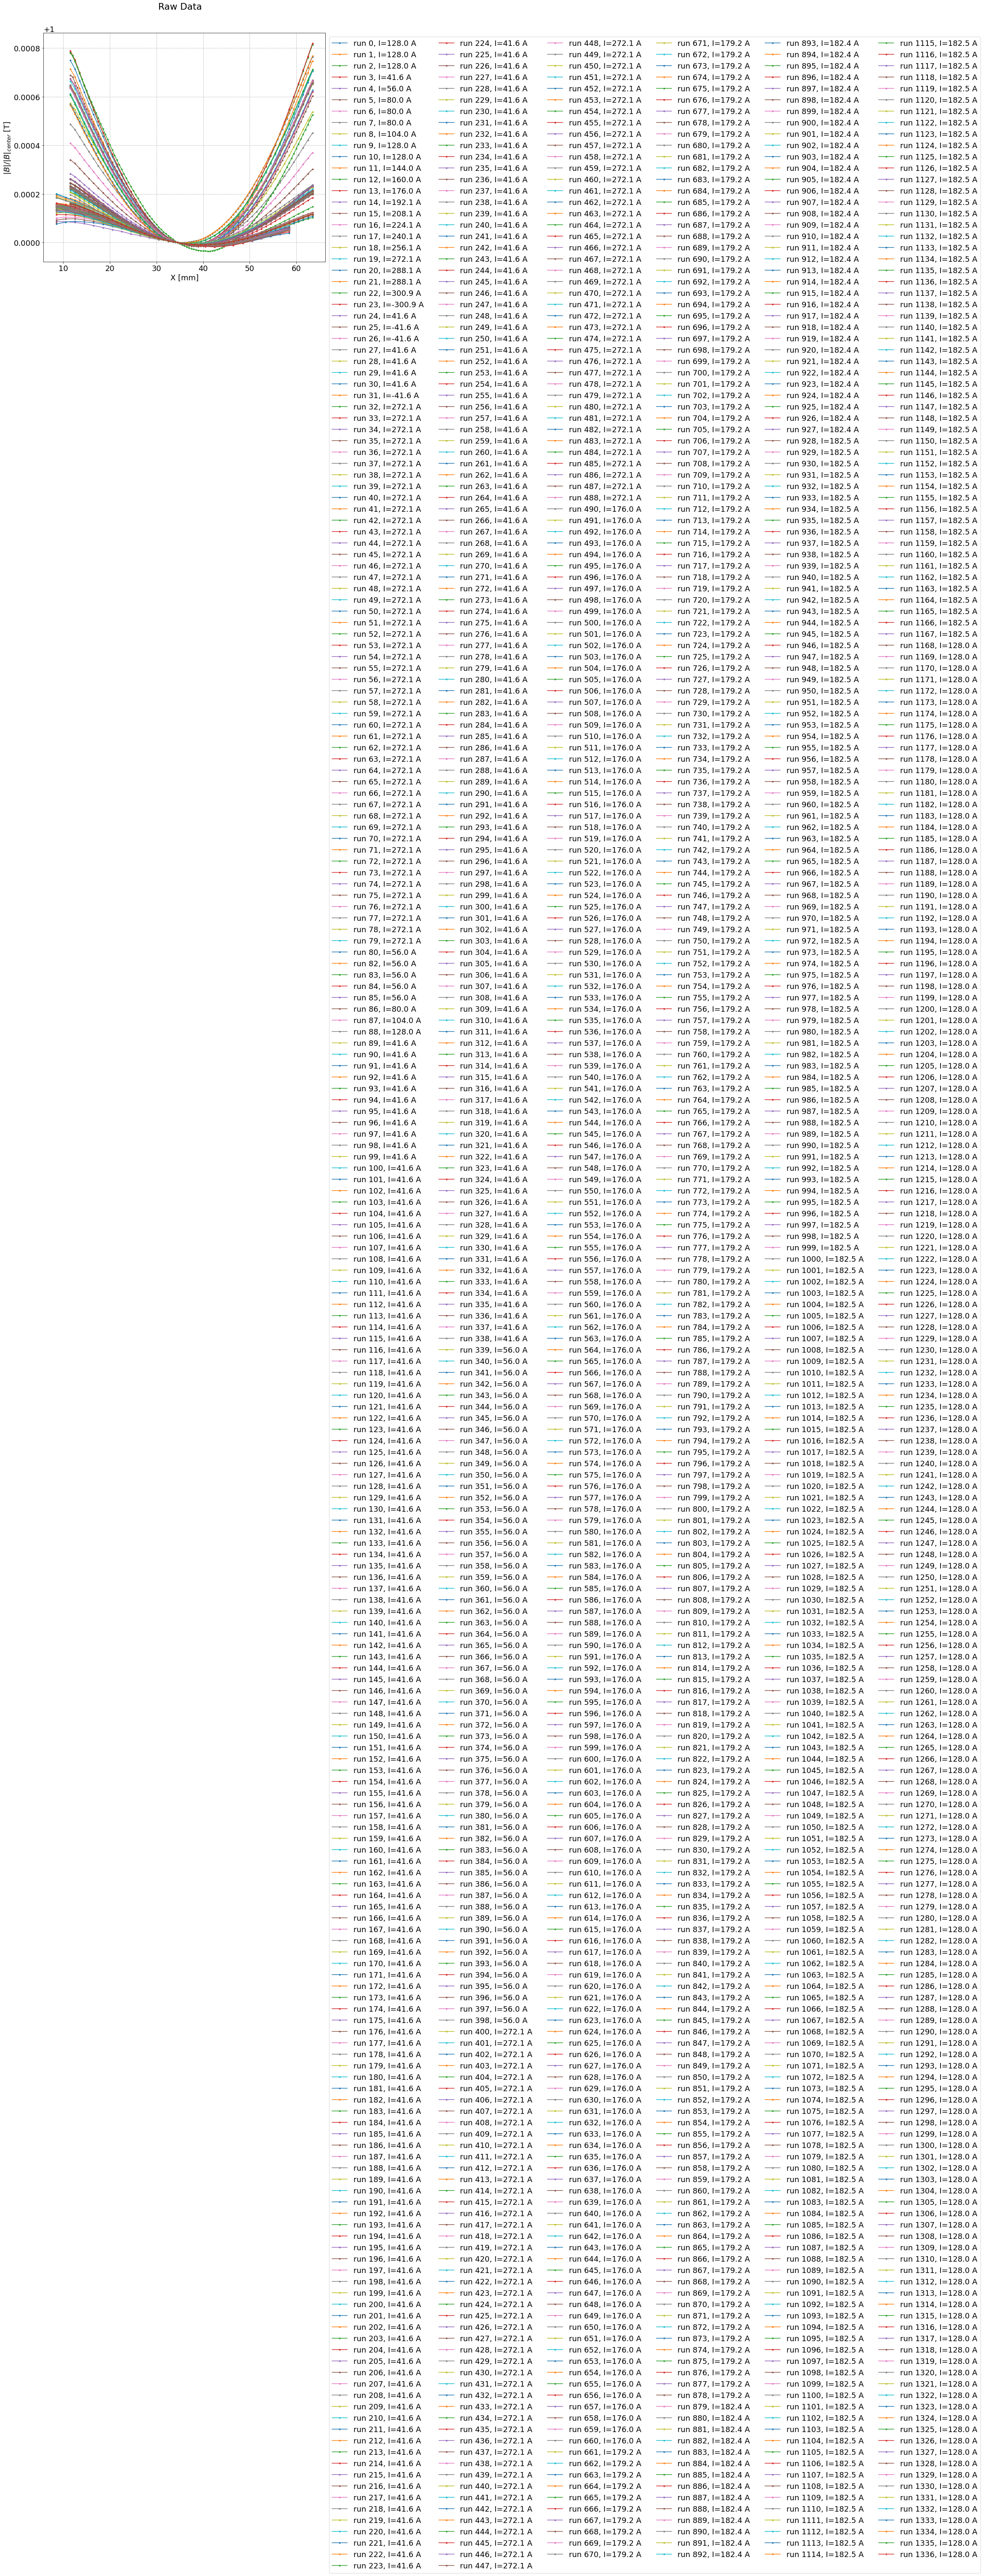

In [37]:
fig, ax = plt.subplots(figsize=(12, 10))
for run in df.run.unique():
    df_ = df[df.run == run]
    #df_ = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3) & (df.run == run)].copy()
    #ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_.sf, label=f'run {run}, I={df_["Magnet Current [A]"].mean():0.1f} A')
    if run==df.run.max():
        m = '+'
    else:
        m = '.'
    ax.plot(df_['magnet_X_mm'], df_['NMR [T]']/df_.sf, marker=m, label=f'run {run}, I={df_["Magnet Current [A]"].mean():0.1f} A')

fig.suptitle('Raw Data')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B| / |B|_{center}$ [T]')
ax.legend(bbox_to_anchor=(1.0,1.0), ncol=6);

In [ ]:
len(df.run.unique())

In [ ]:
df.query('run == 1')[['NMR [T]', 'B_corr']].plot()

In [ ]:
df.query('run == 1')['Yoke (near pole)'].mean()

In [ ]:
df.query('run == 1')['Yoke (near pole)']

In [ ]:
1e-4 / 1

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy()
    df_ = df[df.run == run]
    #df_ = df[np.isclose(df.magnet_Y_mm, 125, atol=1e-1, rtol=1e-3) & np.isclose(df.magnet_Z_mm, 125, atol=1e-1, rtol=1e-3) & (df.run == run)].copy()
    #ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_.sf, label=f'run {run}, I={df_["Magnet Current [A]"].mean():0.1f} A')
    if run==df.run.max():
        m = '+'
    else:
        m = '.'
    ax.plot(df_['magnet_X_mm'], df_['B_corr']/df_.sf_corr, marker=m, label=f'run {run}, I={df_["Magnet Current [A]"].mean():0.1f} A')
    if (df_.magnet_X_mm.max() < 34):
        print(f'Run {run} incomplete! Maximum X = {df_.magnet_X_mm.max()}')
ax.set_xlim([0, 75])
            
fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B| / |B|_{center}$ [T]')
ax.legend(bbox_to_anchor=(1.0,1.0), ncol=6);

In [ ]:
df.query('run == 1').iloc[0].Time

In [184]:
r = 1
# t0 = '2022-05-27 14:00'
# tf = '2022-05-27 14:45'
t0 = df.query(f'run == {r}').iloc[0].Time
tf = df.query(f'run == {r}').iloc[-1].Time
df_temp.query(f'"{t0}" <= Datetime <= "{tf}"')['Yoke (near pole)']

Datetime
2022-05-26 10:07:44    13.222822
2022-05-26 10:12:44    13.214375
2022-05-26 10:17:46    13.224115
2022-05-26 10:22:45    13.220138
Name: Yoke (near pole), dtype: float64

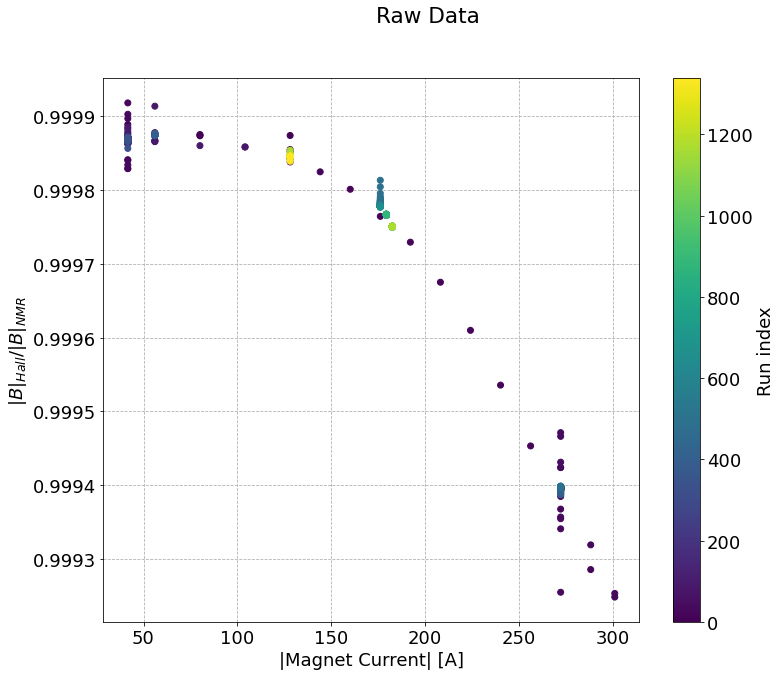

In [185]:
fig, ax = plt.subplots(figsize=(12, 10))
Is = []
Brs = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
    #print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
#     Is.append(df_["Magnet Current [A]"].mean())
    Is.append(abs(df_["Magnet Current [A]"].mean()))
    Brs.append(df_.sf / df_['NMR [T]'])
    
sc = ax.scatter(Is, Brs, c=rs) #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Run index')

# ax.set_ylim([0.9992, 1.0000])

fig.suptitle('Raw Data')
ax.set_xlabel('|Magnet Current| [A]')
ax.set_ylabel(r'$|B|_{Hall} / |B|_{NMR}$');
# ax.legend();

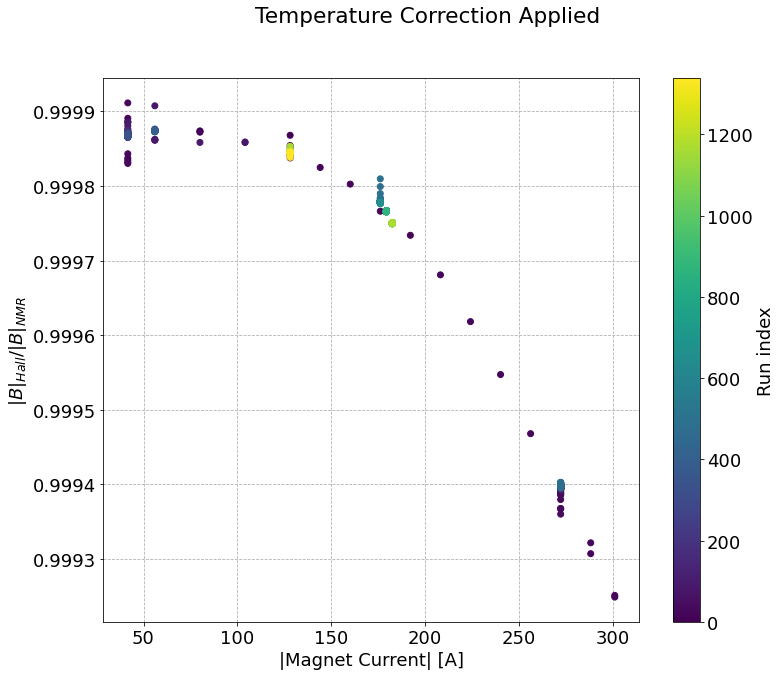

In [186]:
fig, ax = plt.subplots(figsize=(12, 10))
Is = []
Brs = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
    #print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
#     Is.append(df_["Magnet Current [A]"].mean())
    Is.append(abs(df_["Magnet Current [A]"].mean()))
    Brs.append(df_.sf_corr / df_['B_corr'])
    
sc = ax.scatter(Is, Brs, c=rs) #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Run index')

# ax.set_ylim([0.9992, 1.0000])

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('|Magnet Current| [A]')
ax.set_ylabel(r'$|B|_{Hall} / |B|_{NMR}$');
# ax.legend();

In [ ]:
0.999839577892756

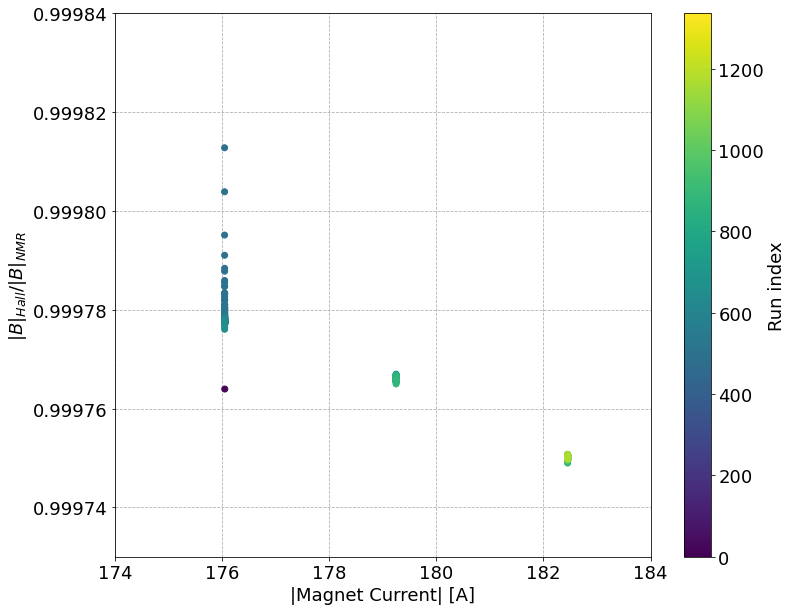

In [43]:
# inspection
fig, ax = plt.subplots(figsize=(12, 10))
Is = []
Brs = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
    #print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
#     Is.append(df_["Magnet Current [A]"].mean())
    Is.append(abs(df_["Magnet Current [A]"].mean()))
    Brs.append(df_.sf / df_['NMR [T]'])
    
sc = ax.scatter(Is, Brs, c=rs) #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Run index')

# near 125
# ax.set_xlim([90, 150])
# ax.set_ylim([0.9998, 0.9999])
# near 280
# ax.set_xlim([275, 305])
# ax.set_ylim([0.99923, 0.99935])
# near 42
# ax.set_xlim([35, 50])
# ax.set_ylim([0.9998, 0.99995])
# near 56
# ax.set_xlim([52, 58])
# ax.set_ylim([0.99986, 0.99989])
# near 176
ax.set_xlim([174, 184])
ax.set_ylim([0.99973, 0.99984])

ax.set_xlabel('|Magnet Current| [A]')
ax.set_ylabel(r'$|B|_{Hall} / |B|_{NMR}$');
# ax.legend();

In [44]:
df_temp['Roof']

Datetime
2022-05-25 18:28:24    17.956118
2022-05-25 18:28:47    17.955412
2022-05-25 18:33:47    17.954273
2022-05-25 18:38:47    17.945639
2022-05-25 18:43:48    17.953861
                         ...    
2022-06-24 14:00:28    14.990027
2022-06-24 14:05:29    14.986046
2022-06-24 14:10:29    14.992418
2022-06-24 14:15:29    14.988517
2022-06-24 14:20:29    14.997517
Name: Roof, Length: 8031, dtype: float64

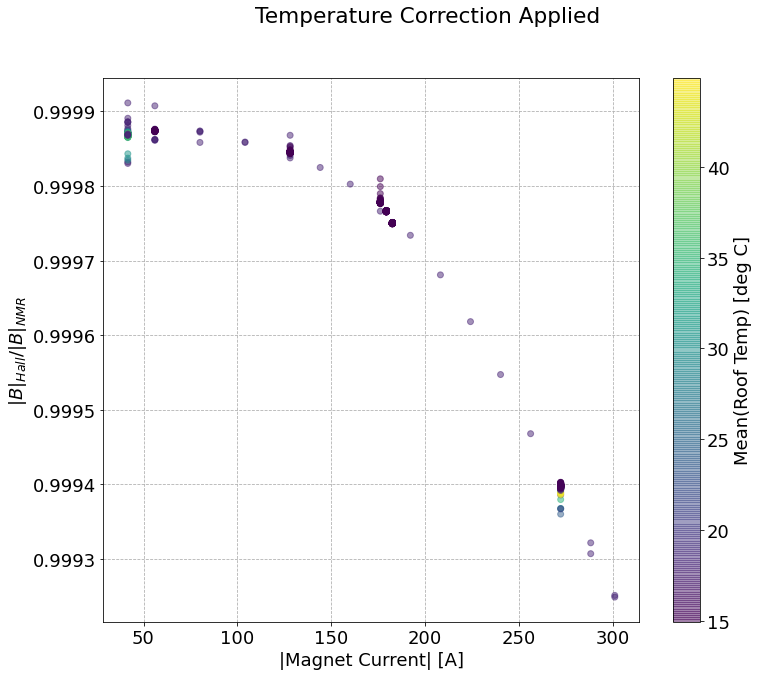

In [45]:
# mean temperature as color
fig, ax = plt.subplots(figsize=(12, 10))
Is = []
Brs = []
temps = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_run = df[df.run==run]
    t0 = df_run.iloc[0].Time
    tf = df_run.iloc[-1].Time
    df_t = df_temp.query(f'"{t0}" <= Datetime <= "{tf}"')
    temps.append(df_t['Roof'].mean())
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
    #print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
#     Is.append(df_["Magnet Current [A]"].mean())
    Is.append(abs(df_["Magnet Current [A]"].mean()))
    Brs.append(df_.sf_corr / df_['B_corr'])
    
sc = ax.scatter(Is, Brs, c=temps,alpha=0.5) #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Mean(Roof Temp) [deg C]')

# ax.set_ylim([0.9992, 1.0000])

fig.suptitle('Temperature Correction Applied')
ax.set_xlabel('|Magnet Current| [A]')
ax.set_ylabel(r'$|B|_{Hall} / |B|_{NMR}$');
# ax.legend();

In [46]:
Is = np.array(Is)
Brs = np.array(Brs)

In [47]:
np.mean(Brs[(Is <= 44) & (Is >= 40)]), np.std(Brs[(Is <= 44) & (Is >= 40)], ddof=1)

(0.9998684830861252, 6.054429678983792e-06)

In [50]:
# I0 = 56
I0 = 176
# dI = 1.
dI = 10.
np.mean(Brs[(Is <= I0+dI) & (Is >= I0-dI)]), np.std(Brs[(Is <= I0+dI) & (Is >= I0-dI)], ddof=1)

(0.9997624245888537, 1.164888379049499e-05)

In [51]:
# I0 = 42
#I0 = 56
len(Brs[(Is <= I0+dI) & (Is >= I0-dI)])

679

In [52]:
len(Brs)

1334

In [ ]:
Is

In [ ]:
Brs

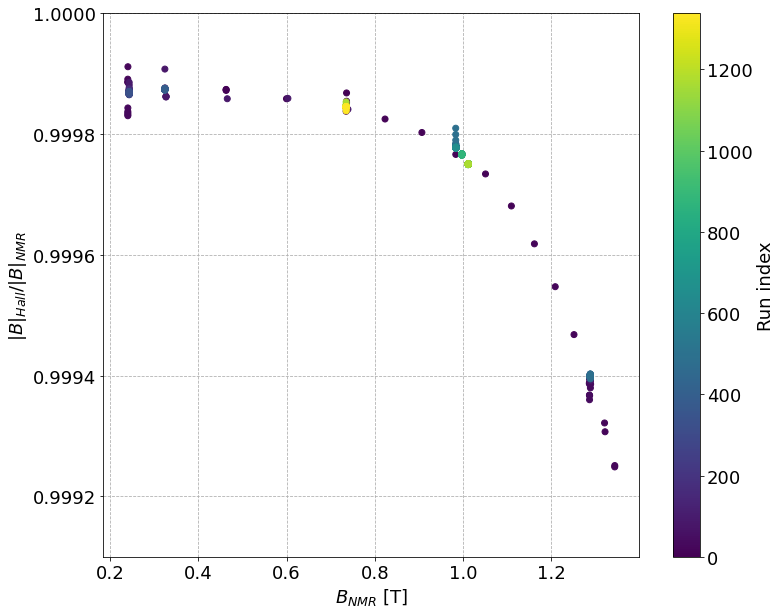

In [226]:
# Ratio vs. B
fig, ax = plt.subplots(figsize=(12, 10))
Bs = []
Brs = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
#     print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
    ##Bs.append(df_.sf)
    #Bs.append(df_['NMR [T]'])
    #Brs.append(df_.sf / df_['NMR [T]'])
    Bs.append(df_['B_corr'])
    Brs.append(df_.sf_corr / df_['B_corr'])
    
sc = ax.scatter(Bs, Brs, c=rs) #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Run index')

ax.set_ylim([0.9991, 1.0000])

#ax.set_xlabel('B_{Hall} [T]')
ax.set_xlabel(r'$B_{NMR}$ [T]')
ax.set_ylabel(r'$|B|_{Hall} / |B|_{NMR}$');
# ax.legend();

In [ ]:
# B_Hall vs. B_NMR
fig, ax = plt.subplots(figsize=(12, 10))
Bs = []
Brs = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
#     print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
    ##Bs.append(df_.sf)
    #Bs.append(df_['NMR [T]'])
    #Brs.append(df_.sf / df_['NMR [T]'])
    Bs.append(df_['B_corr'])
    Brs.append(df_.sf_corr) #/ df_['B_corr'])
    
sc = ax.scatter(Bs, Brs, c=rs) #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Run index')

ax.plot([0.2, 1.35],[0.2, 1.35], 'r--')

# ax.set_ylim([0.99875, 1.0000])

#ax.set_xlabel('B_{Hall} [T]')
ax.set_xlabel(r'$B_{NMR}$ [T]')
ax.set_ylabel(r'$|B|_{Hall}$');
# ax.legend();

In [ ]:
# B_Hall - B_NMR vs. B_NMR
fig, ax = plt.subplots(figsize=(12, 10))
Bs = []
Brs = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
#     print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
    ##Bs.append(df_.sf)
    #Bs.append(df_['NMR [T]'])
    #Brs.append(df_.sf / df_['NMR [T]'])
    Bs.append(df_['B_corr'])
    Brs.append(df_.sf_corr - df_.B_corr) #/ df_['B_corr'])
    
sc = ax.scatter(Bs, Brs, c=rs) #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Run index')

ax.plot([0., 1.35],[0., 0.], 'r--')

# ax.set_ylim([0.99875, 1.0000])

#ax.set_xlabel('B_{Hall} [T]')
ax.set_xlabel(r'$B_{NMR}$ [T]')
ax.set_ylabel(r'$|B|_{Hall} - |B|_{NMR}$');
# ax.legend();

In [ ]:
# Ratio vs. B & I
fig, ax = plt.subplots(figsize=(16, 10))
Bs = []
Brs = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
#     print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
    Bs.append(df_.sf)
    Brs.append(df_.sf / df_['NMR [T]'])
    
sc = ax.scatter(Bs, Brs, c=rs) #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Run index, vs. |B|')

ax2 = ax.twiny()
Is = []
Brs = []
rs = df.run.unique()
for run in df.run.unique():
#     df_ = df.query(f'run == {run}').copy().iloc[0]
    df_ = df[np.isclose(df.magnet_X_mm.values, 12.5, atol=1e-1, rtol=1e-3) & (df.run == run)].copy().iloc[0]
    #print(f'{run}: X={df_.magnet_X_mm:0.2f}, Y={df_.magnet_Y_mm:0.2f}, Z={df_.magnet_Z_mm:0.2f}') #, found point? {len(df_)==23}')
    Is.append(df_["Magnet Current [A]"].mean())
    Brs.append(df_.sf / df_['NMR [T]'])
    
sc = ax2.scatter(Is, Brs, c=rs, cmap='hot') #label=f'run {run}, I={df_["Magnet Current [V]"].mean():0.1f} A')
cb = fig.colorbar(sc, label='Run index, vs. I')

# ax.set_ylim([0.9992, 1.0000])

ax2.set_xlabel('Magnet Current [A]')
# ax.set_ylabel(r'$|B|_{Hall} / |B|_{NMR}$');

# ax.set_ylim([0.99875, 1.0000])

ax.set_xlabel('B_{Hall} [T]')
ax.set_ylabel(r'$|B|_{Hall} / |B|_{NMR}$');
# ax.legend();

In [ ]:
# i = 11
# Brs_low = np.array(Brs[:i])
# Is_low = np.abs(np.array(Is[:i]))

Brs_low = np.array(Brs)
Is_low = np.abs(np.array(Is))

In [ ]:
# try fitting ratios for low currents -- linear model
def lin_mod(I, **params):
    return params['c0'] + params['c1']*I

In [ ]:
model = lm.Model(lin_mod, independent_vars=['I'])
params = lm.Parameters()
params.add('c0', value=1., vary=True)
params.add('c1', value=0., vary=True)
result = model.fit(Brs_low, I=Is_low, params=params, weights=1/(5e-6 * np.ones_like(Brs_low)))

In [ ]:
result

In [ ]:
2e2 * -4e-7

In [ ]:
result.plot()

# Old (to go through)
- Temperature correction

# 3D Scan (temperature)

In [ ]:
# tempcol = 'Yoke (center magnet)'
tempcol = 'Yoke (near pole)'

In [ ]:
# final 3d scan
slowfile = ddir+'2021-06-18 102833.txt'
tempfile = ddir+'2021-06-18 102833slow.txt'

# first 3d scan (better grid)
# note Zaber labels messed up for tempfile but not slowfile
# slowfile = ddir+'2021-06-16 114150.txt'
# tempfile = ddir+'2021-06-16 114146slow.txt'

# first 3d scan at 192 (worse grid)
# note Zaber labels messed up for tempfile but not slowfile
# slowfile = ddir+'2021-06-15 145245.txt'
# tempfile = ddir+'2021-06-15 145241slow.txt'

In [ ]:
df1d_192.head()

In [ ]:
df = load_data(slowfile)
df_temp = load_data(tempfile)

In [ ]:
df_temp

In [ ]:
df

In [ ]:
df_temp

In [ ]:
# same time deltas
df_temp['seconds_delta'] = (df_temp.index - df.index[0]).total_seconds()
df_temp['hours_delta'] = (df_temp.index - df.index[0]).total_seconds()/60**2
df_temp['days_delta'] = (df_temp.index - df.index[0]).total_seconds()/(24*60**2)

In [ ]:
len(df)

In [ ]:
len(df_temp)

In [ ]:
# final 3d scan
df_temp = df_temp.query('Datetime < "2021-06-19 16:17:00"')
# first 3d scan (better grid)
# useless
# df_temp = df_temp.query('Datetime < "2021-06-19 16:17:00"')

In [ ]:
len(df_temp)

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_temp.index, df_temp['Yoke (center magnet)'])

In [ ]:
fig, ax = plt.subplots()

datetime_plt(ax, df_temp.index, df_temp['Yoke (center magnet)'], s=5, label=None, nmaj=8)
datetime_plt(ax, df_temp.index, df_temp['Yoke (near pole)'], s=5, label=None, nmaj=8)

In [ ]:
fig, ax = plt.subplots()

datetime_plt(ax, df_temp.index, df_temp[tempcol], s=5, label=None, nmaj=8)

In [ ]:
fig, ax = plt.subplots()

datetime_plt(ax, df_temp.index, df_temp['magnet_X_mm'], s=5, label=None, nmaj=8)
datetime_plt(ax, df.index, df['magnet_X_mm'], s=5, label=None, nmaj=8)

In [ ]:
t_interp = interp1d(df_temp.seconds_delta, df_temp[tempcol], kind='linear', fill_value="extrapolate")
df.loc[:, tempcol] = t_interp(df.seconds_delta)

In [ ]:
df_temp.seconds_delta

In [ ]:
t_interp([20000, 20001])

In [ ]:
df.loc[:, tempcol] = t_interp(df.seconds_delta)

In [ ]:
df

In [ ]:
fig, ax = plt.subplots()

datetime_plt(ax, df.index, df[tempcol], s=1, label=None, nmaj=8)
datetime_plt(ax, df_temp.index, df_temp[tempcol], s=5, label=None, nmaj=8)


In [ ]:
df['Magnet Current [V]'].describe()

In [ ]:
fig, ax = plt.subplots()

datetime_plt(ax, df.index, df['Magnet Current [V]'], s=1, label=None, nmaj=8)

In [ ]:
ls /home/ckampa/data/hallprobecalib_extras/datafiles/magnet_ramp/2021-02-24/

In [ ]:
df_fits = pd.read_pickle('/home/ckampa/data/hallprobecalib_extras/datafiles/magnet_ramp/2021-02-24/ramp_2021-02-24.run-info_temp_params.pkl')

In [ ]:
df_fits = df_fits.query('I > 100').copy()

In [ ]:
df_fits

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_fits.I, df_fits.B_NMR)

In [ ]:
def lin_mod(x, **params):
    return params['c0'] + params['c1'] * x

In [ ]:
model = lm.Model(lin_mod, independent_vars=['x'])
params = lm.Parameters()
params.add('c0', vary=True, value=0)
params.add('c1', vary=True, value=0)
result = model.fit(df_fits.B_NMR.values, x=df_fits.I.values, params=params)

In [ ]:
result

In [ ]:
temp_coeff = lin_mod(df['Magnet Current [V]'].mean(), **result.params) # T / deg C

In [ ]:
temp_coeff

In [ ]:
#t0 = df[tempcol].mean()
t0 = 25.6 # match 1d dataset

In [ ]:
t0

In [ ]:
df[tempcol].min(), df[tempcol].max()

In [ ]:
dB_vals = temp_coeff * (df[tempcol] - t0)

In [ ]:
dB_vals.describe()

In [ ]:
df[tempcol]

In [ ]:
dB_vals

In [ ]:
df.loc[:, 'B_corr'] = df['NMR [T]'].values + dB_vals

In [ ]:
df.magnet_Y_mm.unique(), df.magnet_Z_mm.unique()

In [ ]:
# good grid
df_ = df.query('(magnet_Y_mm == 124.6) & (magnet_Z_mm == 124.5)').copy()
# worse grid
# df_ = df.query('(magnet_Y_mm == 125.6) & (magnet_Z_mm == 125.5)').copy()

In [ ]:
len(df_)

In [ ]:
df_ = df_.query('(magnet_X_mm > 11.9)').copy()

In [ ]:
len(df_)

In [ ]:
fig, ax = plt.subplots()

# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_.sf, label=f'run {run}')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]'], label=f'raw data')
ax.scatter(df_['magnet_X_mm'], df_['B_corr'], label=f'temperature corrected data')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B| / |B|_{center}$ [T]')
ax.set_ylabel(r'$|B|$ [T]')
ax.legend();

In [ ]:
fig, ax = plt.subplots()

# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_.sf, label=f'run {run}')
ax.scatter(df_['magnet_X_mm'], df_[tempcol])#, label=f'raw data')
# ax.scatter(df_['magnet_X_mm'], df_['B_corr'], label=f'temperature corrected data')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B| / |B|_{center}$ [T]')
ax.set_ylabel('Yoke (near pole) [deg C]')
ax.legend();

In [ ]:
# include 1d
fig, ax = plt.subplots()

# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_.sf, label=f'run {run}')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]'], label=f'raw data')
ax.scatter(df_['magnet_X_mm'], df_['B_corr'], label=f'temperature corrected data')
ax.scatter(df1d_192['magnet_X_mm'], df1d_192['NMR [T]'], label=f'1d (no correction)')

ax.set_xlabel('X [mm]')
# ax.set_ylabel(r'$|B| / |B|_{center}$ [T]')
ax.set_ylabel(r'$|B|$ [T]')
ax.legend();

In [ ]:
df_.magnet_X_mm.unique()

In [ ]:
df1d_192.magnet_X_mm.unique()

In [ ]:
sf_3d_raw = df_.query('magnet_X_mm == 34.7265625').iloc[0]['NMR [T]']
sf_3d = df_.query('magnet_X_mm == 34.7265625').iloc[0]['B_corr']
sf_1d = df1d_192.query('magnet_X_mm == 34.7265625').iloc[0]['NMR [T]']

In [ ]:
sf_3d_raw, sf_3d, sf_1d

In [ ]:
# scale to Hall probe point

In [ ]:
# include 1d
fig, ax = plt.subplots()

# ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/df_.sf, label=f'run {run}')
ax.scatter(df_['magnet_X_mm'], df_['NMR [T]']/sf_3d_raw, label=f'raw data')
ax.scatter(df_['magnet_X_mm'], df_['B_corr']/sf_3d, label=f'temperature corrected data')
ax.scatter(df1d_192['magnet_X_mm'], df1d_192['NMR [T]']/sf_1d, label=f'1d (no correction)')

ax.set_xlabel('X [mm]')
ax.set_ylabel(r'$|B| / |B|_{center}$')
# ax.set_ylabel(r'$|B|$ [T]')
ax.legend();